# All the Imports

In [1]:
import sys
import os
import logging
sys.path.insert(1, '../src/')

In [2]:
%%time 
import itertools 
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder
from lassonet import LassoNetClassifier



from RankCorr.picturedRocks import Rocks
import smashpy as smashpy

import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

from utils import *


CPU times: user 7.84 s, sys: 517 ms, total: 8.36 s
Wall time: 7.79 s


In [3]:
logging.getLogger("lightning").setLevel(logging.ERROR)
pl_loggers = [ logging.getLogger(name) for name in logging.root.manager.loggerDict if 'lightning' in name ]

for logger in pl_loggers:
    logger.setLevel(logging.ERROR)

# These should be parameters later on 

In [4]:
z_size = 16
hidden_layer_size = 64

# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
batch_size = 64
batch_norm = True


global_t = 3.0

k_range = [10, 25, 50, 100, 250]
num_times = 10
k = 50
gpus = 1
tpu_cores = None
precision = 32

In [5]:
import multiprocessing

num_cores = multiprocessing.cpu_count()

# Here goes all the stuff that we change from dataset to dataset

In [6]:
from os import path

In [7]:
dataset_dir = '../data/CITE-seq/'
model_save_path = '../data/CITE-seq/models/'
viz_save_path = '../data/CITE-seq/visualizations/'

if not path.exists(model_save_path):
  os.makedirs(model_save_path)

if not path.exists(model_save_path + 'experiment_data_folds/'):
  os.makedirs(model_save_path + 'experiment_data_folds/')
  
if not path.exists(viz_save_path):
  os.makedirs(viz_save_path)

  

# Dataset Specific Processing

`

In [8]:
citeseq_adata = sc.read_h5ad(dataset_dir + "CITEseq.h5ad")

In [9]:
citeseq_adata.shape

(8617, 500)

In [10]:
X = citeseq_adata.X.copy()

In [11]:
citeseq_adata.obs['annotation'] = citeseq_adata.obs['names']
labels = citeseq_adata.obs['names'].values
encoder = LabelEncoder()
encoder.fit(labels)
y = encoder.transform(labels)

In [12]:
input_size = X.shape[1]

In [13]:
X.shape

(8617, 500)

# Set Up Models

Training here will differ than in other notebooks.

Training multiple times at k = 50

Also training one trial at k's ranging from 10 to 250.

## All Markers

In [14]:
%%time
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    all_markers = np.arange(X.shape[1])
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = all_markers)
    np.save(model_save_path + 'all_markers_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'all_markers_{}.npy'.format(tryy), all_markers)
    np.save(model_save_path + 'experiment_data_folds/all_markers_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'All Marker Visualization', path = viz_save_path + 'all_markers_{}.pdf'.format(tryy), markers = all_markers)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Pr

CPU times: user 8min 32s, sys: 5.76 s, total: 8min 38s
Wall time: 3min 59s


## Train Smash Random Forest





In [15]:
# needed for random forest Smash
!mkdir Figures

mkdir: cannot create directory ‘Figures’: File exists


 * Initialising ...

Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

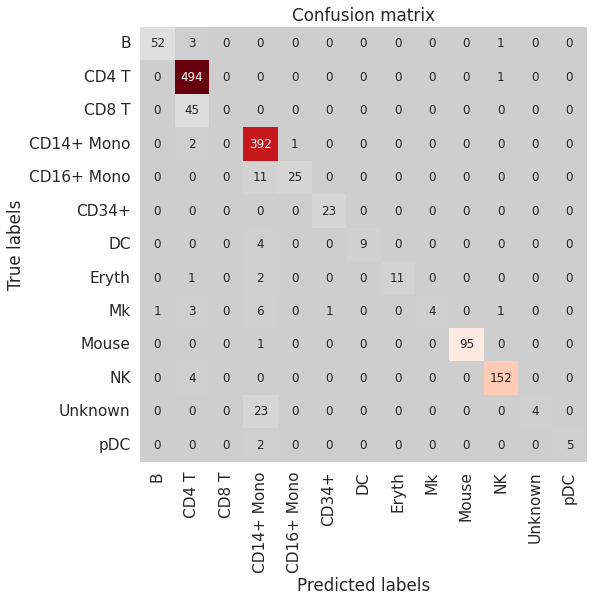

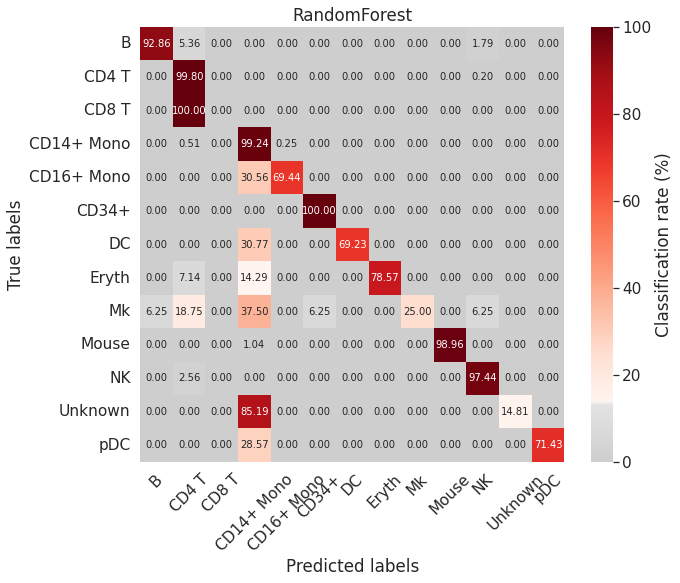

Accuracy: 0.9180565627266135: Misclassification: 0.08194343727338649
              precision    recall  f1-score   support

           B       0.98      0.93      0.95        56
       CD4 T       0.89      1.00      0.94       495
       CD8 T       0.00      0.00      0.00        45
  CD14+ Mono       0.89      0.99      0.94       395
  CD16+ Mono       0.96      0.69      0.81        36
       CD34+       0.96      1.00      0.98        23
          DC       1.00      0.69      0.82        13
       Eryth       1.00      0.79      0.88        14
          Mk       1.00      0.25      0.40        16
       Mouse       1.00      0.99      0.99        96
          NK       0.98      0.97      0.98       156
     Unknown       1.00      0.15      0.26        27
         pDC       1.00      0.71      0.83         7

    accuracy                           0.92      1379
   macro avg       0.90      0.71      0.75      1379
weighted avg       0.89      0.92      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

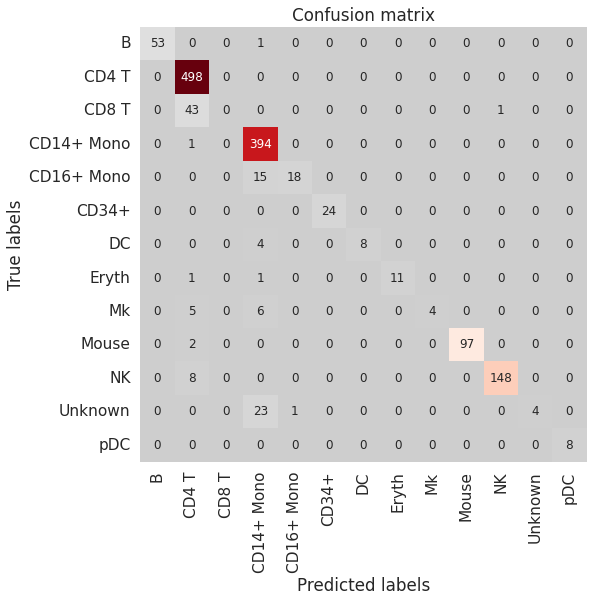

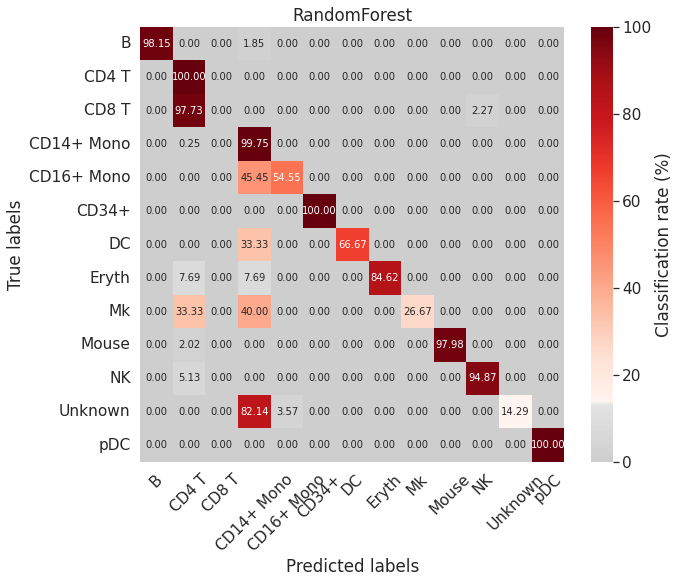

Accuracy: 0.9187817258883249: Misclassification: 0.08121827411167515
              precision    recall  f1-score   support

           B       1.00      0.98      0.99        54
       CD4 T       0.89      1.00      0.94       498
       CD8 T       0.00      0.00      0.00        44
  CD14+ Mono       0.89      1.00      0.94       395
  CD16+ Mono       0.95      0.55      0.69        33
       CD34+       1.00      1.00      1.00        24
          DC       1.00      0.67      0.80        12
       Eryth       1.00      0.85      0.92        13
          Mk       1.00      0.27      0.42        15
       Mouse       1.00      0.98      0.99        99
          NK       0.99      0.95      0.97       156
     Unknown       1.00      0.14      0.25        28
         pDC       1.00      1.00      1.00         8

    accuracy                           0.92      1379
   macro avg       0.90      0.72      0.76      1379
weighted avg       0.89      0.92      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

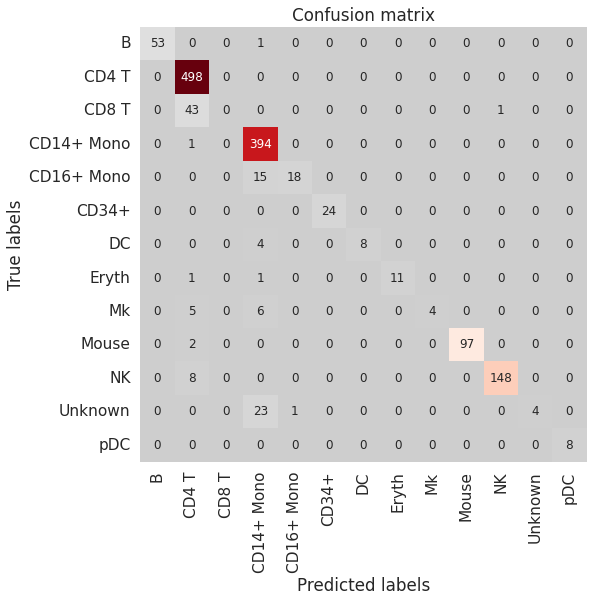

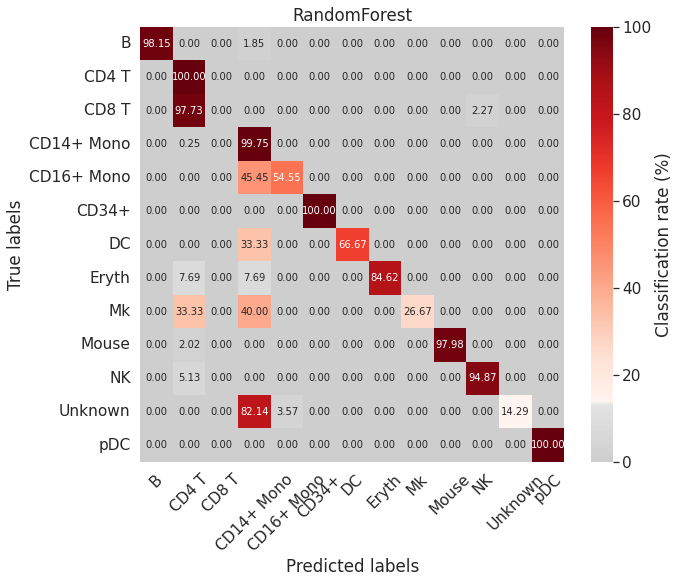

Accuracy: 0.9187817258883249: Misclassification: 0.08121827411167515
              precision    recall  f1-score   support

           B       1.00      0.98      0.99        54
       CD4 T       0.89      1.00      0.94       498
       CD8 T       0.00      0.00      0.00        44
  CD14+ Mono       0.89      1.00      0.94       395
  CD16+ Mono       0.95      0.55      0.69        33
       CD34+       1.00      1.00      1.00        24
          DC       1.00      0.67      0.80        12
       Eryth       1.00      0.85      0.92        13
          Mk       1.00      0.27      0.42        15
       Mouse       1.00      0.98      0.99        99
          NK       0.99      0.95      0.97       156
     Unknown       1.00      0.14      0.25        28
         pDC       1.00      1.00      1.00         8

    accuracy                           0.92      1379
   macro avg       0.90      0.72      0.76      1379
weighted avg       0.89      0.92      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

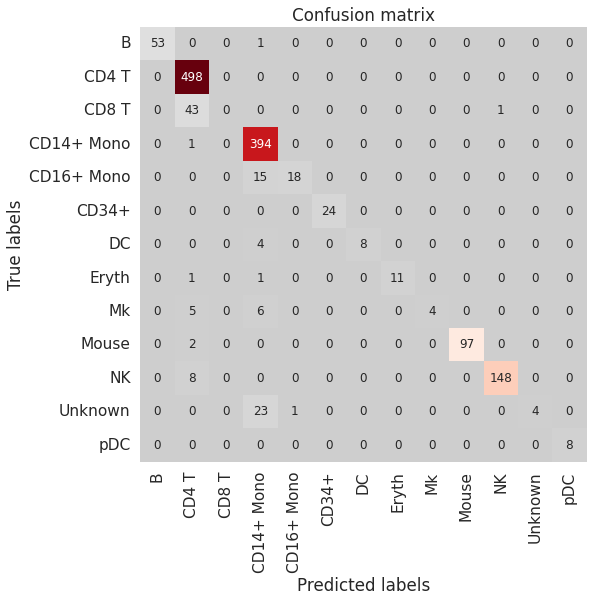

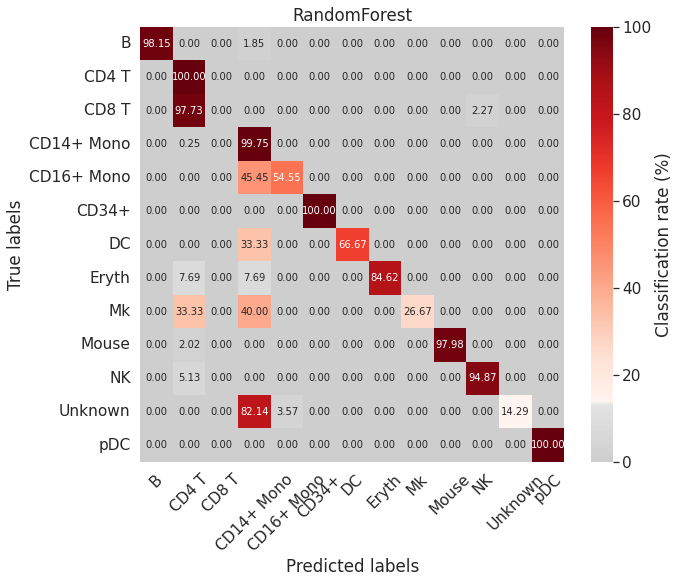

Accuracy: 0.9187817258883249: Misclassification: 0.08121827411167515
              precision    recall  f1-score   support

           B       1.00      0.98      0.99        54
       CD4 T       0.89      1.00      0.94       498
       CD8 T       0.00      0.00      0.00        44
  CD14+ Mono       0.89      1.00      0.94       395
  CD16+ Mono       0.95      0.55      0.69        33
       CD34+       1.00      1.00      1.00        24
          DC       1.00      0.67      0.80        12
       Eryth       1.00      0.85      0.92        13
          Mk       1.00      0.27      0.42        15
       Mouse       1.00      0.98      0.99        99
          NK       0.99      0.95      0.97       156
     Unknown       1.00      0.14      0.25        28
         pDC       1.00      1.00      1.00         8

    accuracy                           0.92      1379
   macro avg       0.90      0.72      0.76      1379
weighted avg       0.89      0.92      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

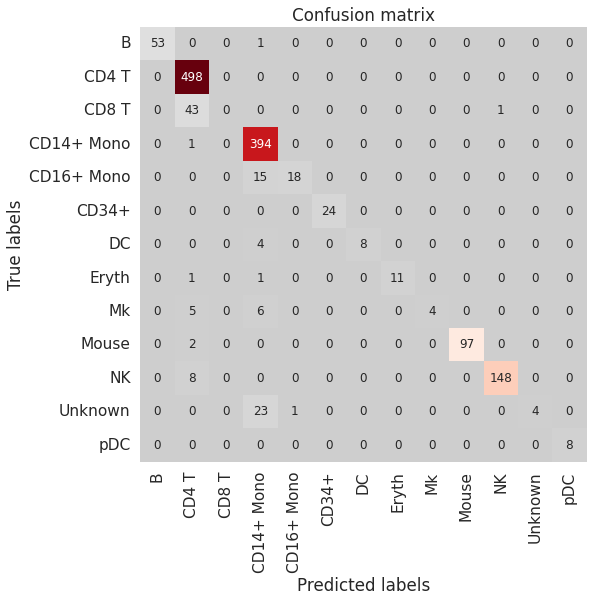

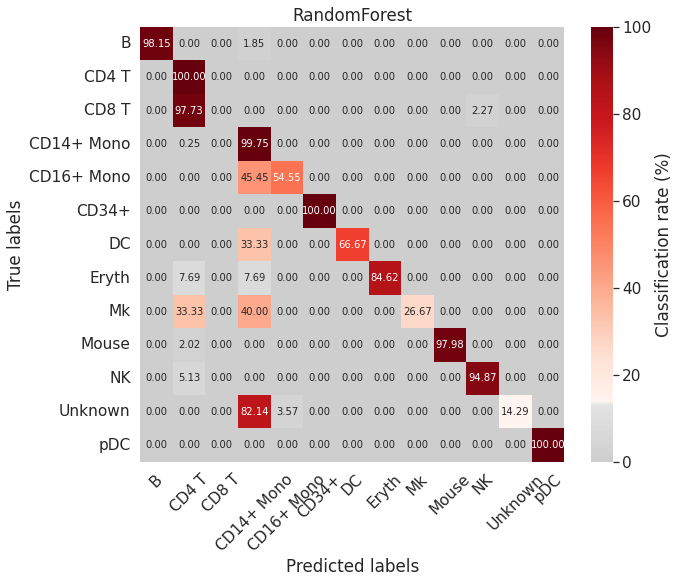

Accuracy: 0.9187817258883249: Misclassification: 0.08121827411167515
              precision    recall  f1-score   support

           B       1.00      0.98      0.99        54
       CD4 T       0.89      1.00      0.94       498
       CD8 T       0.00      0.00      0.00        44
  CD14+ Mono       0.89      1.00      0.94       395
  CD16+ Mono       0.95      0.55      0.69        33
       CD34+       1.00      1.00      1.00        24
          DC       1.00      0.67      0.80        12
       Eryth       1.00      0.85      0.92        13
          Mk       1.00      0.27      0.42        15
       Mouse       1.00      0.98      0.99        99
          NK       0.99      0.95      0.97       156
     Unknown       1.00      0.14      0.25        28
         pDC       1.00      1.00      1.00         8

    accuracy                           0.92      1379
   macro avg       0.90      0.72      0.76      1379
weighted avg       0.89      0.92      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


CPU times: user 3min 56s, sys: 4.81 s, total: 4min 1s
Wall time: 1min 54s


In [16]:
%%time
for k in k_range:
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = citeseq_adata[np.concatenate([train_indices, val_indices]), :]
    sm = smashpy.smashpy()
    clf = sm.ensemble_learning(train_X_y, group_by="annotation", classifier="RandomForest", balance=True, verbose=True)
    selectedGenes, selectedGenes_dict = sm.gini_importance(train_X_y, clf, group_by="annotation", verbose=True, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = citeseq_adata.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_rf_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'smash_rf_markers_k_{}.npy'.format(k), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_rf_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Smash Random Forest Marker Visualization', path = viz_save_path + 'smash_rf_markers_k_{}.png'.format(k), markers = smash_markers)

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

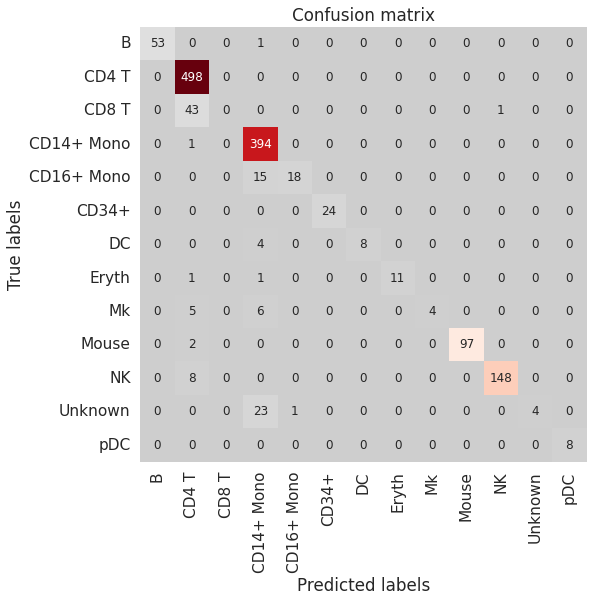

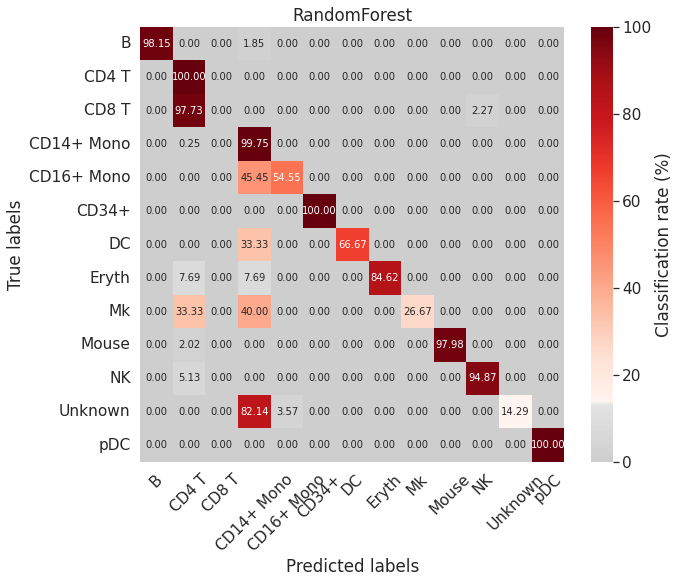

Accuracy: 0.9187817258883249: Misclassification: 0.08121827411167515
              precision    recall  f1-score   support

           B       1.00      0.98      0.99        54
       CD4 T       0.89      1.00      0.94       498
       CD8 T       0.00      0.00      0.00        44
  CD14+ Mono       0.89      1.00      0.94       395
  CD16+ Mono       0.95      0.55      0.69        33
       CD34+       1.00      1.00      1.00        24
          DC       1.00      0.67      0.80        12
       Eryth       1.00      0.85      0.92        13
          Mk       1.00      0.27      0.42        15
       Mouse       1.00      0.98      0.99        99
          NK       0.99      0.95      0.97       156
     Unknown       1.00      0.14      0.25        28
         pDC       1.00      1.00      1.00         8

    accuracy                           0.92      1379
   macro avg       0.90      0.72      0.76      1379
weighted avg       0.89      0.92      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

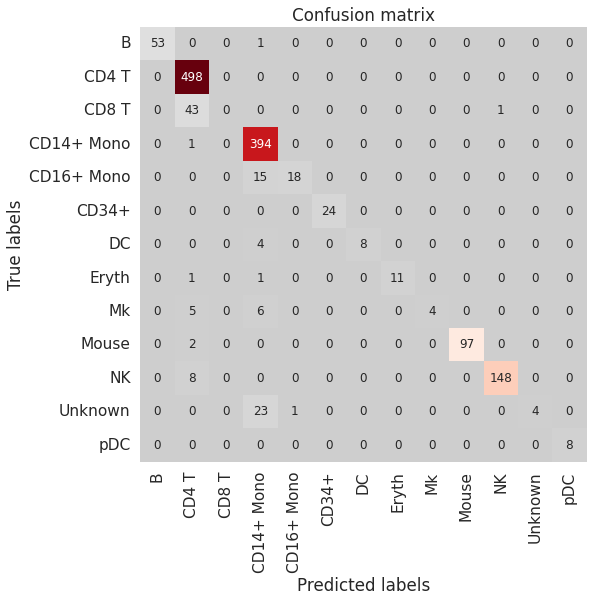

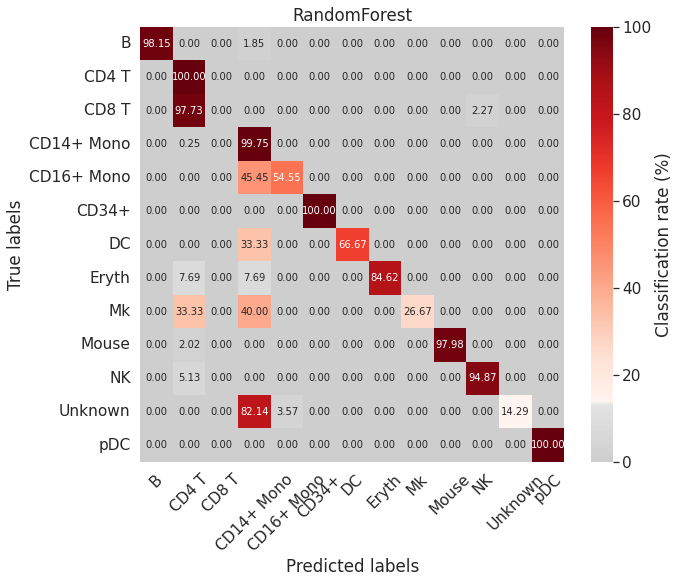

Accuracy: 0.9187817258883249: Misclassification: 0.08121827411167515
              precision    recall  f1-score   support

           B       1.00      0.98      0.99        54
       CD4 T       0.89      1.00      0.94       498
       CD8 T       0.00      0.00      0.00        44
  CD14+ Mono       0.89      1.00      0.94       395
  CD16+ Mono       0.95      0.55      0.69        33
       CD34+       1.00      1.00      1.00        24
          DC       1.00      0.67      0.80        12
       Eryth       1.00      0.85      0.92        13
          Mk       1.00      0.27      0.42        15
       Mouse       1.00      0.98      0.99        99
          NK       0.99      0.95      0.97       156
     Unknown       1.00      0.14      0.25        28
         pDC       1.00      1.00      1.00         8

    accuracy                           0.92      1379
   macro avg       0.90      0.72      0.76      1379
weighted avg       0.89      0.92      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

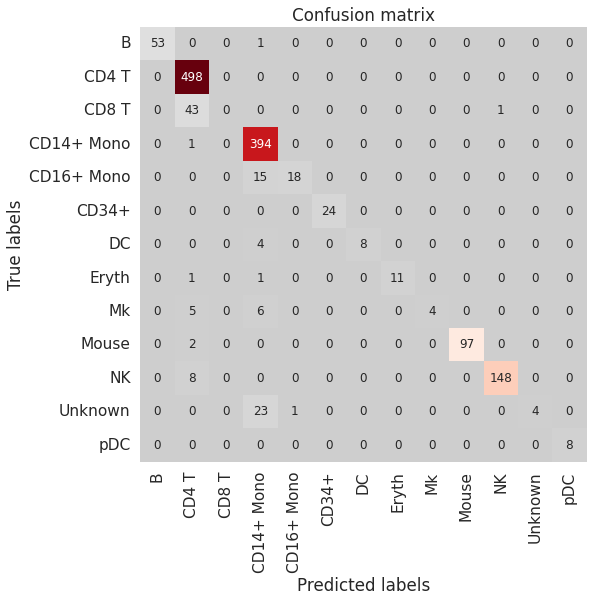

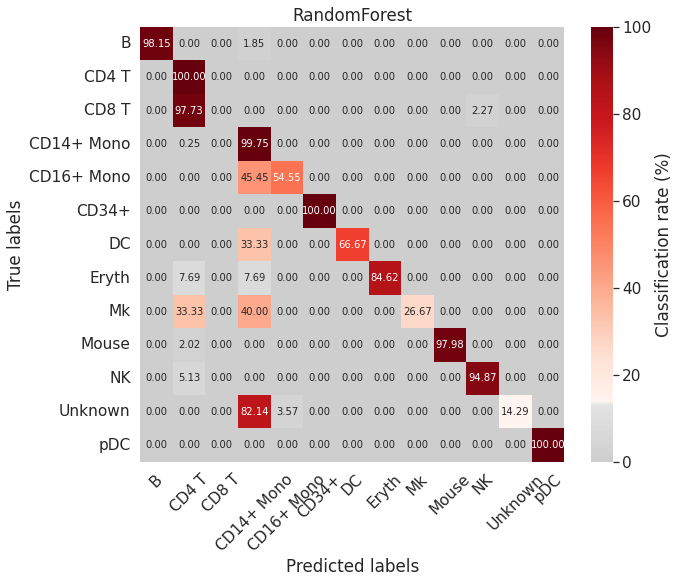

Accuracy: 0.9187817258883249: Misclassification: 0.08121827411167515
              precision    recall  f1-score   support

           B       1.00      0.98      0.99        54
       CD4 T       0.89      1.00      0.94       498
       CD8 T       0.00      0.00      0.00        44
  CD14+ Mono       0.89      1.00      0.94       395
  CD16+ Mono       0.95      0.55      0.69        33
       CD34+       1.00      1.00      1.00        24
          DC       1.00      0.67      0.80        12
       Eryth       1.00      0.85      0.92        13
          Mk       1.00      0.27      0.42        15
       Mouse       1.00      0.98      0.99        99
          NK       0.99      0.95      0.97       156
     Unknown       1.00      0.14      0.25        28
         pDC       1.00      1.00      1.00         8

    accuracy                           0.92      1379
   macro avg       0.90      0.72      0.76      1379
weighted avg       0.89      0.92      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

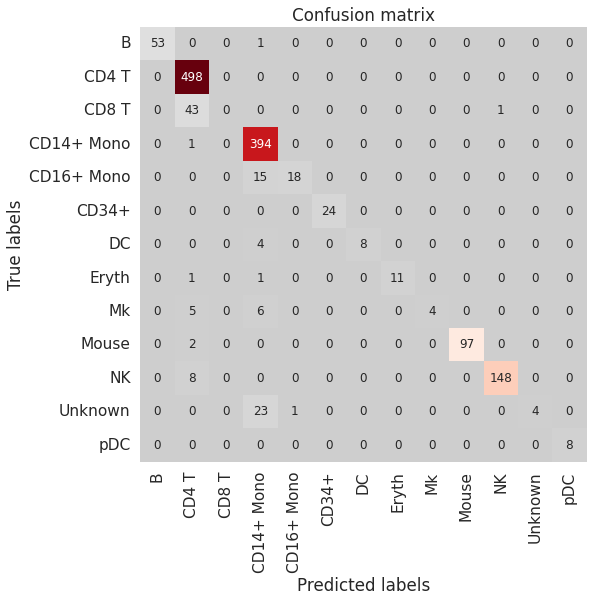

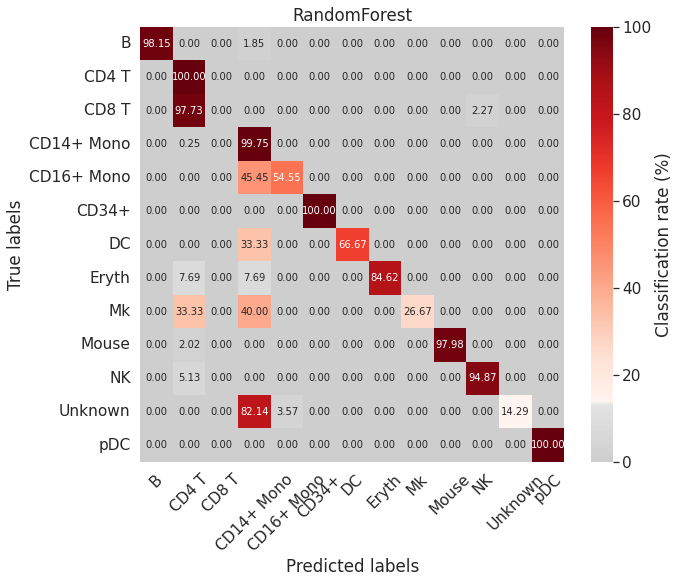

Accuracy: 0.9187817258883249: Misclassification: 0.08121827411167515
              precision    recall  f1-score   support

           B       1.00      0.98      0.99        54
       CD4 T       0.89      1.00      0.94       498
       CD8 T       0.00      0.00      0.00        44
  CD14+ Mono       0.89      1.00      0.94       395
  CD16+ Mono       0.95      0.55      0.69        33
       CD34+       1.00      1.00      1.00        24
          DC       1.00      0.67      0.80        12
       Eryth       1.00      0.85      0.92        13
          Mk       1.00      0.27      0.42        15
       Mouse       1.00      0.98      0.99        99
          NK       0.99      0.95      0.97       156
     Unknown       1.00      0.14      0.25        28
         pDC       1.00      1.00      1.00         8

    accuracy                           0.92      1379
   macro avg       0.90      0.72      0.76      1379
weighted avg       0.89      0.92      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

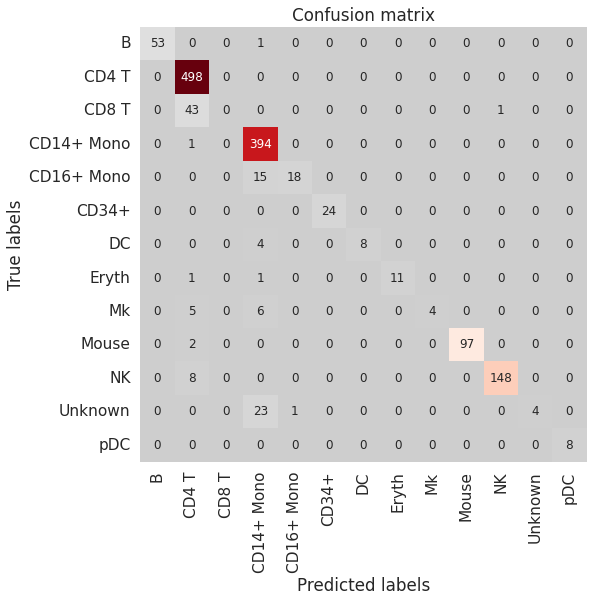

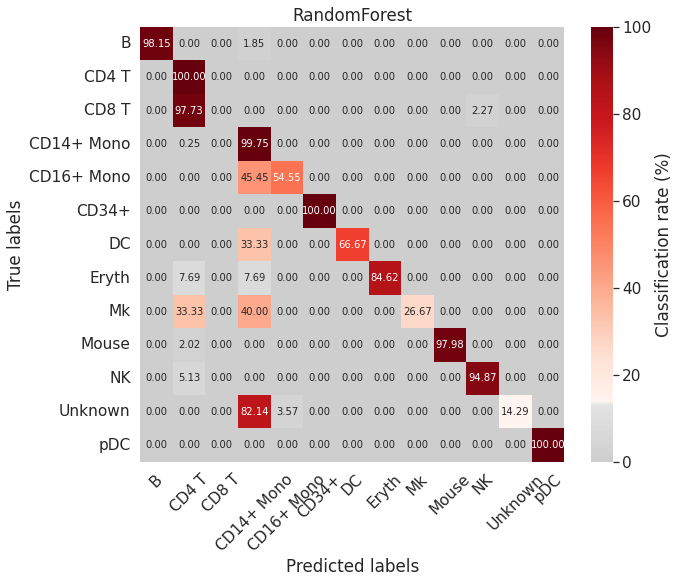

Accuracy: 0.9187817258883249: Misclassification: 0.08121827411167515
              precision    recall  f1-score   support

           B       1.00      0.98      0.99        54
       CD4 T       0.89      1.00      0.94       498
       CD8 T       0.00      0.00      0.00        44
  CD14+ Mono       0.89      1.00      0.94       395
  CD16+ Mono       0.95      0.55      0.69        33
       CD34+       1.00      1.00      1.00        24
          DC       1.00      0.67      0.80        12
       Eryth       1.00      0.85      0.92        13
          Mk       1.00      0.27      0.42        15
       Mouse       1.00      0.98      0.99        99
          NK       0.99      0.95      0.97       156
     Unknown       1.00      0.14      0.25        28
         pDC       1.00      1.00      1.00         8

    accuracy                           0.92      1379
   macro avg       0.90      0.72      0.76      1379
weighted avg       0.89      0.92      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

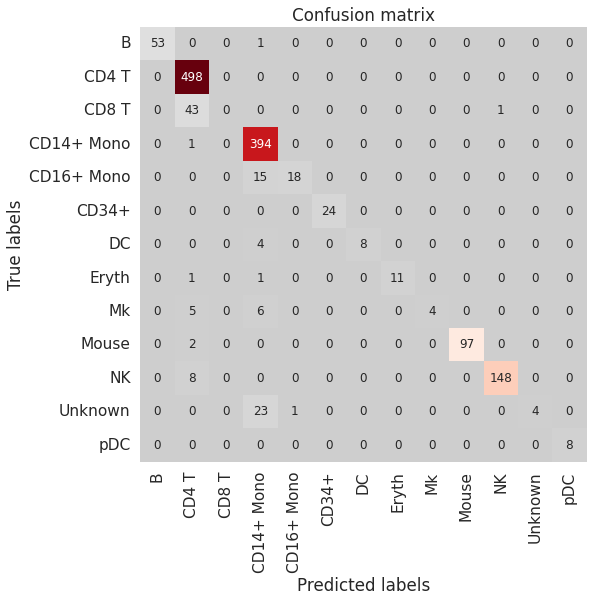

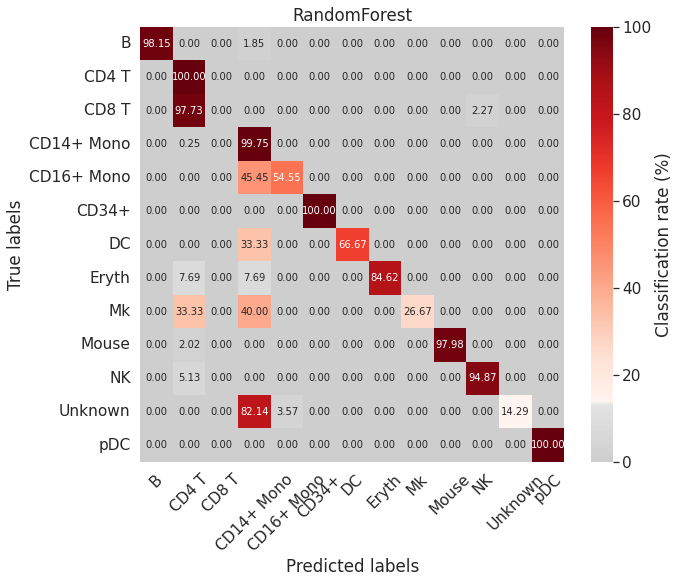

Accuracy: 0.9187817258883249: Misclassification: 0.08121827411167515
              precision    recall  f1-score   support

           B       1.00      0.98      0.99        54
       CD4 T       0.89      1.00      0.94       498
       CD8 T       0.00      0.00      0.00        44
  CD14+ Mono       0.89      1.00      0.94       395
  CD16+ Mono       0.95      0.55      0.69        33
       CD34+       1.00      1.00      1.00        24
          DC       1.00      0.67      0.80        12
       Eryth       1.00      0.85      0.92        13
          Mk       1.00      0.27      0.42        15
       Mouse       1.00      0.98      0.99        99
          NK       0.99      0.95      0.97       156
     Unknown       1.00      0.14      0.25        28
         pDC       1.00      1.00      1.00         8

    accuracy                           0.92      1379
   macro avg       0.90      0.72      0.76      1379
weighted avg       0.89      0.92      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

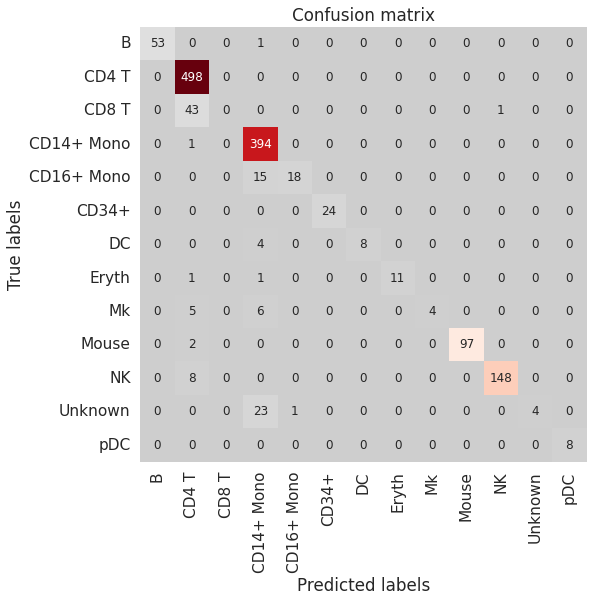

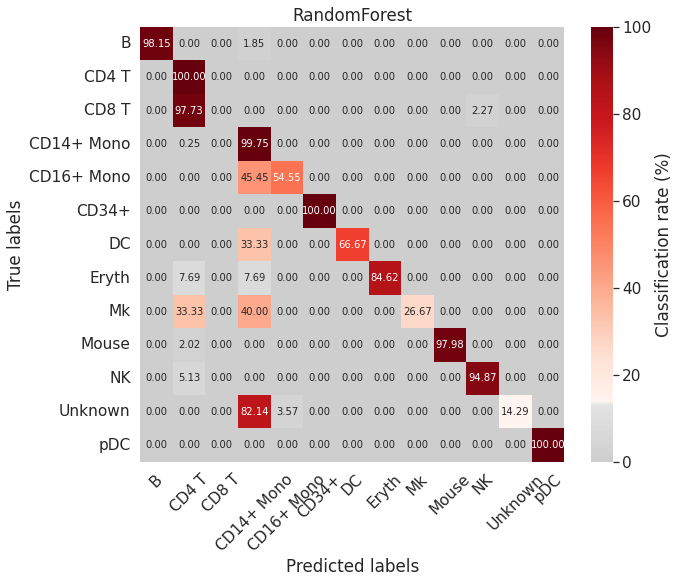

Accuracy: 0.9187817258883249: Misclassification: 0.08121827411167515
              precision    recall  f1-score   support

           B       1.00      0.98      0.99        54
       CD4 T       0.89      1.00      0.94       498
       CD8 T       0.00      0.00      0.00        44
  CD14+ Mono       0.89      1.00      0.94       395
  CD16+ Mono       0.95      0.55      0.69        33
       CD34+       1.00      1.00      1.00        24
          DC       1.00      0.67      0.80        12
       Eryth       1.00      0.85      0.92        13
          Mk       1.00      0.27      0.42        15
       Mouse       1.00      0.98      0.99        99
          NK       0.99      0.95      0.97       156
     Unknown       1.00      0.14      0.25        28
         pDC       1.00      1.00      1.00         8

    accuracy                           0.92      1379
   macro avg       0.90      0.72      0.76      1379
weighted avg       0.89      0.92      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

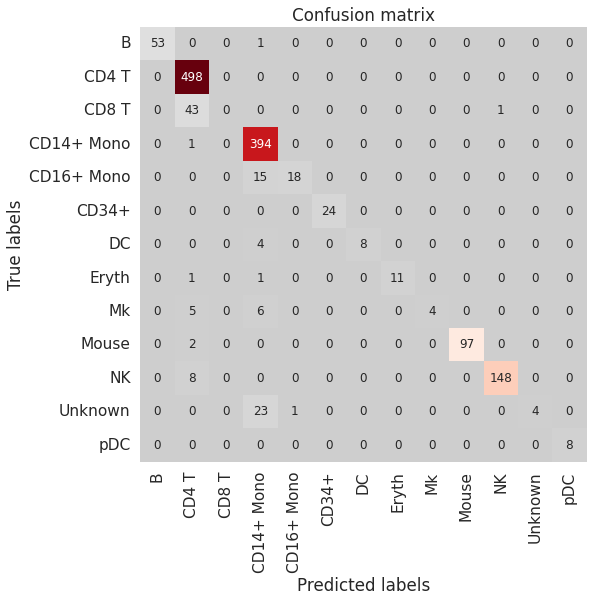

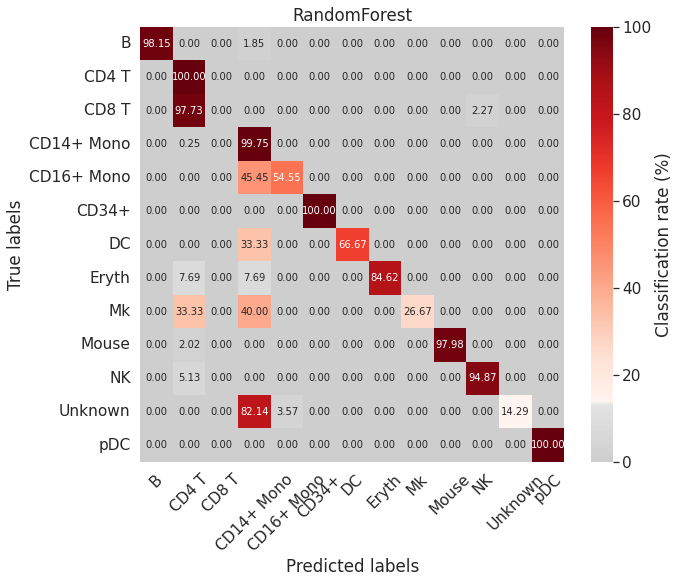

Accuracy: 0.9187817258883249: Misclassification: 0.08121827411167515
              precision    recall  f1-score   support

           B       1.00      0.98      0.99        54
       CD4 T       0.89      1.00      0.94       498
       CD8 T       0.00      0.00      0.00        44
  CD14+ Mono       0.89      1.00      0.94       395
  CD16+ Mono       0.95      0.55      0.69        33
       CD34+       1.00      1.00      1.00        24
          DC       1.00      0.67      0.80        12
       Eryth       1.00      0.85      0.92        13
          Mk       1.00      0.27      0.42        15
       Mouse       1.00      0.98      0.99        99
          NK       0.99      0.95      0.97       156
     Unknown       1.00      0.14      0.25        28
         pDC       1.00      1.00      1.00         8

    accuracy                           0.92      1379
   macro avg       0.90      0.72      0.76      1379
weighted avg       0.89      0.92      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

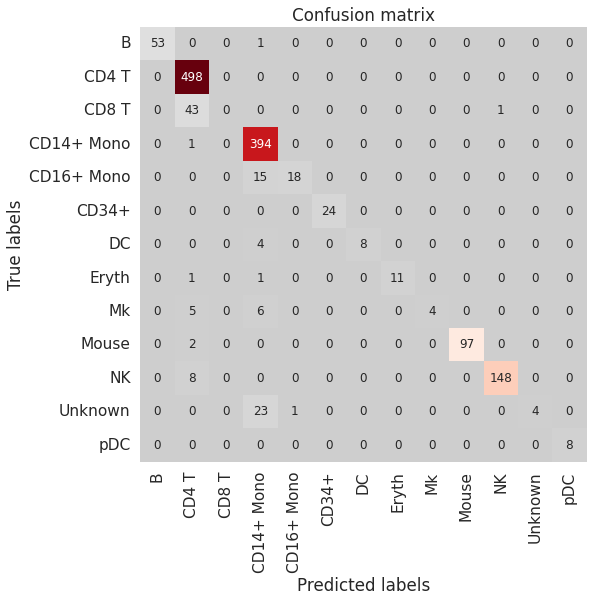

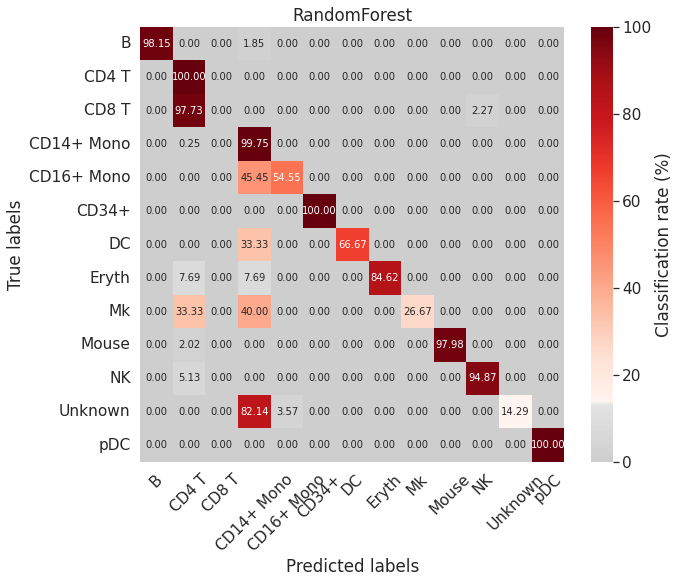

Accuracy: 0.9187817258883249: Misclassification: 0.08121827411167515
              precision    recall  f1-score   support

           B       1.00      0.98      0.99        54
       CD4 T       0.89      1.00      0.94       498
       CD8 T       0.00      0.00      0.00        44
  CD14+ Mono       0.89      1.00      0.94       395
  CD16+ Mono       0.95      0.55      0.69        33
       CD34+       1.00      1.00      1.00        24
          DC       1.00      0.67      0.80        12
       Eryth       1.00      0.85      0.92        13
          Mk       1.00      0.27      0.42        15
       Mouse       1.00      0.98      0.99        99
          NK       0.99      0.95      0.97       156
     Unknown       1.00      0.14      0.25        28
         pDC       1.00      1.00      1.00         8

    accuracy                           0.92      1379
   macro avg       0.90      0.72      0.76      1379
weighted avg       0.89      0.92      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

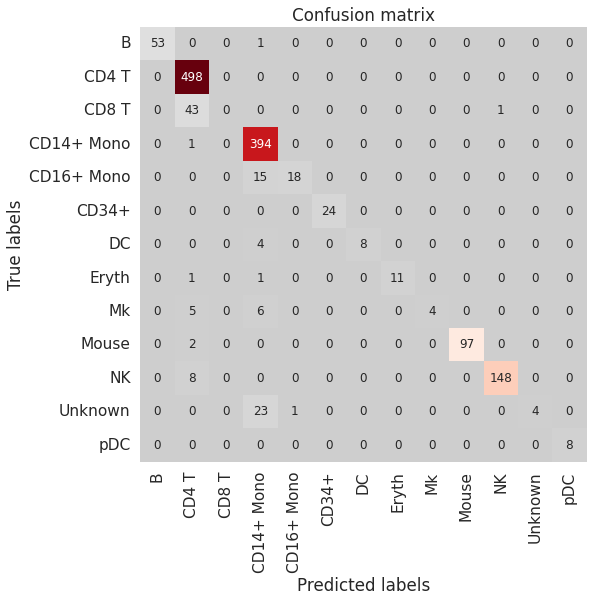

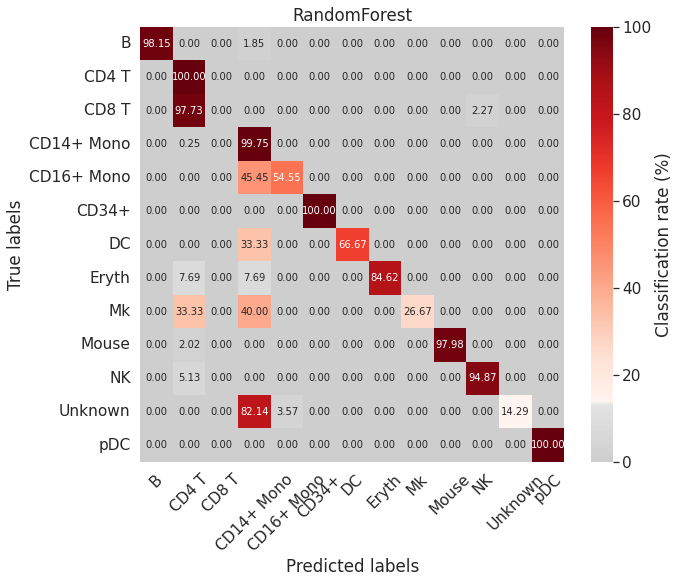

Accuracy: 0.9187817258883249: Misclassification: 0.08121827411167515
              precision    recall  f1-score   support

           B       1.00      0.98      0.99        54
       CD4 T       0.89      1.00      0.94       498
       CD8 T       0.00      0.00      0.00        44
  CD14+ Mono       0.89      1.00      0.94       395
  CD16+ Mono       0.95      0.55      0.69        33
       CD34+       1.00      1.00      1.00        24
          DC       1.00      0.67      0.80        12
       Eryth       1.00      0.85      0.92        13
          Mk       1.00      0.27      0.42        15
       Mouse       1.00      0.98      0.99        99
          NK       0.99      0.95      0.97       156
     Unknown       1.00      0.14      0.25        28
         pDC       1.00      1.00      1.00         8

    accuracy                           0.92      1379
   macro avg       0.90      0.72      0.76      1379
weighted avg       0.89      0.92      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


CPU times: user 7min 43s, sys: 9.7 s, total: 7min 53s
Wall time: 3min 41s


In [17]:
%%time
k = 50
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = citeseq_adata[np.concatenate([train_indices, val_indices]), :]
    sm = smashpy.smashpy()
    clf = sm.ensemble_learning(train_X_y, group_by="annotation", classifier="RandomForest", balance=True, verbose=True)
    selectedGenes, selectedGenes_dict = sm.gini_importance(train_X_y, clf, group_by="annotation", verbose=True, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = citeseq_adata.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_rf_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'smash_rf_markers_{}.npy'.format(tryy), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_rf_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Smash Random Forest Marker Visualization', path = viz_save_path + 'smash_rf_markers_{}.png'.format(tryy), markers = smash_markers)

## Train Smash DNN

the data is treated a bit differently than our other models

 * Initialising ...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                16032     
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
activation_1 (Activation)    (None, 

69/69 [==============================] - 0s 3ms/step - loss: 0.6585 - accuracy: 0.7537 - auc: 0.9817 - precision: 0.9247 - recall: 0.3972 - val_loss: 0.6936 - val_accuracy: 0.8683 - val_auc: 0.9937 - val_precision: 0.9610 - val_recall: 0.5145

Epoch 00018: val_loss improved from 0.76736 to 0.69364, saving model to weights/best_model_annotation.h5
Epoch 19/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.7859 - auc: 0.9846 - precision: 0.9252 - recall: 0.4503 - val_loss: 0.6750 - val_accuracy: 0.8608 - val_auc: 0.9932 - val_precision: 0.9591 - val_recall: 0.5708

Epoch 00019: val_loss improved from 0.69364 to 0.67500, saving model to weights/best_model_annotation.h5
Epoch 20/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6001 - accuracy: 0.7777 - auc: 0.9844 - precision: 0.9239 - recall: 0.4806 - val_loss: 0.6611 - val_accuracy: 0.8677 - val_auc: 0.9934 - val_precision: 0.9495 - val_recall: 0.5783

Epoch 00020: val_loss improved f

69/69 [==============================] - 0s 3ms/step - loss: 0.2241 - accuracy: 0.8984 - auc: 0.9962 - precision: 0.9310 - recall: 0.8477 - val_loss: 0.2626 - val_accuracy: 0.9240 - val_auc: 0.9972 - val_precision: 0.9354 - val_recall: 0.9066

Epoch 00042: val_loss improved from 0.26873 to 0.26261, saving model to weights/best_model_annotation.h5
Epoch 43/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2287 - accuracy: 0.9022 - auc: 0.9963 - precision: 0.9357 - recall: 0.8532 - val_loss: 0.2960 - val_accuracy: 0.9095 - val_auc: 0.9966 - val_precision: 0.9237 - val_recall: 0.8852

Epoch 00043: val_loss did not improve from 0.26261
Epoch 44/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2053 - accuracy: 0.9053 - auc: 0.9965 - precision: 0.9386 - recall: 0.8567 - val_loss: 0.2530 - val_accuracy: 0.9298 - val_auc: 0.9973 - val_precision: 0.9402 - val_recall: 0.9113

Epoch 00044: val_loss improved from 0.26261 to 0.25305, saving model to weights/best_m

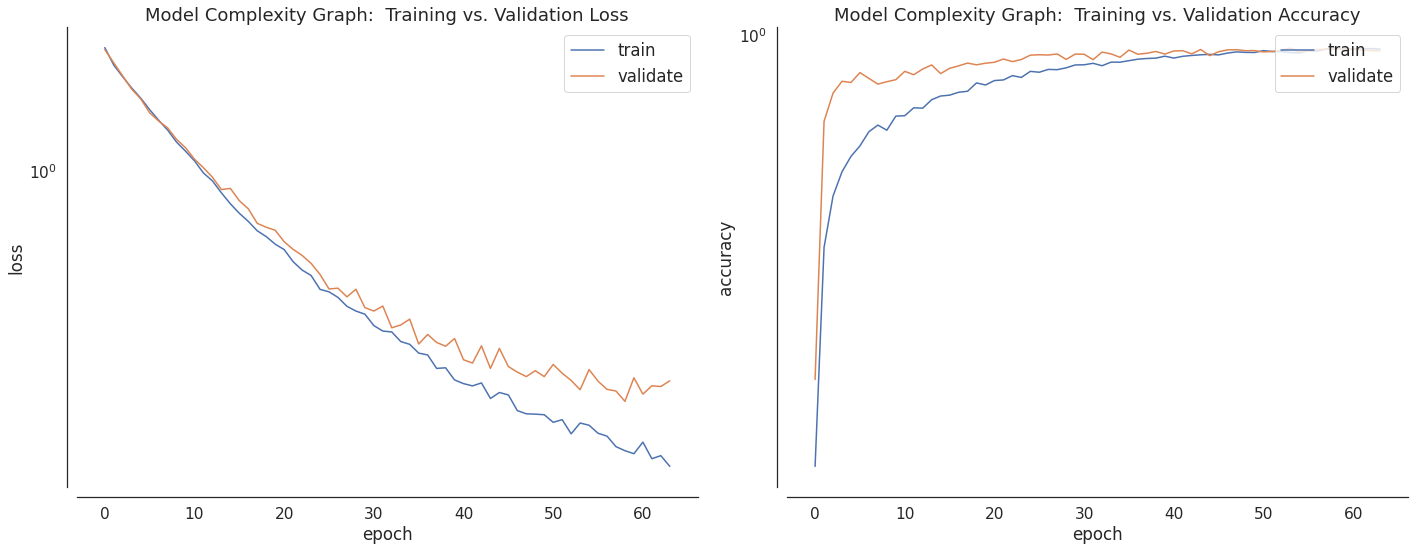

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

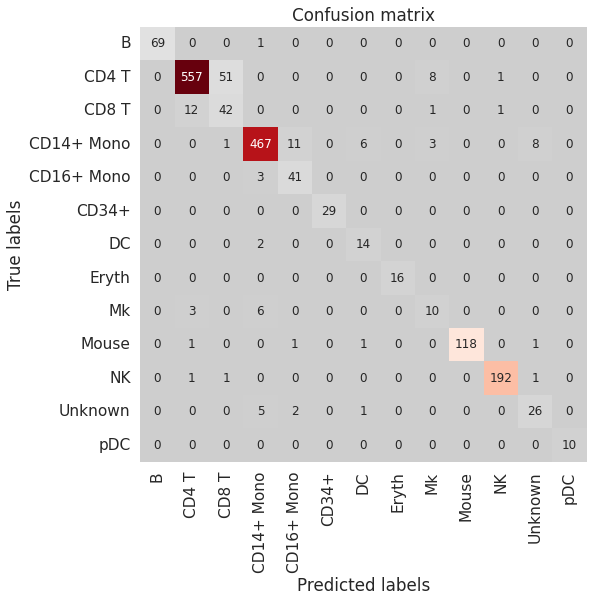

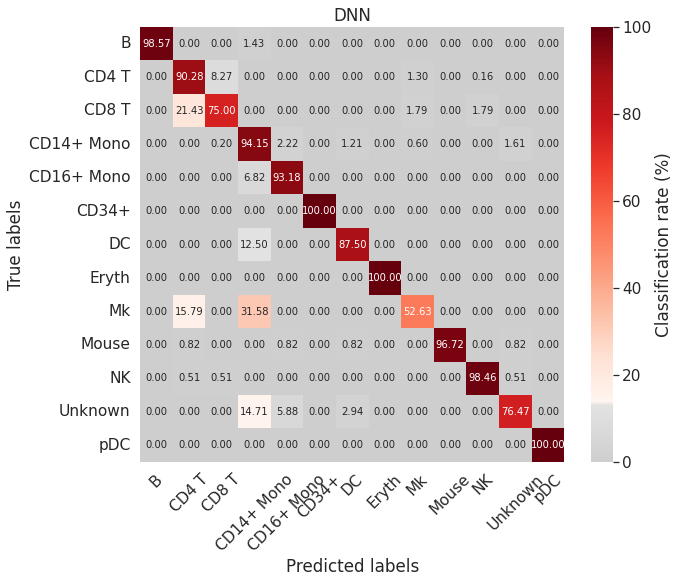

              precision    recall  f1-score   support

           B       1.00      0.99      0.99        70
       CD4 T       0.97      0.90      0.94       617
       CD8 T       0.44      0.75      0.56        56
  CD14+ Mono       0.96      0.94      0.95       496
  CD16+ Mono       0.75      0.93      0.83        44
       CD34+       1.00      1.00      1.00        29
          DC       0.64      0.88      0.74        16
       Eryth       1.00      1.00      1.00        16
          Mk       0.45      0.53      0.49        19
       Mouse       1.00      0.97      0.98       122
          NK       0.99      0.98      0.99       195
     Unknown       0.72      0.76      0.74        34
         pDC       1.00      1.00      1.00        10

    accuracy                           0.92      1724
   macro avg       0.84      0.89      0.86      1724
weighted avg       0.94      0.92      0.93      1724

54/54 [==============================] - 0s 1ms/step - loss: 0.2013 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


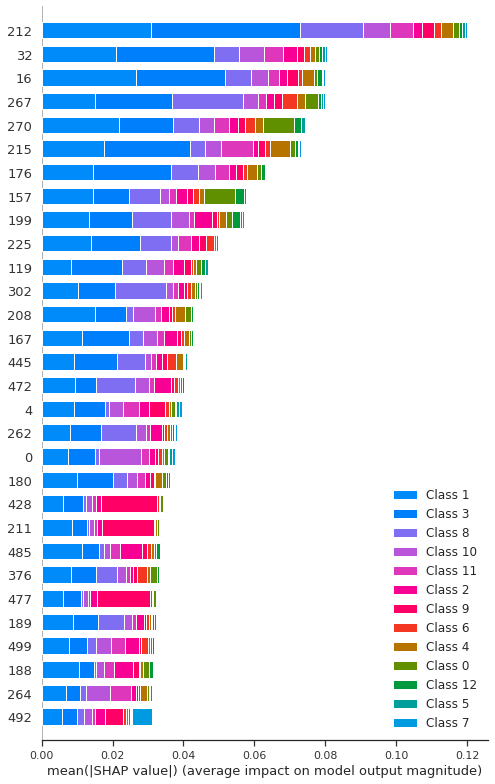

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                16032     
_________________________________________________________________
batch_normalization_4 (Batch (None, 32)                128       
_________________________________________________________________
activation_4 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_5 (Batch (None, 16)                64        
_________________________________________________________________
activation_5 (Activation)    (None

69/69 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.7859 - auc: 0.9846 - precision: 0.9252 - recall: 0.4503 - val_loss: 0.6750 - val_accuracy: 0.8608 - val_auc: 0.9932 - val_precision: 0.9591 - val_recall: 0.5708

Epoch 00019: val_loss improved from 0.69364 to 0.67500, saving model to weights/best_model_annotation.h5
Epoch 20/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6001 - accuracy: 0.7777 - auc: 0.9844 - precision: 0.9239 - recall: 0.4806 - val_loss: 0.6611 - val_accuracy: 0.8677 - val_auc: 0.9934 - val_precision: 0.9495 - val_recall: 0.5783

Epoch 00020: val_loss improved from 0.67500 to 0.66111, saving model to weights/best_model_annotation.h5
Epoch 21/100
69/69 [==============================] - 0s 3ms/step - loss: 0.5779 - accuracy: 0.7953 - auc: 0.9866 - precision: 0.9256 - recall: 0.5217 - val_loss: 0.6105 - val_accuracy: 0.8718 - val_auc: 0.9940 - val_precision: 0.9520 - val_recall: 0.6439

Epoch 00021: val_loss improved f

69/69 [==============================] - 0s 3ms/step - loss: 0.2287 - accuracy: 0.9022 - auc: 0.9963 - precision: 0.9357 - recall: 0.8532 - val_loss: 0.2960 - val_accuracy: 0.9095 - val_auc: 0.9966 - val_precision: 0.9237 - val_recall: 0.8852

Epoch 00043: val_loss did not improve from 0.26261
Epoch 44/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2053 - accuracy: 0.9053 - auc: 0.9965 - precision: 0.9386 - recall: 0.8567 - val_loss: 0.2530 - val_accuracy: 0.9298 - val_auc: 0.9973 - val_precision: 0.9402 - val_recall: 0.9113

Epoch 00044: val_loss improved from 0.26261 to 0.25305, saving model to weights/best_model_annotation.h5
Epoch 45/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2140 - accuracy: 0.9072 - auc: 0.9966 - precision: 0.9366 - recall: 0.8580 - val_loss: 0.2908 - val_accuracy: 0.9014 - val_auc: 0.9965 - val_precision: 0.9117 - val_recall: 0.8869

Epoch 00045: val_loss did not improve from 0.25305
Epoch 46/100
69/69 [===============

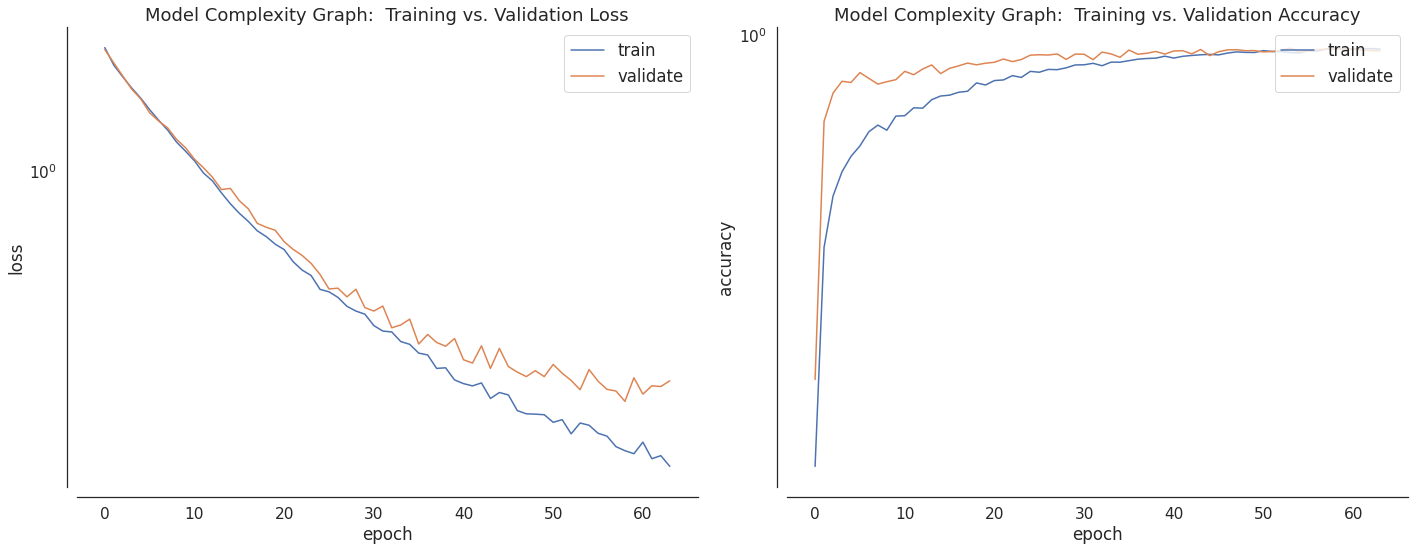

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

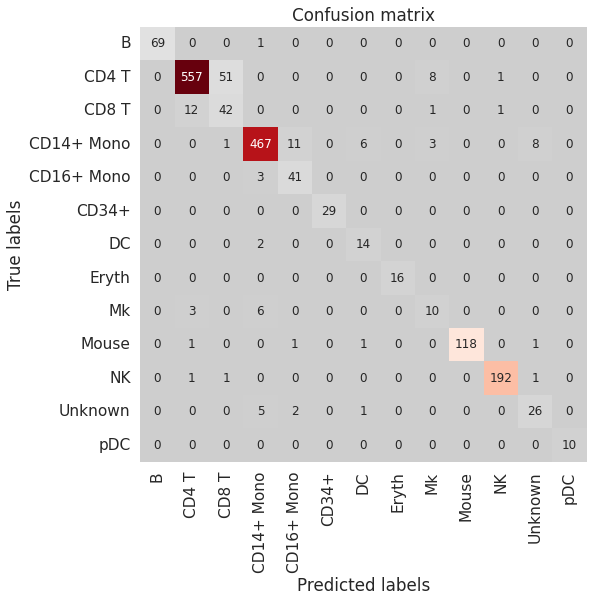

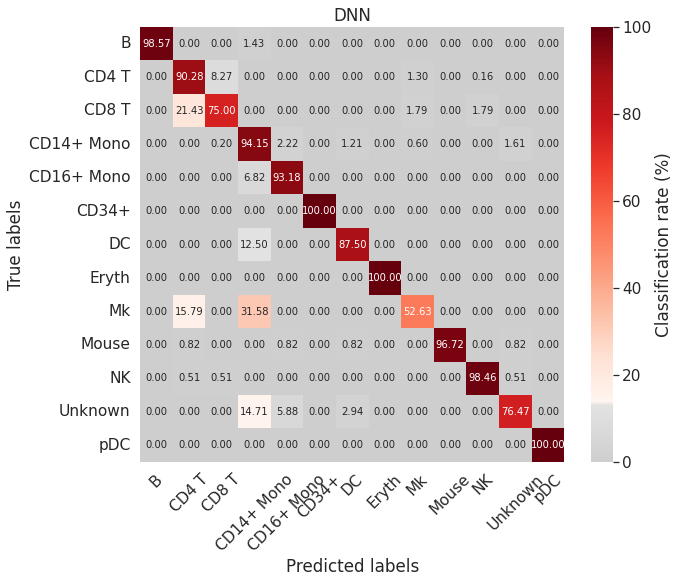

              precision    recall  f1-score   support

           B       1.00      0.99      0.99        70
       CD4 T       0.97      0.90      0.94       617
       CD8 T       0.44      0.75      0.56        56
  CD14+ Mono       0.96      0.94      0.95       496
  CD16+ Mono       0.75      0.93      0.83        44
       CD34+       1.00      1.00      1.00        29
          DC       0.64      0.88      0.74        16
       Eryth       1.00      1.00      1.00        16
          Mk       0.45      0.53      0.49        19
       Mouse       1.00      0.97      0.98       122
          NK       0.99      0.98      0.99       195
     Unknown       0.72      0.76      0.74        34
         pDC       1.00      1.00      1.00        10

    accuracy                           0.92      1724
   macro avg       0.84      0.89      0.86      1724
weighted avg       0.94      0.92      0.93      1724

54/54 [==============================] - 0s 1ms/step - loss: 0.2013 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


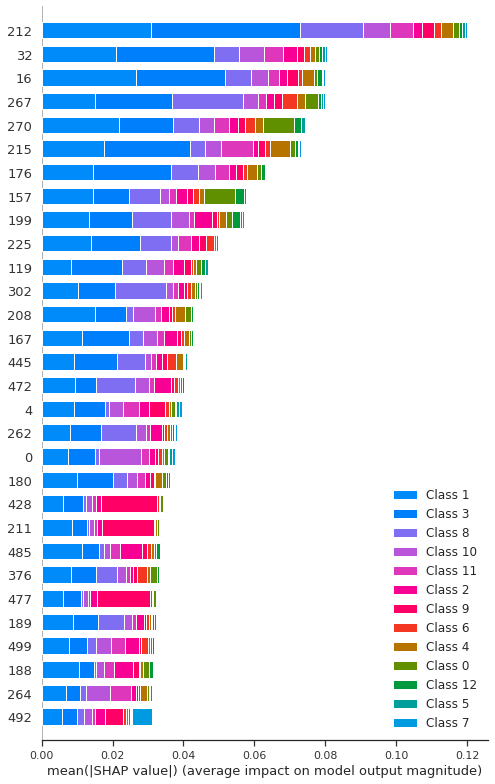

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_8 (Batch (None, 32)                128       
_________________________________________________________________
activation_8 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_9 (Batch (None, 16)                64        
_________________________________________________________________
activation_9 (Activation)    (None

69/69 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.7859 - auc: 0.9846 - precision: 0.9252 - recall: 0.4503 - val_loss: 0.6750 - val_accuracy: 0.8608 - val_auc: 0.9932 - val_precision: 0.9591 - val_recall: 0.5708

Epoch 00019: val_loss improved from 0.69364 to 0.67500, saving model to weights/best_model_annotation.h5
Epoch 20/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6001 - accuracy: 0.7777 - auc: 0.9844 - precision: 0.9239 - recall: 0.4806 - val_loss: 0.6611 - val_accuracy: 0.8677 - val_auc: 0.9934 - val_precision: 0.9495 - val_recall: 0.5783

Epoch 00020: val_loss improved from 0.67500 to 0.66111, saving model to weights/best_model_annotation.h5
Epoch 21/100
69/69 [==============================] - 0s 3ms/step - loss: 0.5779 - accuracy: 0.7953 - auc: 0.9866 - precision: 0.9256 - recall: 0.5217 - val_loss: 0.6105 - val_accuracy: 0.8718 - val_auc: 0.9940 - val_precision: 0.9520 - val_recall: 0.6439

Epoch 00021: val_loss improved f

69/69 [==============================] - 0s 3ms/step - loss: 0.2287 - accuracy: 0.9022 - auc: 0.9963 - precision: 0.9357 - recall: 0.8532 - val_loss: 0.2960 - val_accuracy: 0.9095 - val_auc: 0.9966 - val_precision: 0.9237 - val_recall: 0.8852

Epoch 00043: val_loss did not improve from 0.26261
Epoch 44/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2053 - accuracy: 0.9053 - auc: 0.9965 - precision: 0.9386 - recall: 0.8567 - val_loss: 0.2530 - val_accuracy: 0.9298 - val_auc: 0.9973 - val_precision: 0.9402 - val_recall: 0.9113

Epoch 00044: val_loss improved from 0.26261 to 0.25305, saving model to weights/best_model_annotation.h5
Epoch 45/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2140 - accuracy: 0.9072 - auc: 0.9966 - precision: 0.9366 - recall: 0.8580 - val_loss: 0.2908 - val_accuracy: 0.9014 - val_auc: 0.9965 - val_precision: 0.9117 - val_recall: 0.8869

Epoch 00045: val_loss did not improve from 0.25305
Epoch 46/100
69/69 [===============

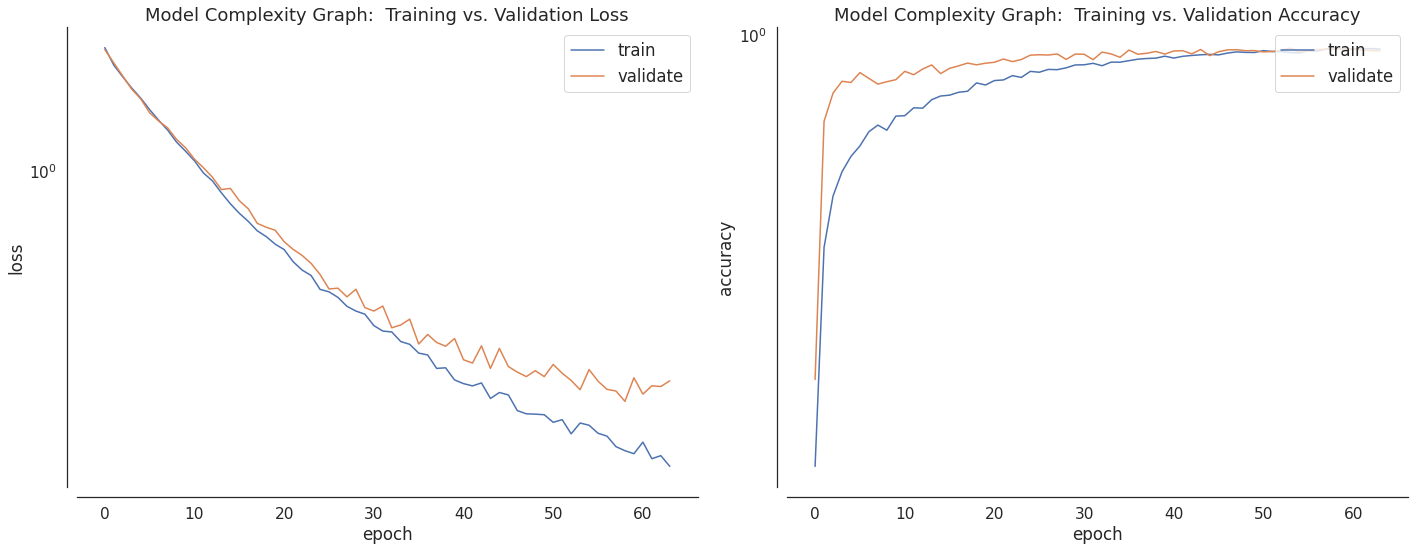

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

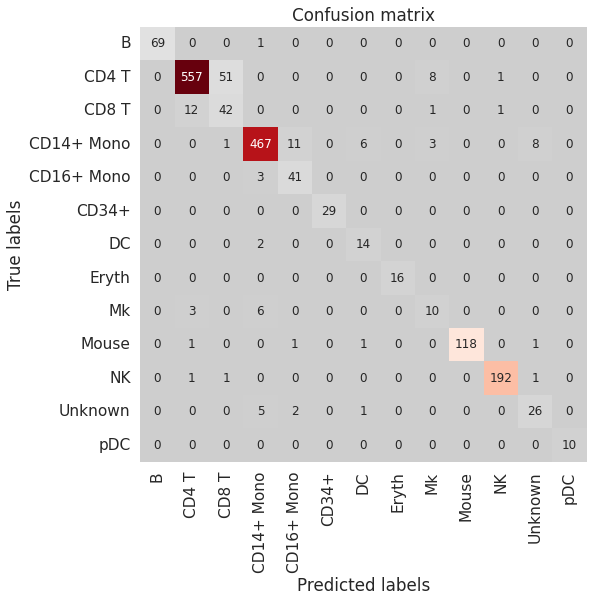

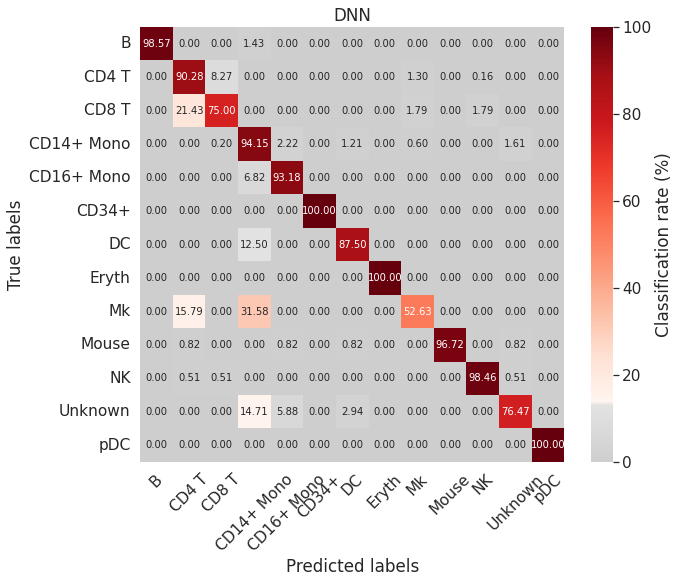

              precision    recall  f1-score   support

           B       1.00      0.99      0.99        70
       CD4 T       0.97      0.90      0.94       617
       CD8 T       0.44      0.75      0.56        56
  CD14+ Mono       0.96      0.94      0.95       496
  CD16+ Mono       0.75      0.93      0.83        44
       CD34+       1.00      1.00      1.00        29
          DC       0.64      0.88      0.74        16
       Eryth       1.00      1.00      1.00        16
          Mk       0.45      0.53      0.49        19
       Mouse       1.00      0.97      0.98       122
          NK       0.99      0.98      0.99       195
     Unknown       0.72      0.76      0.74        34
         pDC       1.00      1.00      1.00        10

    accuracy                           0.92      1724
   macro avg       0.84      0.89      0.86      1724
weighted avg       0.94      0.92      0.93      1724

54/54 [==============================] - 0s 1ms/step - loss: 0.2013 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


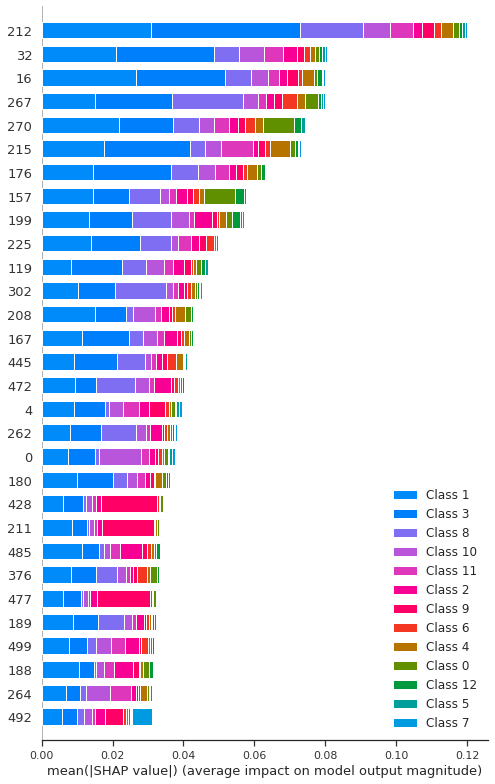

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_12 (Batc (None, 32)                128       
_________________________________________________________________
activation_12 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_13 (Batc (None, 16)                64        
_________________________________________________________________
activation_13 (Activation)   (None

69/69 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.7859 - auc: 0.9846 - precision: 0.9252 - recall: 0.4503 - val_loss: 0.6750 - val_accuracy: 0.8608 - val_auc: 0.9932 - val_precision: 0.9591 - val_recall: 0.5708

Epoch 00019: val_loss improved from 0.69364 to 0.67500, saving model to weights/best_model_annotation.h5
Epoch 20/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6001 - accuracy: 0.7777 - auc: 0.9844 - precision: 0.9239 - recall: 0.4806 - val_loss: 0.6611 - val_accuracy: 0.8677 - val_auc: 0.9934 - val_precision: 0.9495 - val_recall: 0.5783

Epoch 00020: val_loss improved from 0.67500 to 0.66111, saving model to weights/best_model_annotation.h5
Epoch 21/100
69/69 [==============================] - 0s 3ms/step - loss: 0.5779 - accuracy: 0.7953 - auc: 0.9866 - precision: 0.9256 - recall: 0.5217 - val_loss: 0.6105 - val_accuracy: 0.8718 - val_auc: 0.9940 - val_precision: 0.9520 - val_recall: 0.6439

Epoch 00021: val_loss improved f

69/69 [==============================] - 0s 3ms/step - loss: 0.2287 - accuracy: 0.9022 - auc: 0.9963 - precision: 0.9357 - recall: 0.8532 - val_loss: 0.2960 - val_accuracy: 0.9095 - val_auc: 0.9966 - val_precision: 0.9237 - val_recall: 0.8852

Epoch 00043: val_loss did not improve from 0.26261
Epoch 44/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2053 - accuracy: 0.9053 - auc: 0.9965 - precision: 0.9386 - recall: 0.8567 - val_loss: 0.2530 - val_accuracy: 0.9298 - val_auc: 0.9973 - val_precision: 0.9402 - val_recall: 0.9113

Epoch 00044: val_loss improved from 0.26261 to 0.25305, saving model to weights/best_model_annotation.h5
Epoch 45/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2140 - accuracy: 0.9072 - auc: 0.9966 - precision: 0.9366 - recall: 0.8580 - val_loss: 0.2908 - val_accuracy: 0.9014 - val_auc: 0.9965 - val_precision: 0.9117 - val_recall: 0.8869

Epoch 00045: val_loss did not improve from 0.25305
Epoch 46/100
69/69 [===============

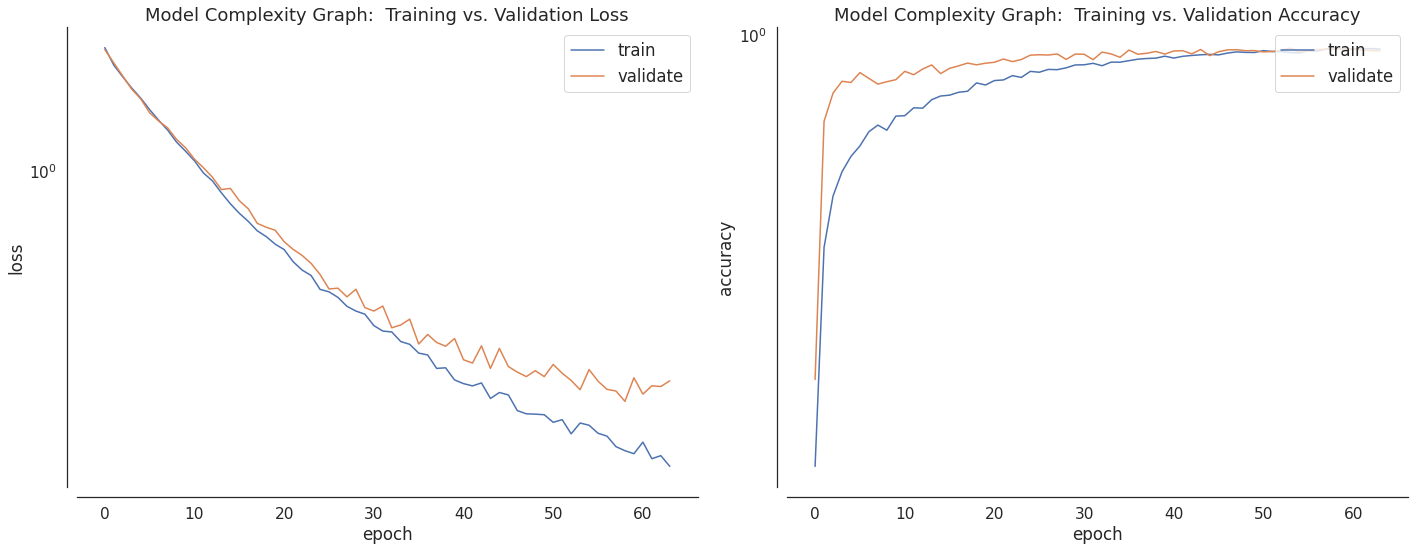

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

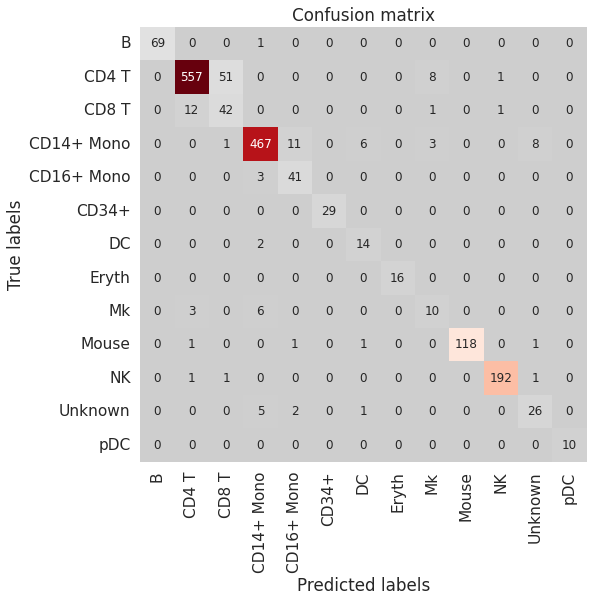

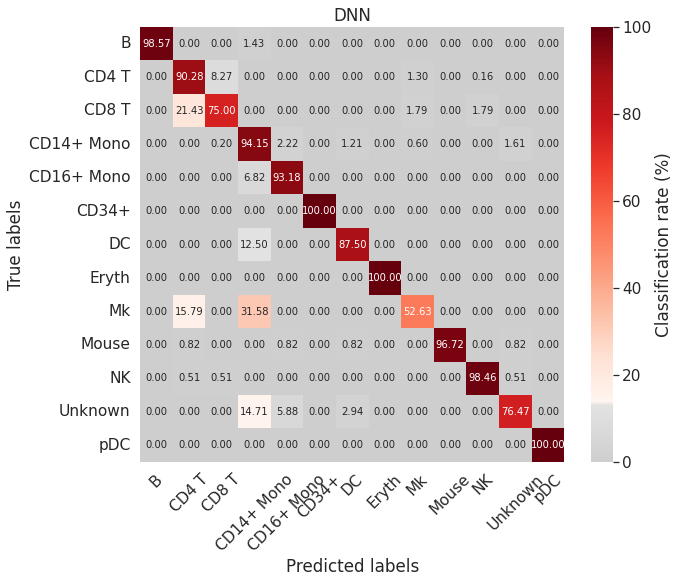

              precision    recall  f1-score   support

           B       1.00      0.99      0.99        70
       CD4 T       0.97      0.90      0.94       617
       CD8 T       0.44      0.75      0.56        56
  CD14+ Mono       0.96      0.94      0.95       496
  CD16+ Mono       0.75      0.93      0.83        44
       CD34+       1.00      1.00      1.00        29
          DC       0.64      0.88      0.74        16
       Eryth       1.00      1.00      1.00        16
          Mk       0.45      0.53      0.49        19
       Mouse       1.00      0.97      0.98       122
          NK       0.99      0.98      0.99       195
     Unknown       0.72      0.76      0.74        34
         pDC       1.00      1.00      1.00        10

    accuracy                           0.92      1724
   macro avg       0.84      0.89      0.86      1724
weighted avg       0.94      0.92      0.93      1724

54/54 [==============================] - 0s 1ms/step - loss: 0.2013 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


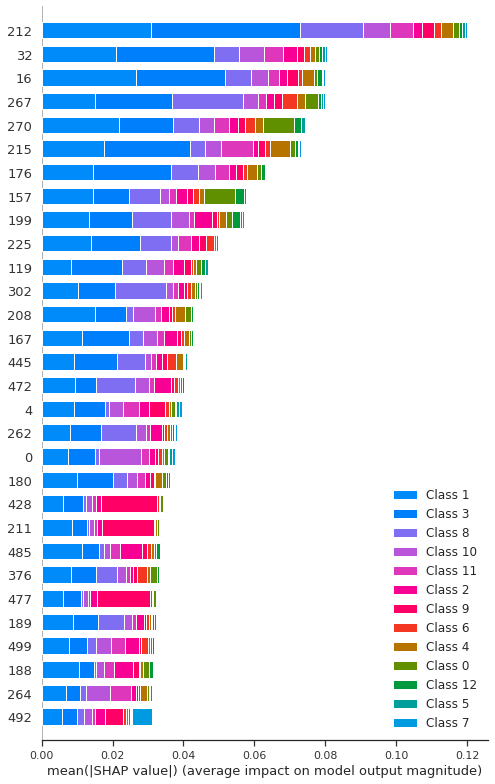

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_16 (Batc (None, 32)                128       
_________________________________________________________________
activation_16 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_17 (Batc (None, 16)                64        
_________________________________________________________________
activation_17 (Activation)   (None

69/69 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.7859 - auc: 0.9846 - precision: 0.9252 - recall: 0.4503 - val_loss: 0.6750 - val_accuracy: 0.8608 - val_auc: 0.9932 - val_precision: 0.9591 - val_recall: 0.5708

Epoch 00019: val_loss improved from 0.69364 to 0.67500, saving model to weights/best_model_annotation.h5
Epoch 20/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6001 - accuracy: 0.7777 - auc: 0.9844 - precision: 0.9239 - recall: 0.4806 - val_loss: 0.6611 - val_accuracy: 0.8677 - val_auc: 0.9934 - val_precision: 0.9495 - val_recall: 0.5783

Epoch 00020: val_loss improved from 0.67500 to 0.66111, saving model to weights/best_model_annotation.h5
Epoch 21/100
69/69 [==============================] - 0s 3ms/step - loss: 0.5779 - accuracy: 0.7953 - auc: 0.9866 - precision: 0.9256 - recall: 0.5217 - val_loss: 0.6105 - val_accuracy: 0.8718 - val_auc: 0.9940 - val_precision: 0.9520 - val_recall: 0.6439

Epoch 00021: val_loss improved f

69/69 [==============================] - 0s 3ms/step - loss: 0.2287 - accuracy: 0.9022 - auc: 0.9963 - precision: 0.9357 - recall: 0.8532 - val_loss: 0.2960 - val_accuracy: 0.9095 - val_auc: 0.9966 - val_precision: 0.9237 - val_recall: 0.8852

Epoch 00043: val_loss did not improve from 0.26261
Epoch 44/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2053 - accuracy: 0.9053 - auc: 0.9965 - precision: 0.9386 - recall: 0.8567 - val_loss: 0.2530 - val_accuracy: 0.9298 - val_auc: 0.9973 - val_precision: 0.9402 - val_recall: 0.9113

Epoch 00044: val_loss improved from 0.26261 to 0.25305, saving model to weights/best_model_annotation.h5
Epoch 45/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2140 - accuracy: 0.9072 - auc: 0.9966 - precision: 0.9366 - recall: 0.8580 - val_loss: 0.2908 - val_accuracy: 0.9014 - val_auc: 0.9965 - val_precision: 0.9117 - val_recall: 0.8869

Epoch 00045: val_loss did not improve from 0.25305
Epoch 46/100
69/69 [===============

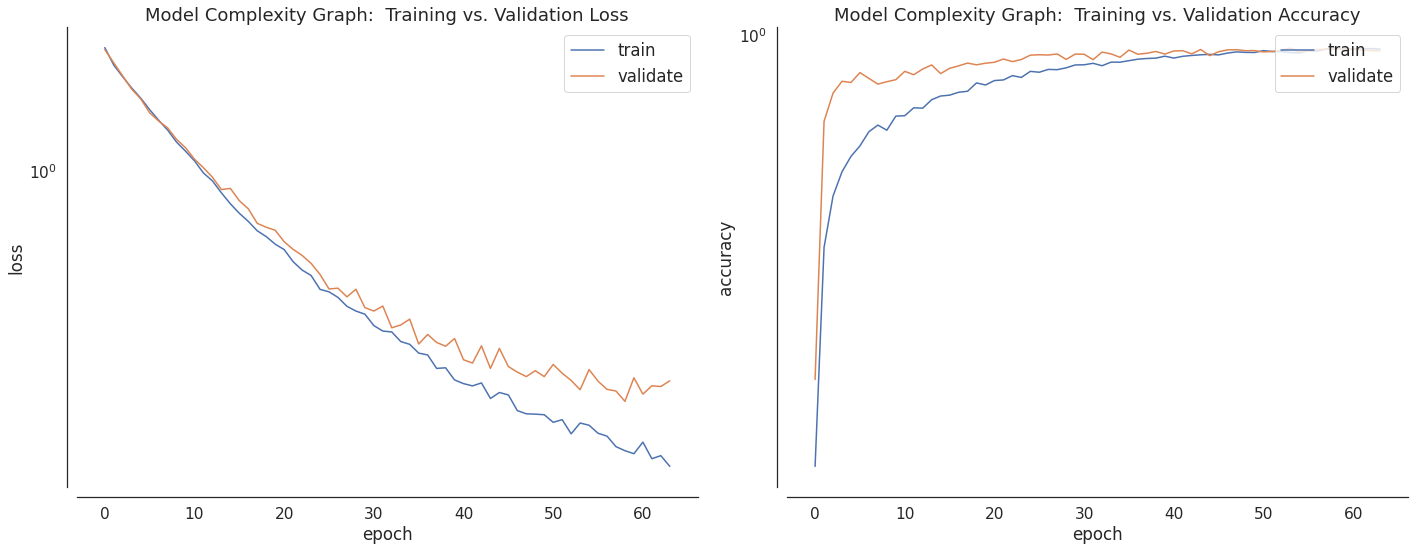

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

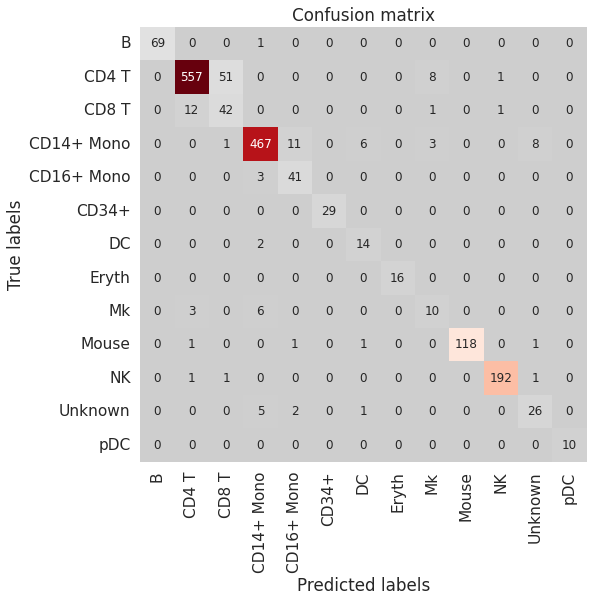

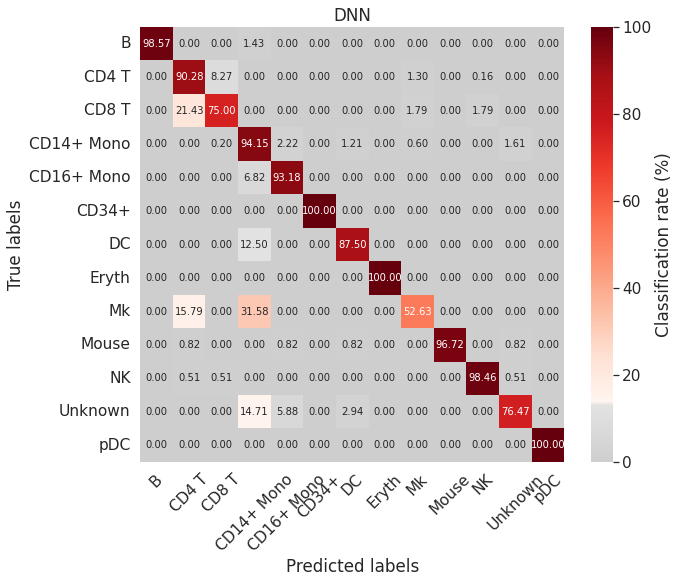

              precision    recall  f1-score   support

           B       1.00      0.99      0.99        70
       CD4 T       0.97      0.90      0.94       617
       CD8 T       0.44      0.75      0.56        56
  CD14+ Mono       0.96      0.94      0.95       496
  CD16+ Mono       0.75      0.93      0.83        44
       CD34+       1.00      1.00      1.00        29
          DC       0.64      0.88      0.74        16
       Eryth       1.00      1.00      1.00        16
          Mk       0.45      0.53      0.49        19
       Mouse       1.00      0.97      0.98       122
          NK       0.99      0.98      0.99       195
     Unknown       0.72      0.76      0.74        34
         pDC       1.00      1.00      1.00        10

    accuracy                           0.92      1724
   macro avg       0.84      0.89      0.86      1724
weighted avg       0.94      0.92      0.93      1724

54/54 [==============================] - 0s 1ms/step - loss: 0.2013 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


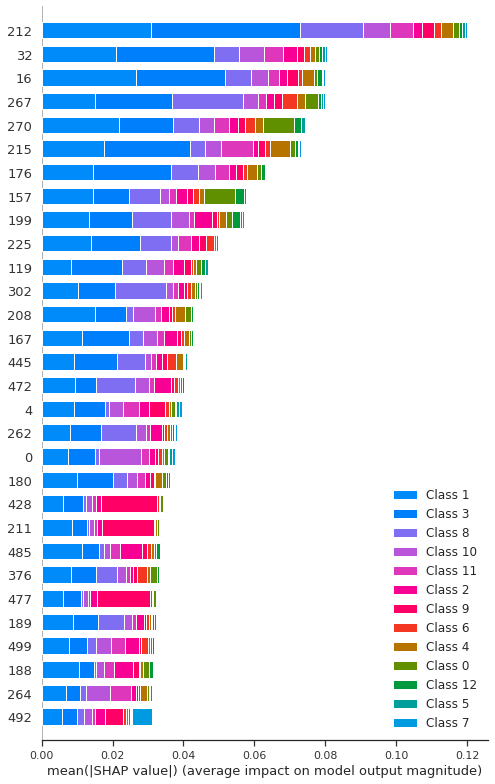

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


CPU times: user 7min 23s, sys: 14.7 s, total: 7min 38s
Wall time: 3min 45s


In [18]:
%%time
for k in k_range:
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = citeseq_adata[np.concatenate([train_indices, val_indices]), :]
    sm = smashpy.smashpy()
    sm.DNN(citeseq_adata, group_by="annotation", model=None, balance=True, verbose=True, save=False)
    selectedGenes, selectedGenes_dict = sm.run_shap(citeseq_adata, group_by="annotation", model=None, verbose=True, pct=0.1, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = citeseq_adata.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'smash_markers_k_{}.npy'.format(k), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Smash Marker Visualization', path = viz_save_path + 'smash_markers_k_{}.png'.format(k), markers = smash_markers)

 * Initialising ...
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_20 (Batc (None, 32)                128       
_________________________________________________________________
activation_20 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_21 (Batc (None, 16)                64        
_________________________________________________________________
activation_21 (Activation)   (Non

69/69 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.7859 - auc: 0.9846 - precision: 0.9252 - recall: 0.4503 - val_loss: 0.6750 - val_accuracy: 0.8608 - val_auc: 0.9932 - val_precision: 0.9591 - val_recall: 0.5708

Epoch 00019: val_loss improved from 0.69364 to 0.67500, saving model to weights/best_model_annotation.h5
Epoch 20/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6001 - accuracy: 0.7777 - auc: 0.9844 - precision: 0.9239 - recall: 0.4806 - val_loss: 0.6611 - val_accuracy: 0.8677 - val_auc: 0.9934 - val_precision: 0.9495 - val_recall: 0.5783

Epoch 00020: val_loss improved from 0.67500 to 0.66111, saving model to weights/best_model_annotation.h5
Epoch 21/100
69/69 [==============================] - 0s 3ms/step - loss: 0.5779 - accuracy: 0.7953 - auc: 0.9866 - precision: 0.9256 - recall: 0.5217 - val_loss: 0.6105 - val_accuracy: 0.8718 - val_auc: 0.9940 - val_precision: 0.9520 - val_recall: 0.6439

Epoch 00021: val_loss improved f

69/69 [==============================] - 0s 3ms/step - loss: 0.2287 - accuracy: 0.9022 - auc: 0.9963 - precision: 0.9357 - recall: 0.8532 - val_loss: 0.2960 - val_accuracy: 0.9095 - val_auc: 0.9966 - val_precision: 0.9237 - val_recall: 0.8852

Epoch 00043: val_loss did not improve from 0.26261
Epoch 44/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2053 - accuracy: 0.9053 - auc: 0.9965 - precision: 0.9386 - recall: 0.8567 - val_loss: 0.2530 - val_accuracy: 0.9298 - val_auc: 0.9973 - val_precision: 0.9402 - val_recall: 0.9113

Epoch 00044: val_loss improved from 0.26261 to 0.25305, saving model to weights/best_model_annotation.h5
Epoch 45/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2140 - accuracy: 0.9072 - auc: 0.9966 - precision: 0.9366 - recall: 0.8580 - val_loss: 0.2908 - val_accuracy: 0.9014 - val_auc: 0.9965 - val_precision: 0.9117 - val_recall: 0.8869

Epoch 00045: val_loss did not improve from 0.25305
Epoch 46/100
69/69 [===============

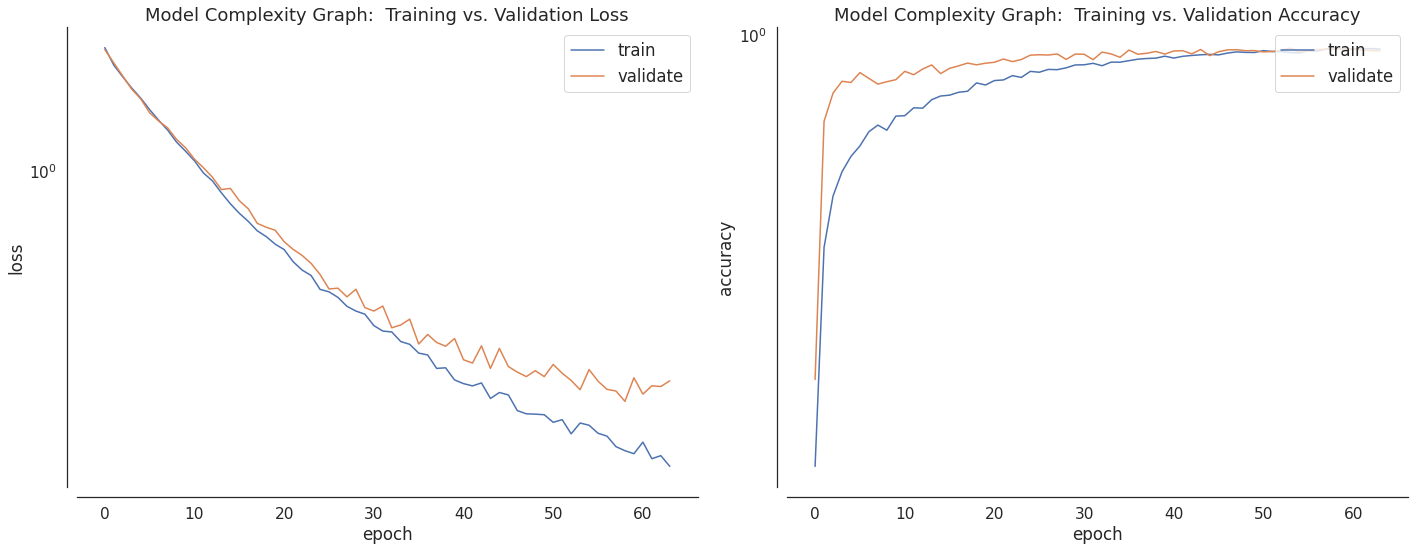

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

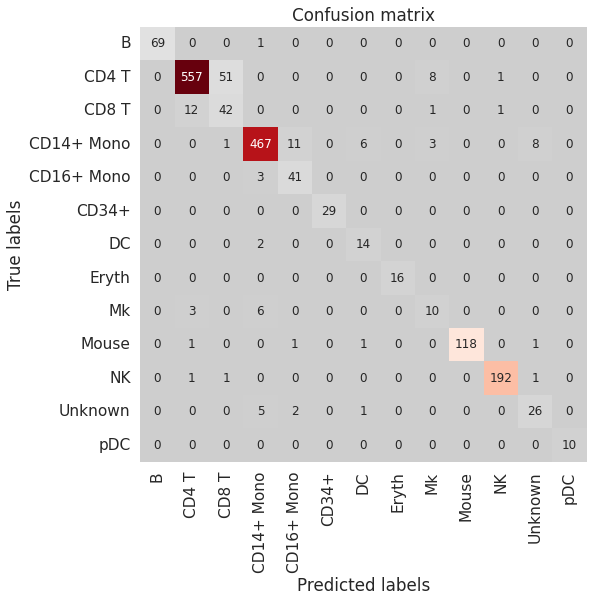

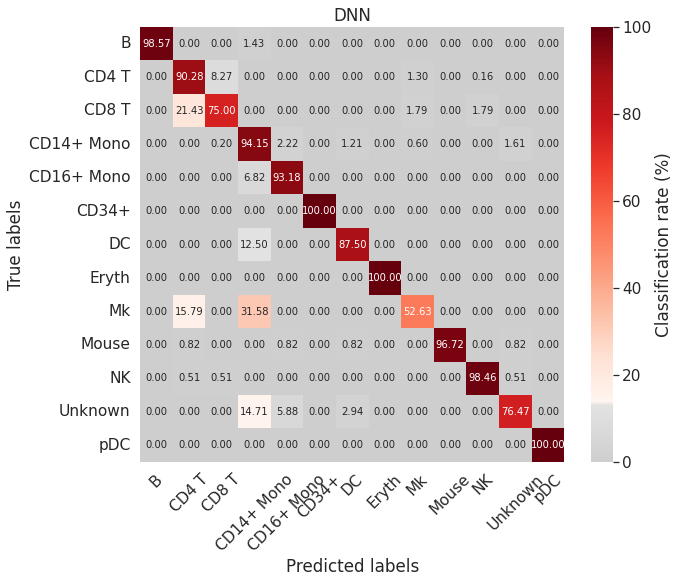

              precision    recall  f1-score   support

           B       1.00      0.99      0.99        70
       CD4 T       0.97      0.90      0.94       617
       CD8 T       0.44      0.75      0.56        56
  CD14+ Mono       0.96      0.94      0.95       496
  CD16+ Mono       0.75      0.93      0.83        44
       CD34+       1.00      1.00      1.00        29
          DC       0.64      0.88      0.74        16
       Eryth       1.00      1.00      1.00        16
          Mk       0.45      0.53      0.49        19
       Mouse       1.00      0.97      0.98       122
          NK       0.99      0.98      0.99       195
     Unknown       0.72      0.76      0.74        34
         pDC       1.00      1.00      1.00        10

    accuracy                           0.92      1724
   macro avg       0.84      0.89      0.86      1724
weighted avg       0.94      0.92      0.93      1724

54/54 [==============================] - 0s 1ms/step - loss: 0.2013 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


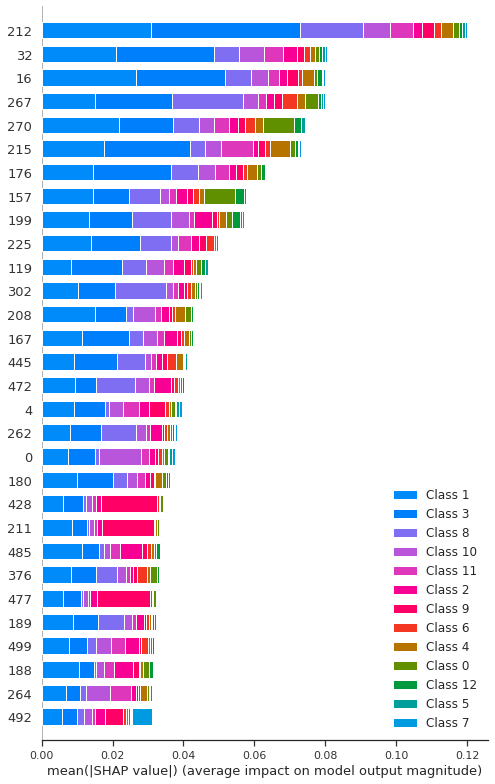

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_24 (Batc (None, 32)                128       
_________________________________________________________________
activation_24 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_25 (Batc (None, 16)                64        
_________________________________________________________________
activation_25 (Activation)   (Non

69/69 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.7859 - auc: 0.9846 - precision: 0.9252 - recall: 0.4503 - val_loss: 0.6750 - val_accuracy: 0.8608 - val_auc: 0.9932 - val_precision: 0.9591 - val_recall: 0.5708

Epoch 00019: val_loss improved from 0.69364 to 0.67500, saving model to weights/best_model_annotation.h5
Epoch 20/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6001 - accuracy: 0.7777 - auc: 0.9844 - precision: 0.9239 - recall: 0.4806 - val_loss: 0.6611 - val_accuracy: 0.8677 - val_auc: 0.9934 - val_precision: 0.9495 - val_recall: 0.5783

Epoch 00020: val_loss improved from 0.67500 to 0.66111, saving model to weights/best_model_annotation.h5
Epoch 21/100
69/69 [==============================] - 0s 3ms/step - loss: 0.5779 - accuracy: 0.7953 - auc: 0.9866 - precision: 0.9256 - recall: 0.5217 - val_loss: 0.6105 - val_accuracy: 0.8718 - val_auc: 0.9940 - val_precision: 0.9520 - val_recall: 0.6439

Epoch 00021: val_loss improved f

69/69 [==============================] - 0s 3ms/step - loss: 0.2287 - accuracy: 0.9022 - auc: 0.9963 - precision: 0.9357 - recall: 0.8532 - val_loss: 0.2960 - val_accuracy: 0.9095 - val_auc: 0.9966 - val_precision: 0.9237 - val_recall: 0.8852

Epoch 00043: val_loss did not improve from 0.26261
Epoch 44/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2053 - accuracy: 0.9053 - auc: 0.9965 - precision: 0.9386 - recall: 0.8567 - val_loss: 0.2530 - val_accuracy: 0.9298 - val_auc: 0.9973 - val_precision: 0.9402 - val_recall: 0.9113

Epoch 00044: val_loss improved from 0.26261 to 0.25305, saving model to weights/best_model_annotation.h5
Epoch 45/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2140 - accuracy: 0.9072 - auc: 0.9966 - precision: 0.9366 - recall: 0.8580 - val_loss: 0.2908 - val_accuracy: 0.9014 - val_auc: 0.9965 - val_precision: 0.9117 - val_recall: 0.8869

Epoch 00045: val_loss did not improve from 0.25305
Epoch 46/100
69/69 [===============

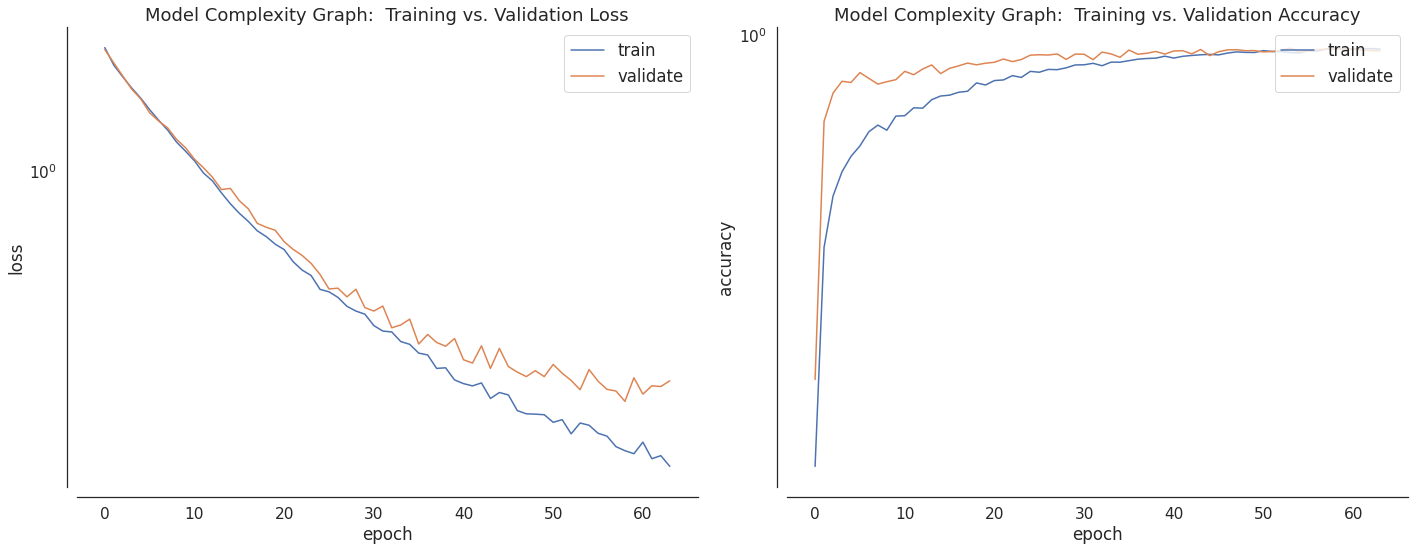

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

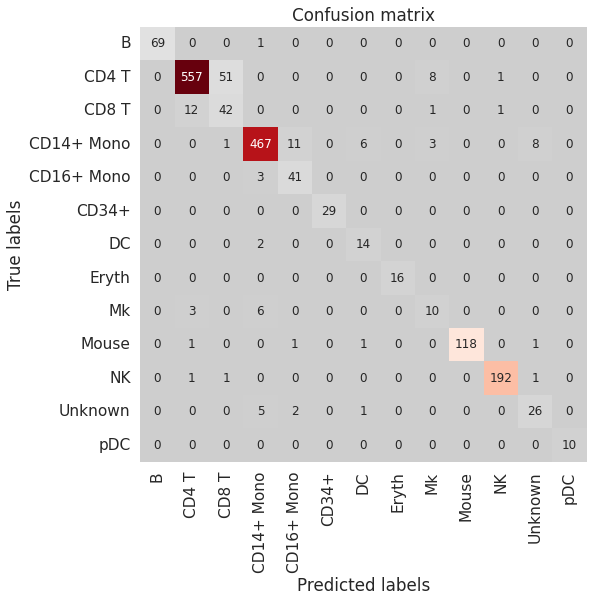

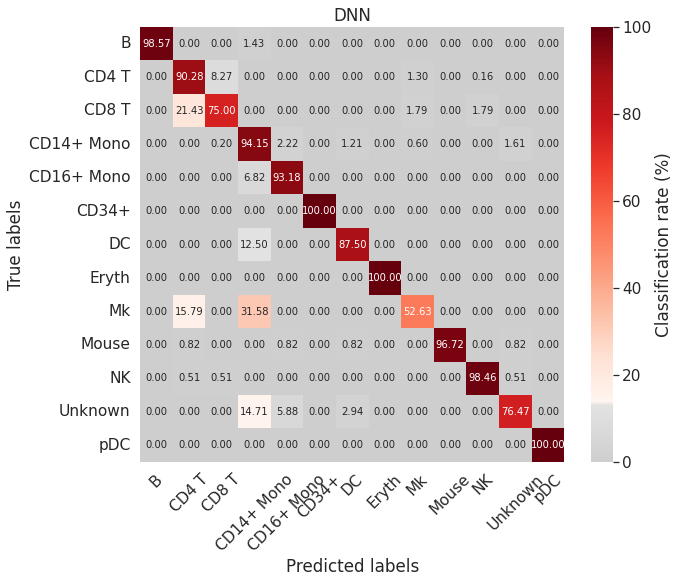

              precision    recall  f1-score   support

           B       1.00      0.99      0.99        70
       CD4 T       0.97      0.90      0.94       617
       CD8 T       0.44      0.75      0.56        56
  CD14+ Mono       0.96      0.94      0.95       496
  CD16+ Mono       0.75      0.93      0.83        44
       CD34+       1.00      1.00      1.00        29
          DC       0.64      0.88      0.74        16
       Eryth       1.00      1.00      1.00        16
          Mk       0.45      0.53      0.49        19
       Mouse       1.00      0.97      0.98       122
          NK       0.99      0.98      0.99       195
     Unknown       0.72      0.76      0.74        34
         pDC       1.00      1.00      1.00        10

    accuracy                           0.92      1724
   macro avg       0.84      0.89      0.86      1724
weighted avg       0.94      0.92      0.93      1724

54/54 [==============================] - 0s 1ms/step - loss: 0.2013 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


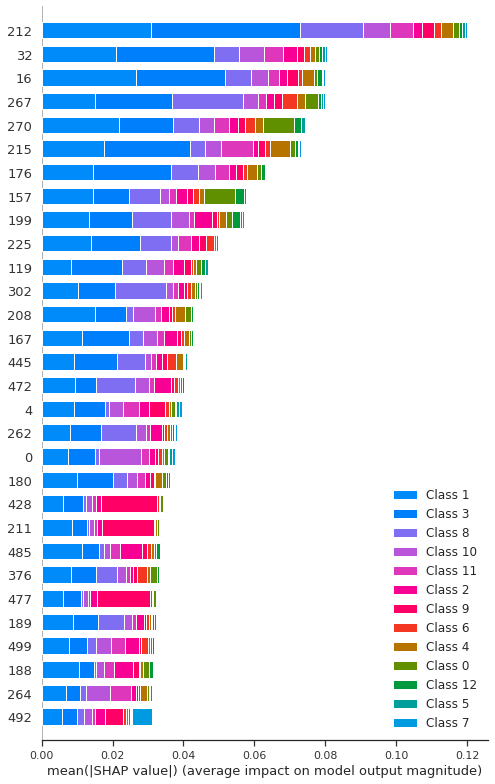

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_28 (Batc (None, 32)                128       
_________________________________________________________________
activation_28 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_29 (Batc (None, 16)                64        
_________________________________________________________________
activation_29 (Activation)   (Non

69/69 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.7859 - auc: 0.9846 - precision: 0.9252 - recall: 0.4503 - val_loss: 0.6750 - val_accuracy: 0.8608 - val_auc: 0.9932 - val_precision: 0.9591 - val_recall: 0.5708

Epoch 00019: val_loss improved from 0.69364 to 0.67500, saving model to weights/best_model_annotation.h5
Epoch 20/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6001 - accuracy: 0.7777 - auc: 0.9844 - precision: 0.9239 - recall: 0.4806 - val_loss: 0.6611 - val_accuracy: 0.8677 - val_auc: 0.9934 - val_precision: 0.9495 - val_recall: 0.5783

Epoch 00020: val_loss improved from 0.67500 to 0.66111, saving model to weights/best_model_annotation.h5
Epoch 21/100
69/69 [==============================] - 0s 3ms/step - loss: 0.5779 - accuracy: 0.7953 - auc: 0.9866 - precision: 0.9256 - recall: 0.5217 - val_loss: 0.6105 - val_accuracy: 0.8718 - val_auc: 0.9940 - val_precision: 0.9520 - val_recall: 0.6439

Epoch 00021: val_loss improved f

69/69 [==============================] - 0s 3ms/step - loss: 0.2287 - accuracy: 0.9022 - auc: 0.9963 - precision: 0.9357 - recall: 0.8532 - val_loss: 0.2960 - val_accuracy: 0.9095 - val_auc: 0.9966 - val_precision: 0.9237 - val_recall: 0.8852

Epoch 00043: val_loss did not improve from 0.26261
Epoch 44/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2053 - accuracy: 0.9053 - auc: 0.9965 - precision: 0.9386 - recall: 0.8567 - val_loss: 0.2530 - val_accuracy: 0.9298 - val_auc: 0.9973 - val_precision: 0.9402 - val_recall: 0.9113

Epoch 00044: val_loss improved from 0.26261 to 0.25305, saving model to weights/best_model_annotation.h5
Epoch 45/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2140 - accuracy: 0.9072 - auc: 0.9966 - precision: 0.9366 - recall: 0.8580 - val_loss: 0.2908 - val_accuracy: 0.9014 - val_auc: 0.9965 - val_precision: 0.9117 - val_recall: 0.8869

Epoch 00045: val_loss did not improve from 0.25305
Epoch 46/100
69/69 [===============

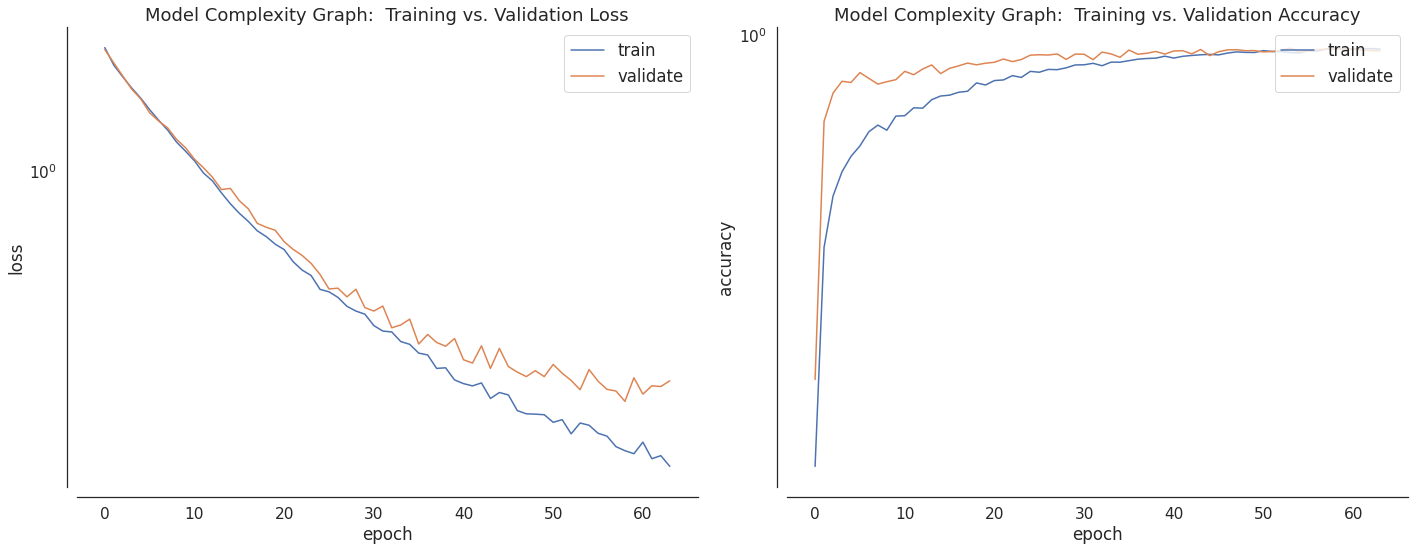

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

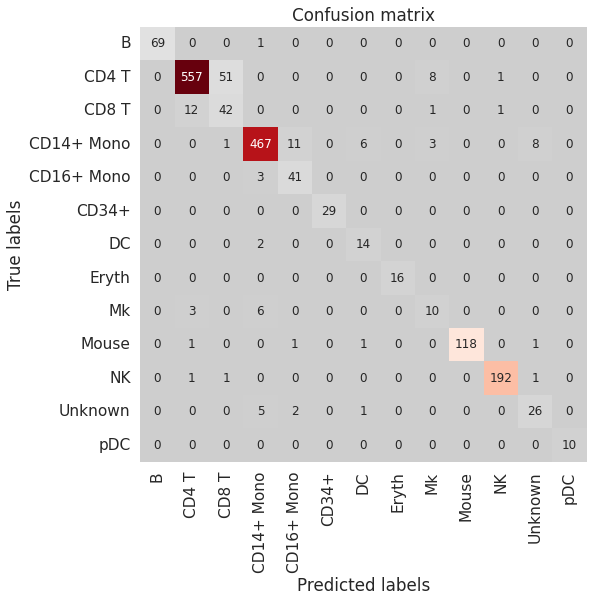

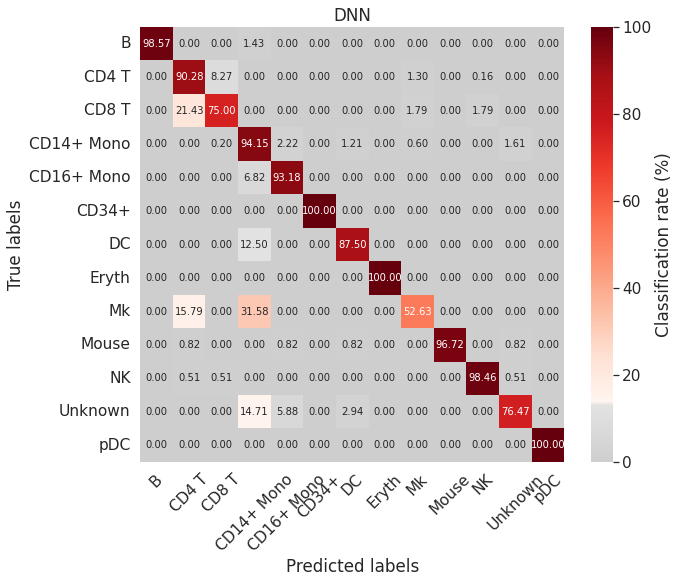

              precision    recall  f1-score   support

           B       1.00      0.99      0.99        70
       CD4 T       0.97      0.90      0.94       617
       CD8 T       0.44      0.75      0.56        56
  CD14+ Mono       0.96      0.94      0.95       496
  CD16+ Mono       0.75      0.93      0.83        44
       CD34+       1.00      1.00      1.00        29
          DC       0.64      0.88      0.74        16
       Eryth       1.00      1.00      1.00        16
          Mk       0.45      0.53      0.49        19
       Mouse       1.00      0.97      0.98       122
          NK       0.99      0.98      0.99       195
     Unknown       0.72      0.76      0.74        34
         pDC       1.00      1.00      1.00        10

    accuracy                           0.92      1724
   macro avg       0.84      0.89      0.86      1724
weighted avg       0.94      0.92      0.93      1724

54/54 [==============================] - 0s 1ms/step - loss: 0.2013 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


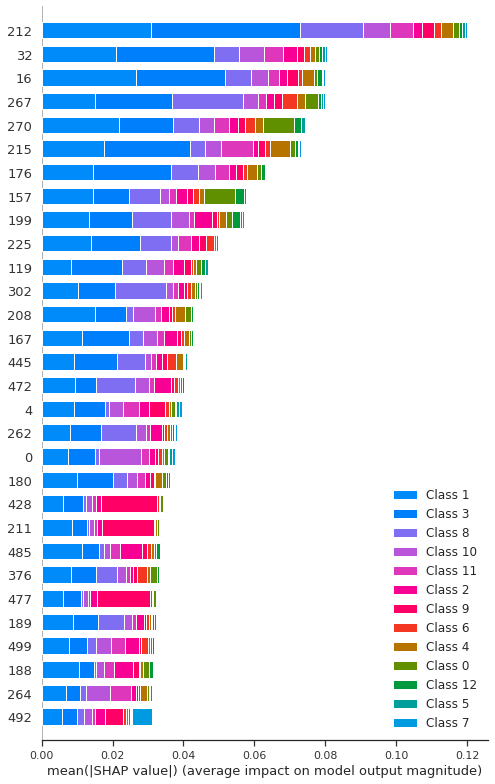

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_32 (Batc (None, 32)                128       
_________________________________________________________________
activation_32 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_33 (Batc (None, 16)                64        
_________________________________________________________________
activation_33 (Activation)   (Non

69/69 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.7859 - auc: 0.9846 - precision: 0.9252 - recall: 0.4503 - val_loss: 0.6750 - val_accuracy: 0.8608 - val_auc: 0.9932 - val_precision: 0.9591 - val_recall: 0.5708

Epoch 00019: val_loss improved from 0.69364 to 0.67500, saving model to weights/best_model_annotation.h5
Epoch 20/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6001 - accuracy: 0.7777 - auc: 0.9844 - precision: 0.9239 - recall: 0.4806 - val_loss: 0.6611 - val_accuracy: 0.8677 - val_auc: 0.9934 - val_precision: 0.9495 - val_recall: 0.5783

Epoch 00020: val_loss improved from 0.67500 to 0.66111, saving model to weights/best_model_annotation.h5
Epoch 21/100
69/69 [==============================] - 0s 3ms/step - loss: 0.5779 - accuracy: 0.7953 - auc: 0.9866 - precision: 0.9256 - recall: 0.5217 - val_loss: 0.6105 - val_accuracy: 0.8718 - val_auc: 0.9940 - val_precision: 0.9520 - val_recall: 0.6439

Epoch 00021: val_loss improved f

69/69 [==============================] - 0s 3ms/step - loss: 0.2287 - accuracy: 0.9022 - auc: 0.9963 - precision: 0.9357 - recall: 0.8532 - val_loss: 0.2960 - val_accuracy: 0.9095 - val_auc: 0.9966 - val_precision: 0.9237 - val_recall: 0.8852

Epoch 00043: val_loss did not improve from 0.26261
Epoch 44/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2053 - accuracy: 0.9053 - auc: 0.9965 - precision: 0.9386 - recall: 0.8567 - val_loss: 0.2530 - val_accuracy: 0.9298 - val_auc: 0.9973 - val_precision: 0.9402 - val_recall: 0.9113

Epoch 00044: val_loss improved from 0.26261 to 0.25305, saving model to weights/best_model_annotation.h5
Epoch 45/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2140 - accuracy: 0.9072 - auc: 0.9966 - precision: 0.9366 - recall: 0.8580 - val_loss: 0.2908 - val_accuracy: 0.9014 - val_auc: 0.9965 - val_precision: 0.9117 - val_recall: 0.8869

Epoch 00045: val_loss did not improve from 0.25305
Epoch 46/100
69/69 [===============

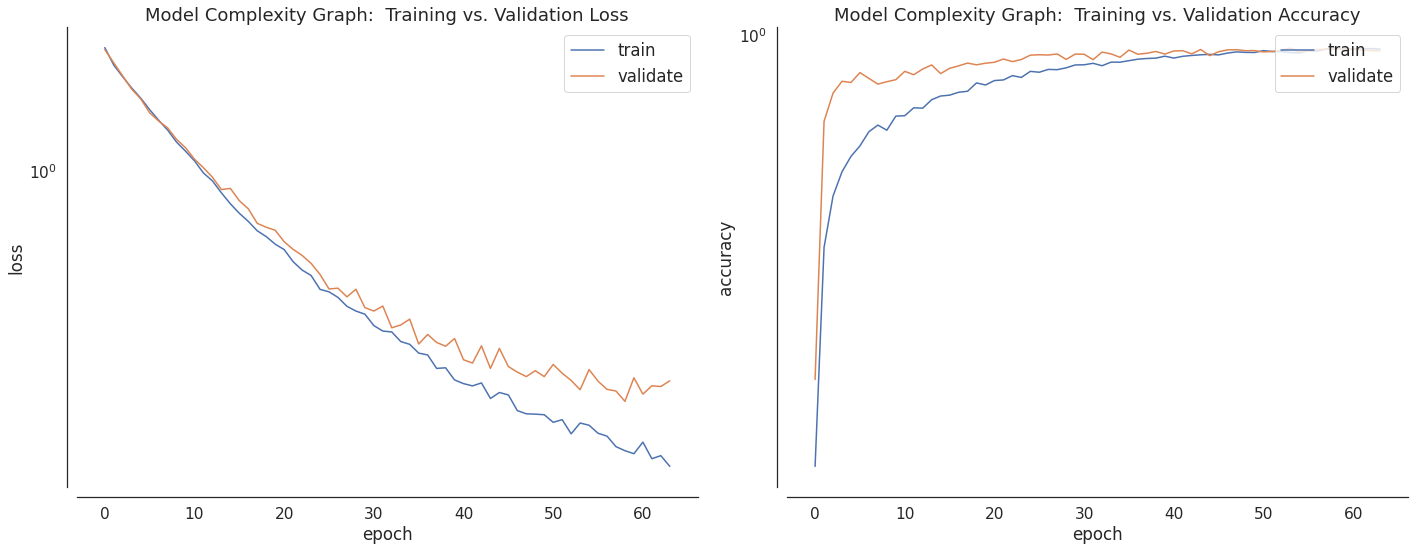

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

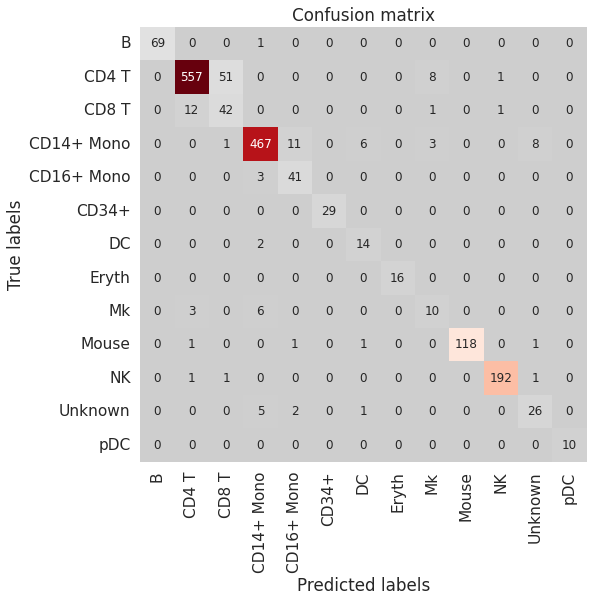

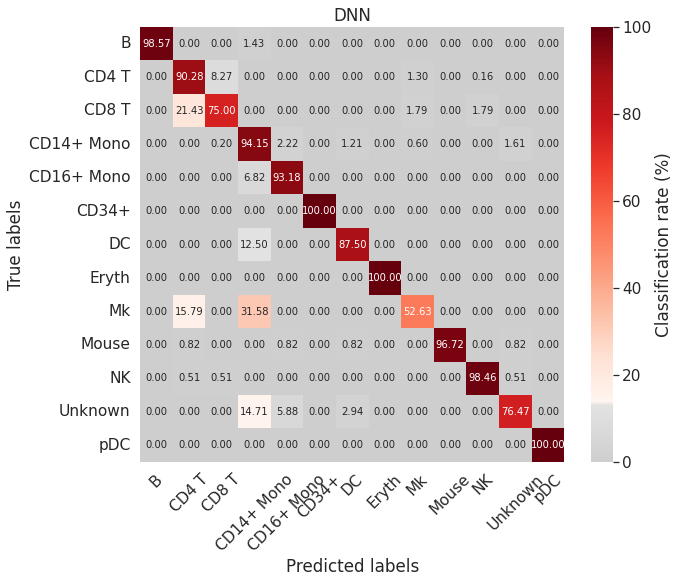

              precision    recall  f1-score   support

           B       1.00      0.99      0.99        70
       CD4 T       0.97      0.90      0.94       617
       CD8 T       0.44      0.75      0.56        56
  CD14+ Mono       0.96      0.94      0.95       496
  CD16+ Mono       0.75      0.93      0.83        44
       CD34+       1.00      1.00      1.00        29
          DC       0.64      0.88      0.74        16
       Eryth       1.00      1.00      1.00        16
          Mk       0.45      0.53      0.49        19
       Mouse       1.00      0.97      0.98       122
          NK       0.99      0.98      0.99       195
     Unknown       0.72      0.76      0.74        34
         pDC       1.00      1.00      1.00        10

    accuracy                           0.92      1724
   macro avg       0.84      0.89      0.86      1724
weighted avg       0.94      0.92      0.93      1724

54/54 [==============================] - 0s 1ms/step - loss: 0.2013 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


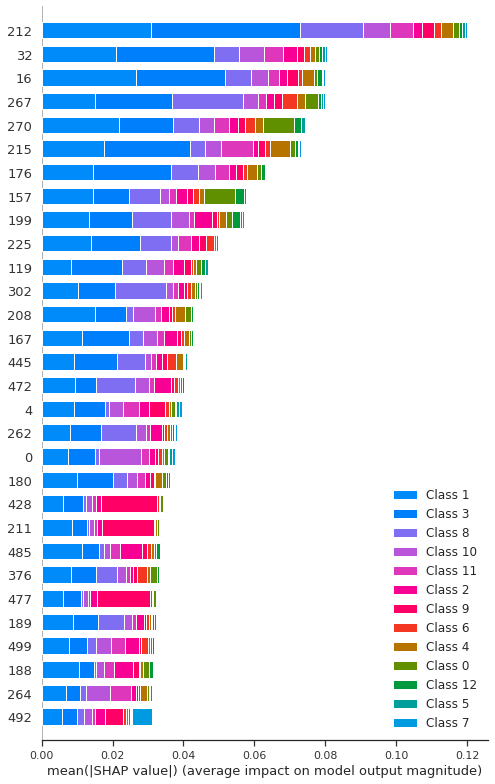

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_36 (Batc (None, 32)                128       
_________________________________________________________________
activation_36 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_37 (Batc (None, 16)                64        
_________________________________________________________________
activation_37 (Activation)   (Non

69/69 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.7859 - auc: 0.9846 - precision: 0.9252 - recall: 0.4503 - val_loss: 0.6750 - val_accuracy: 0.8608 - val_auc: 0.9932 - val_precision: 0.9591 - val_recall: 0.5708

Epoch 00019: val_loss improved from 0.69364 to 0.67500, saving model to weights/best_model_annotation.h5
Epoch 20/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6001 - accuracy: 0.7777 - auc: 0.9844 - precision: 0.9239 - recall: 0.4806 - val_loss: 0.6611 - val_accuracy: 0.8677 - val_auc: 0.9934 - val_precision: 0.9495 - val_recall: 0.5783

Epoch 00020: val_loss improved from 0.67500 to 0.66111, saving model to weights/best_model_annotation.h5
Epoch 21/100
69/69 [==============================] - 0s 3ms/step - loss: 0.5779 - accuracy: 0.7953 - auc: 0.9866 - precision: 0.9256 - recall: 0.5217 - val_loss: 0.6105 - val_accuracy: 0.8718 - val_auc: 0.9940 - val_precision: 0.9520 - val_recall: 0.6439

Epoch 00021: val_loss improved f

69/69 [==============================] - 0s 3ms/step - loss: 0.2287 - accuracy: 0.9022 - auc: 0.9963 - precision: 0.9357 - recall: 0.8532 - val_loss: 0.2960 - val_accuracy: 0.9095 - val_auc: 0.9966 - val_precision: 0.9237 - val_recall: 0.8852

Epoch 00043: val_loss did not improve from 0.26261
Epoch 44/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2053 - accuracy: 0.9053 - auc: 0.9965 - precision: 0.9386 - recall: 0.8567 - val_loss: 0.2530 - val_accuracy: 0.9298 - val_auc: 0.9973 - val_precision: 0.9402 - val_recall: 0.9113

Epoch 00044: val_loss improved from 0.26261 to 0.25305, saving model to weights/best_model_annotation.h5
Epoch 45/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2140 - accuracy: 0.9072 - auc: 0.9966 - precision: 0.9366 - recall: 0.8580 - val_loss: 0.2908 - val_accuracy: 0.9014 - val_auc: 0.9965 - val_precision: 0.9117 - val_recall: 0.8869

Epoch 00045: val_loss did not improve from 0.25305
Epoch 46/100
69/69 [===============

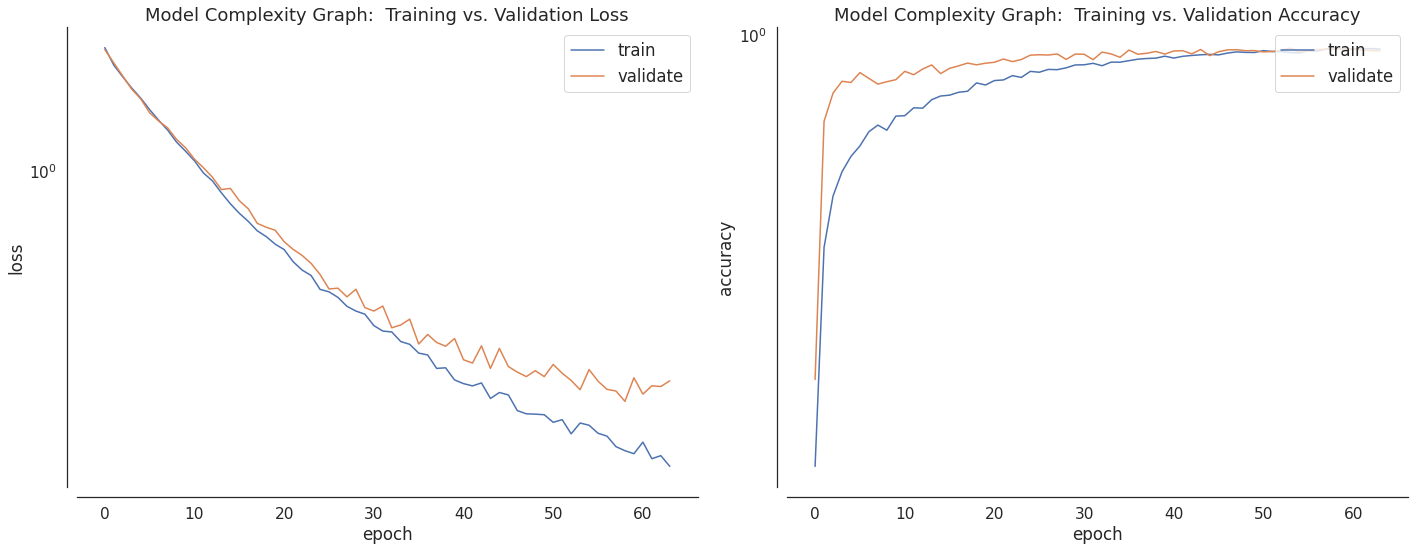

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

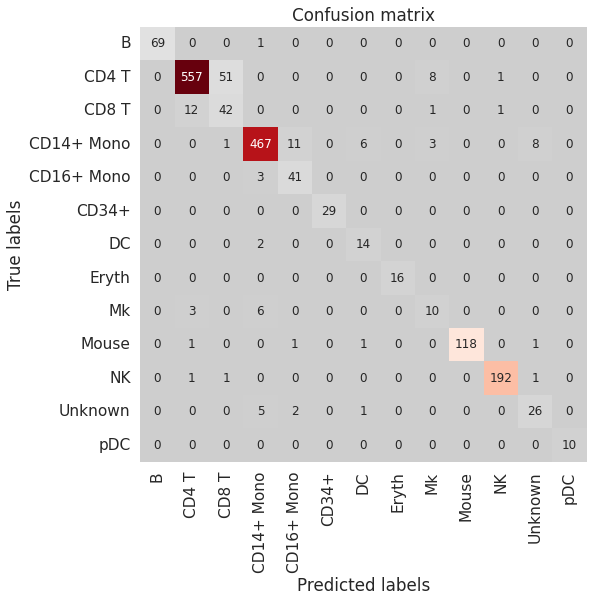

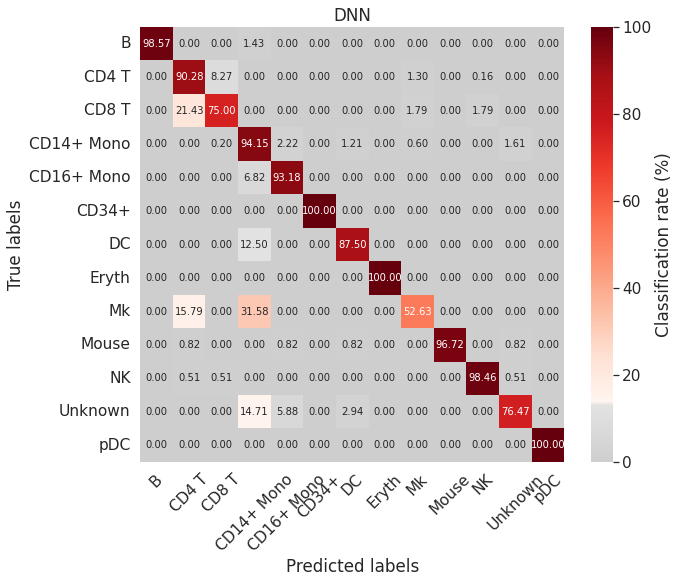

              precision    recall  f1-score   support

           B       1.00      0.99      0.99        70
       CD4 T       0.97      0.90      0.94       617
       CD8 T       0.44      0.75      0.56        56
  CD14+ Mono       0.96      0.94      0.95       496
  CD16+ Mono       0.75      0.93      0.83        44
       CD34+       1.00      1.00      1.00        29
          DC       0.64      0.88      0.74        16
       Eryth       1.00      1.00      1.00        16
          Mk       0.45      0.53      0.49        19
       Mouse       1.00      0.97      0.98       122
          NK       0.99      0.98      0.99       195
     Unknown       0.72      0.76      0.74        34
         pDC       1.00      1.00      1.00        10

    accuracy                           0.92      1724
   macro avg       0.84      0.89      0.86      1724
weighted avg       0.94      0.92      0.93      1724

54/54 [==============================] - 0s 1ms/step - loss: 0.2013 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


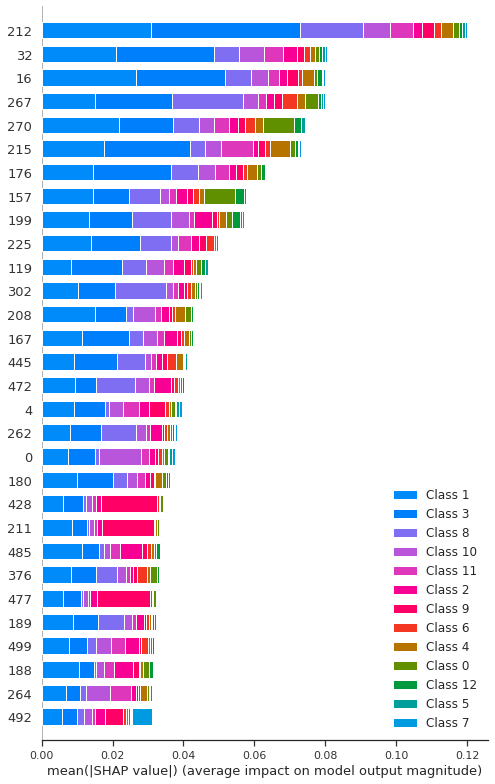

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_40 (Batc (None, 32)                128       
_________________________________________________________________
activation_40 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_61 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_41 (Batc (None, 16)                64        
_________________________________________________________________
activation_41 (Activation)   (Non

69/69 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.7859 - auc: 0.9846 - precision: 0.9252 - recall: 0.4503 - val_loss: 0.6750 - val_accuracy: 0.8608 - val_auc: 0.9932 - val_precision: 0.9591 - val_recall: 0.5708

Epoch 00019: val_loss improved from 0.69364 to 0.67500, saving model to weights/best_model_annotation.h5
Epoch 20/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6001 - accuracy: 0.7777 - auc: 0.9844 - precision: 0.9239 - recall: 0.4806 - val_loss: 0.6611 - val_accuracy: 0.8677 - val_auc: 0.9934 - val_precision: 0.9495 - val_recall: 0.5783

Epoch 00020: val_loss improved from 0.67500 to 0.66111, saving model to weights/best_model_annotation.h5
Epoch 21/100
69/69 [==============================] - 0s 3ms/step - loss: 0.5779 - accuracy: 0.7953 - auc: 0.9866 - precision: 0.9256 - recall: 0.5217 - val_loss: 0.6105 - val_accuracy: 0.8718 - val_auc: 0.9940 - val_precision: 0.9520 - val_recall: 0.6439

Epoch 00021: val_loss improved f

69/69 [==============================] - 0s 3ms/step - loss: 0.2287 - accuracy: 0.9022 - auc: 0.9963 - precision: 0.9357 - recall: 0.8532 - val_loss: 0.2960 - val_accuracy: 0.9095 - val_auc: 0.9966 - val_precision: 0.9237 - val_recall: 0.8852

Epoch 00043: val_loss did not improve from 0.26261
Epoch 44/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2053 - accuracy: 0.9053 - auc: 0.9965 - precision: 0.9386 - recall: 0.8567 - val_loss: 0.2530 - val_accuracy: 0.9298 - val_auc: 0.9973 - val_precision: 0.9402 - val_recall: 0.9113

Epoch 00044: val_loss improved from 0.26261 to 0.25305, saving model to weights/best_model_annotation.h5
Epoch 45/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2140 - accuracy: 0.9072 - auc: 0.9966 - precision: 0.9366 - recall: 0.8580 - val_loss: 0.2908 - val_accuracy: 0.9014 - val_auc: 0.9965 - val_precision: 0.9117 - val_recall: 0.8869

Epoch 00045: val_loss did not improve from 0.25305
Epoch 46/100
69/69 [===============

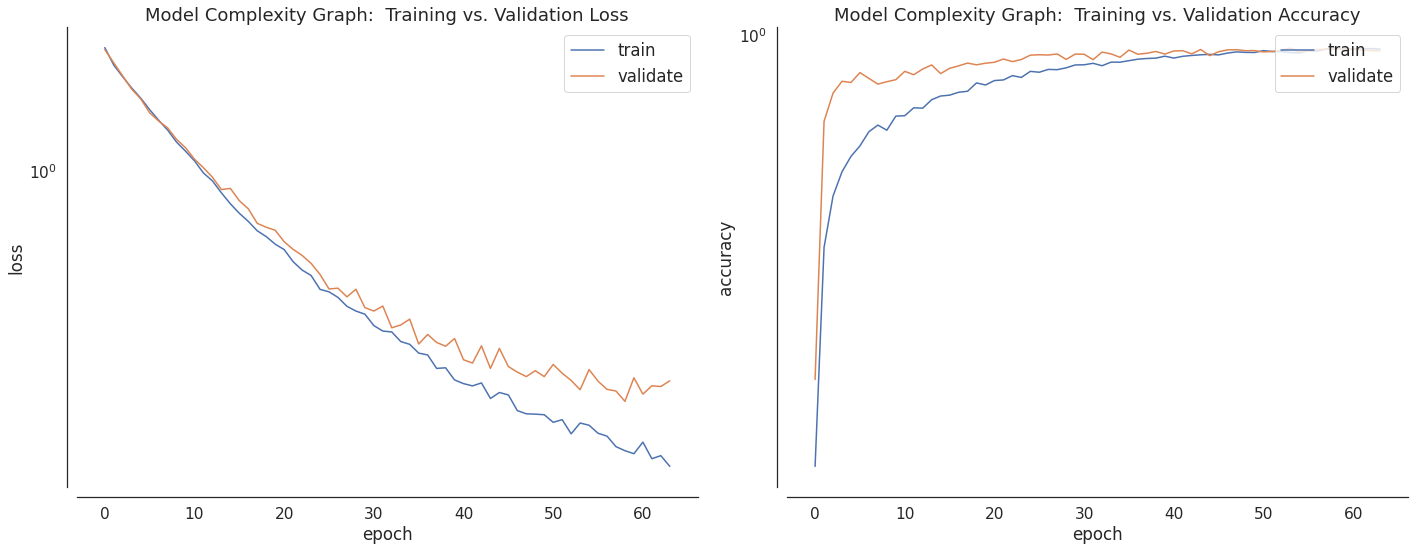

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

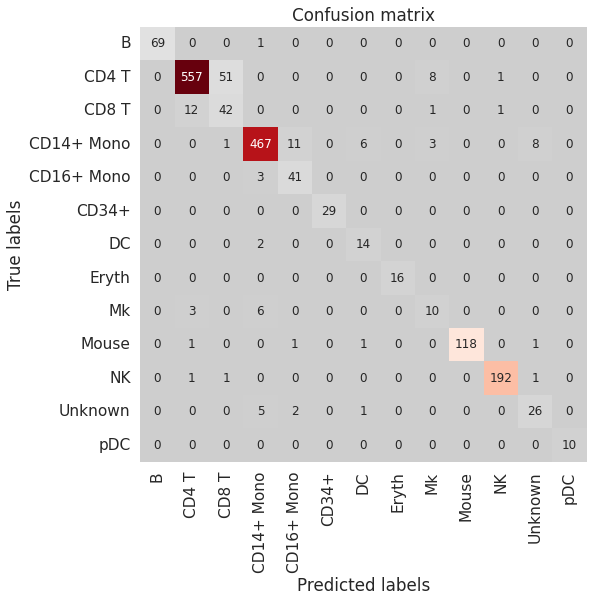

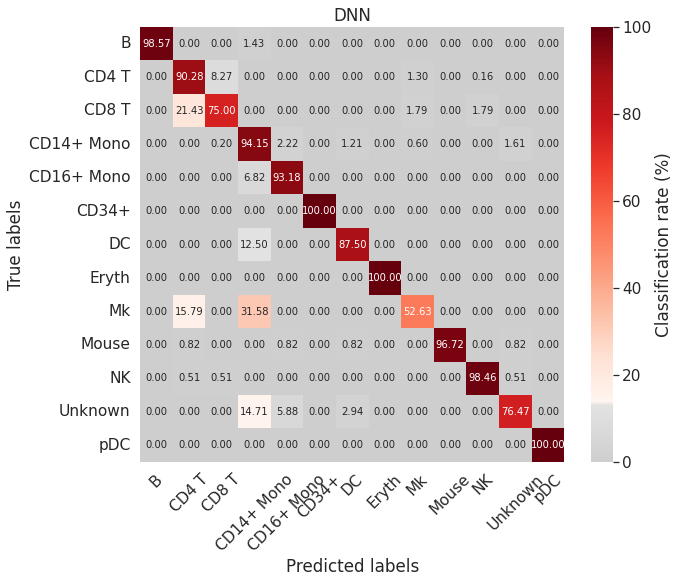

              precision    recall  f1-score   support

           B       1.00      0.99      0.99        70
       CD4 T       0.97      0.90      0.94       617
       CD8 T       0.44      0.75      0.56        56
  CD14+ Mono       0.96      0.94      0.95       496
  CD16+ Mono       0.75      0.93      0.83        44
       CD34+       1.00      1.00      1.00        29
          DC       0.64      0.88      0.74        16
       Eryth       1.00      1.00      1.00        16
          Mk       0.45      0.53      0.49        19
       Mouse       1.00      0.97      0.98       122
          NK       0.99      0.98      0.99       195
     Unknown       0.72      0.76      0.74        34
         pDC       1.00      1.00      1.00        10

    accuracy                           0.92      1724
   macro avg       0.84      0.89      0.86      1724
weighted avg       0.94      0.92      0.93      1724

54/54 [==============================] - 0s 1ms/step - loss: 0.2013 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


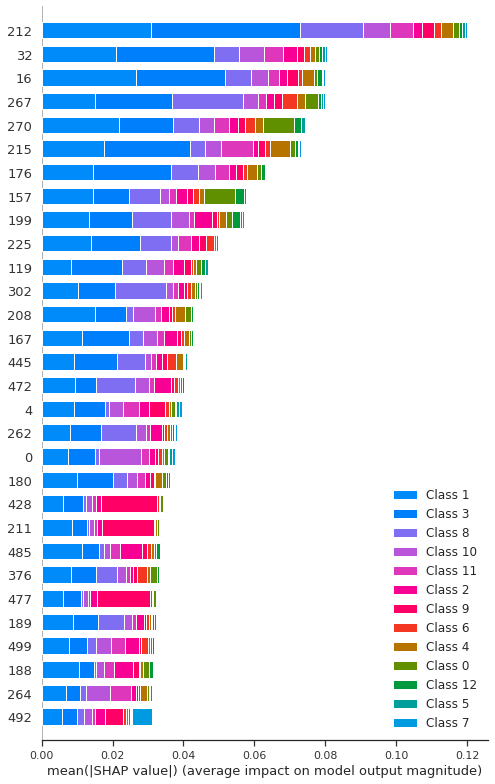

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_44 (Batc (None, 32)                128       
_________________________________________________________________
activation_44 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_67 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_45 (Batc (None, 16)                64        
_________________________________________________________________
activation_45 (Activation)   (Non

69/69 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.7859 - auc: 0.9846 - precision: 0.9252 - recall: 0.4503 - val_loss: 0.6750 - val_accuracy: 0.8608 - val_auc: 0.9932 - val_precision: 0.9591 - val_recall: 0.5708

Epoch 00019: val_loss improved from 0.69364 to 0.67500, saving model to weights/best_model_annotation.h5
Epoch 20/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6001 - accuracy: 0.7777 - auc: 0.9844 - precision: 0.9239 - recall: 0.4806 - val_loss: 0.6611 - val_accuracy: 0.8677 - val_auc: 0.9934 - val_precision: 0.9495 - val_recall: 0.5783

Epoch 00020: val_loss improved from 0.67500 to 0.66111, saving model to weights/best_model_annotation.h5
Epoch 21/100
69/69 [==============================] - 0s 3ms/step - loss: 0.5779 - accuracy: 0.7953 - auc: 0.9866 - precision: 0.9256 - recall: 0.5217 - val_loss: 0.6105 - val_accuracy: 0.8718 - val_auc: 0.9940 - val_precision: 0.9520 - val_recall: 0.6439

Epoch 00021: val_loss improved f

69/69 [==============================] - 0s 3ms/step - loss: 0.2287 - accuracy: 0.9022 - auc: 0.9963 - precision: 0.9357 - recall: 0.8532 - val_loss: 0.2960 - val_accuracy: 0.9095 - val_auc: 0.9966 - val_precision: 0.9237 - val_recall: 0.8852

Epoch 00043: val_loss did not improve from 0.26261
Epoch 44/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2053 - accuracy: 0.9053 - auc: 0.9965 - precision: 0.9386 - recall: 0.8567 - val_loss: 0.2530 - val_accuracy: 0.9298 - val_auc: 0.9973 - val_precision: 0.9402 - val_recall: 0.9113

Epoch 00044: val_loss improved from 0.26261 to 0.25305, saving model to weights/best_model_annotation.h5
Epoch 45/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2140 - accuracy: 0.9072 - auc: 0.9966 - precision: 0.9366 - recall: 0.8580 - val_loss: 0.2908 - val_accuracy: 0.9014 - val_auc: 0.9965 - val_precision: 0.9117 - val_recall: 0.8869

Epoch 00045: val_loss did not improve from 0.25305
Epoch 46/100
69/69 [===============

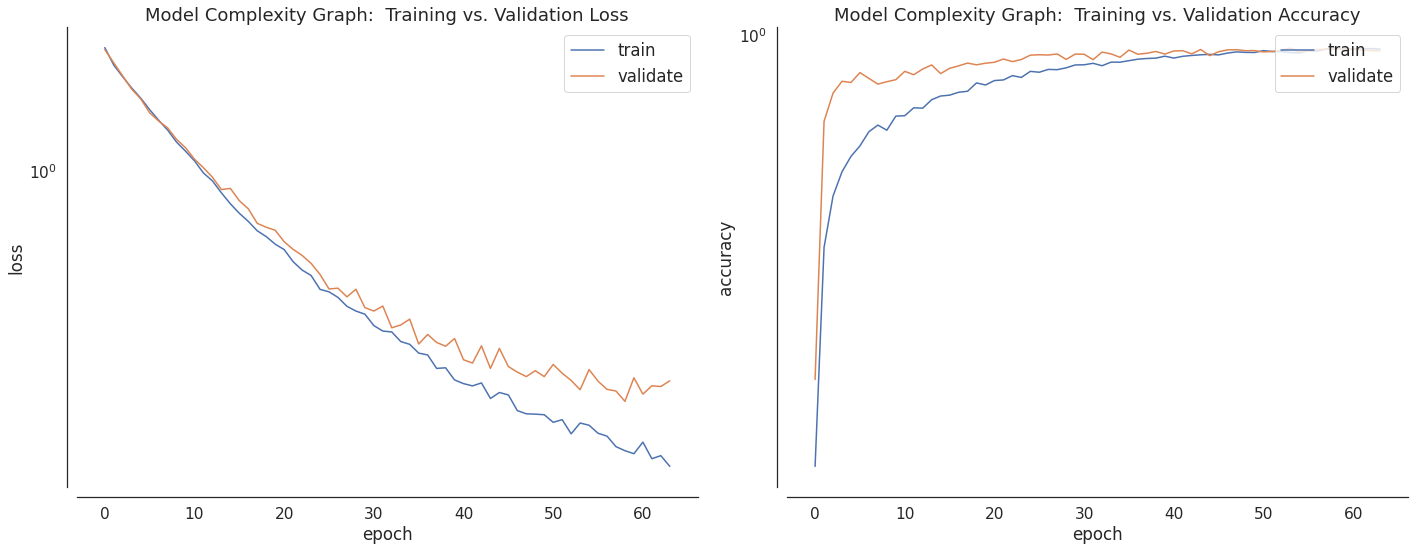

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

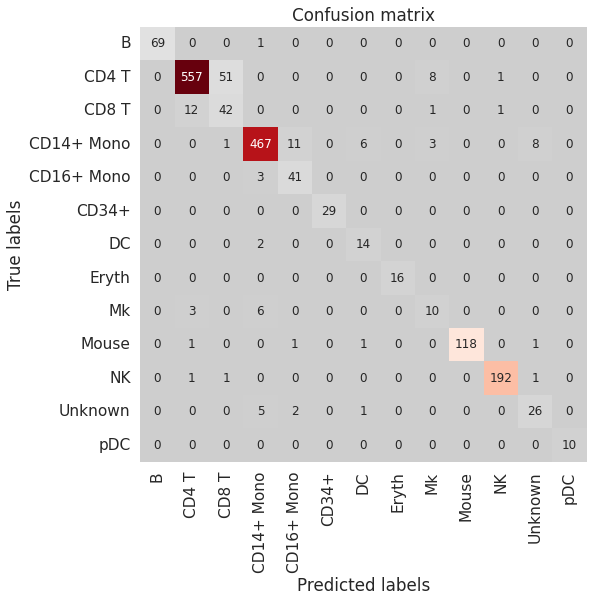

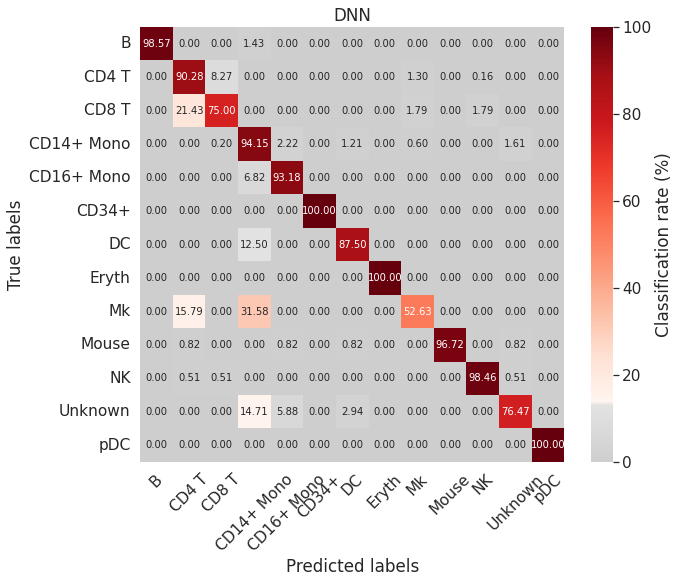

              precision    recall  f1-score   support

           B       1.00      0.99      0.99        70
       CD4 T       0.97      0.90      0.94       617
       CD8 T       0.44      0.75      0.56        56
  CD14+ Mono       0.96      0.94      0.95       496
  CD16+ Mono       0.75      0.93      0.83        44
       CD34+       1.00      1.00      1.00        29
          DC       0.64      0.88      0.74        16
       Eryth       1.00      1.00      1.00        16
          Mk       0.45      0.53      0.49        19
       Mouse       1.00      0.97      0.98       122
          NK       0.99      0.98      0.99       195
     Unknown       0.72      0.76      0.74        34
         pDC       1.00      1.00      1.00        10

    accuracy                           0.92      1724
   macro avg       0.84      0.89      0.86      1724
weighted avg       0.94      0.92      0.93      1724

54/54 [==============================] - 0s 1ms/step - loss: 0.2013 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


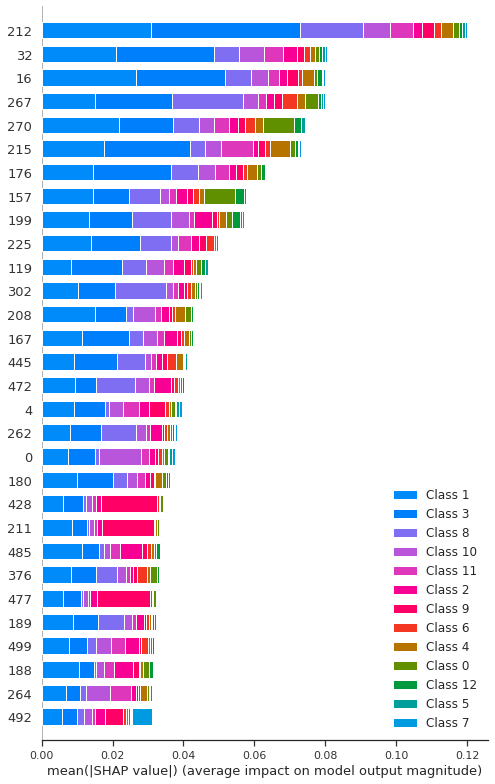

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_48 (Batc (None, 32)                128       
_________________________________________________________________
activation_48 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_49 (Batc (None, 16)                64        
_________________________________________________________________
activation_49 (Activation)   (Non

69/69 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.7859 - auc: 0.9846 - precision: 0.9252 - recall: 0.4503 - val_loss: 0.6750 - val_accuracy: 0.8608 - val_auc: 0.9932 - val_precision: 0.9591 - val_recall: 0.5708

Epoch 00019: val_loss improved from 0.69364 to 0.67500, saving model to weights/best_model_annotation.h5
Epoch 20/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6001 - accuracy: 0.7777 - auc: 0.9844 - precision: 0.9239 - recall: 0.4806 - val_loss: 0.6611 - val_accuracy: 0.8677 - val_auc: 0.9934 - val_precision: 0.9495 - val_recall: 0.5783

Epoch 00020: val_loss improved from 0.67500 to 0.66111, saving model to weights/best_model_annotation.h5
Epoch 21/100
69/69 [==============================] - 0s 3ms/step - loss: 0.5779 - accuracy: 0.7953 - auc: 0.9866 - precision: 0.9256 - recall: 0.5217 - val_loss: 0.6105 - val_accuracy: 0.8718 - val_auc: 0.9940 - val_precision: 0.9520 - val_recall: 0.6439

Epoch 00021: val_loss improved f

69/69 [==============================] - 0s 3ms/step - loss: 0.2287 - accuracy: 0.9022 - auc: 0.9963 - precision: 0.9357 - recall: 0.8532 - val_loss: 0.2960 - val_accuracy: 0.9095 - val_auc: 0.9966 - val_precision: 0.9237 - val_recall: 0.8852

Epoch 00043: val_loss did not improve from 0.26261
Epoch 44/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2053 - accuracy: 0.9053 - auc: 0.9965 - precision: 0.9386 - recall: 0.8567 - val_loss: 0.2530 - val_accuracy: 0.9298 - val_auc: 0.9973 - val_precision: 0.9402 - val_recall: 0.9113

Epoch 00044: val_loss improved from 0.26261 to 0.25305, saving model to weights/best_model_annotation.h5
Epoch 45/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2140 - accuracy: 0.9072 - auc: 0.9966 - precision: 0.9366 - recall: 0.8580 - val_loss: 0.2908 - val_accuracy: 0.9014 - val_auc: 0.9965 - val_precision: 0.9117 - val_recall: 0.8869

Epoch 00045: val_loss did not improve from 0.25305
Epoch 46/100
69/69 [===============

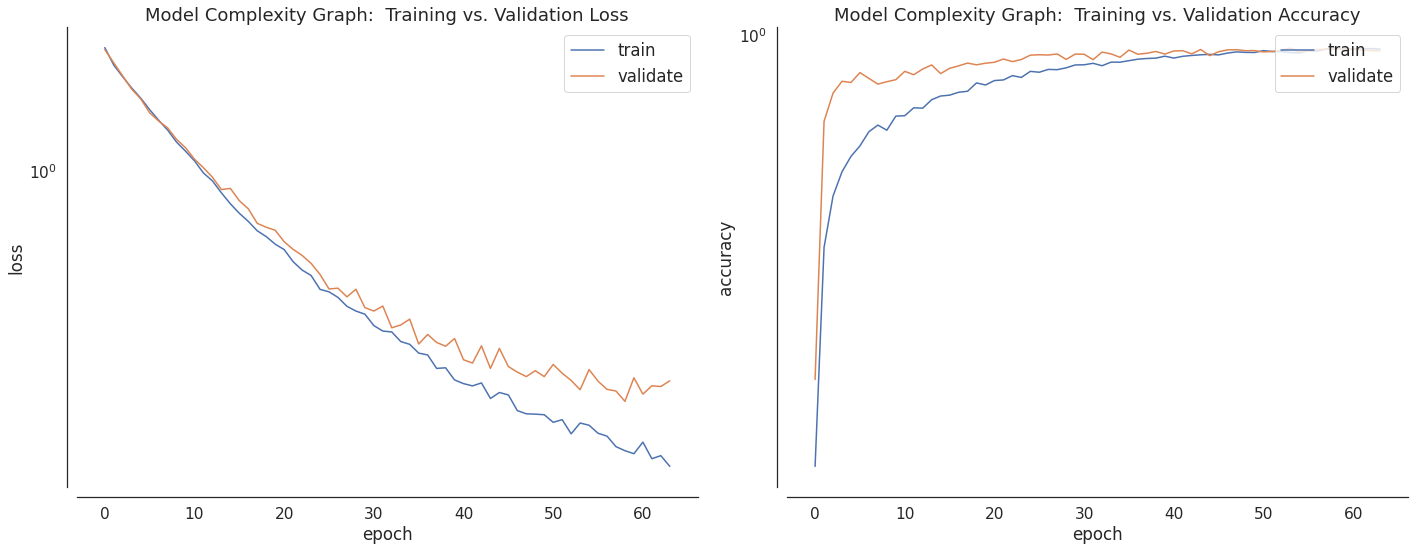

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

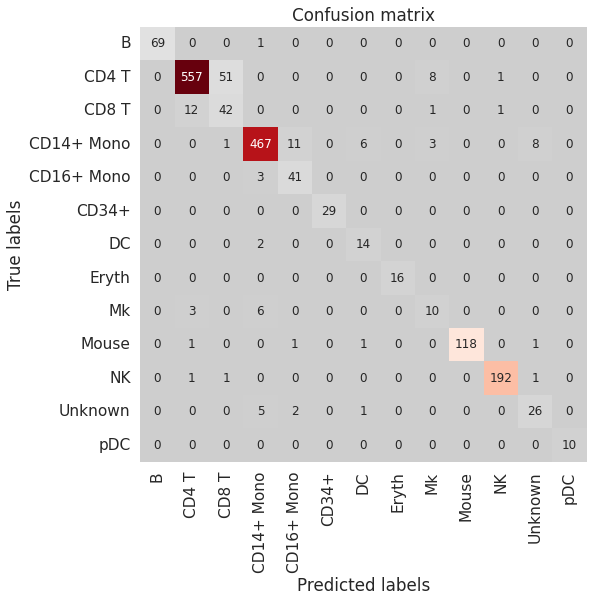

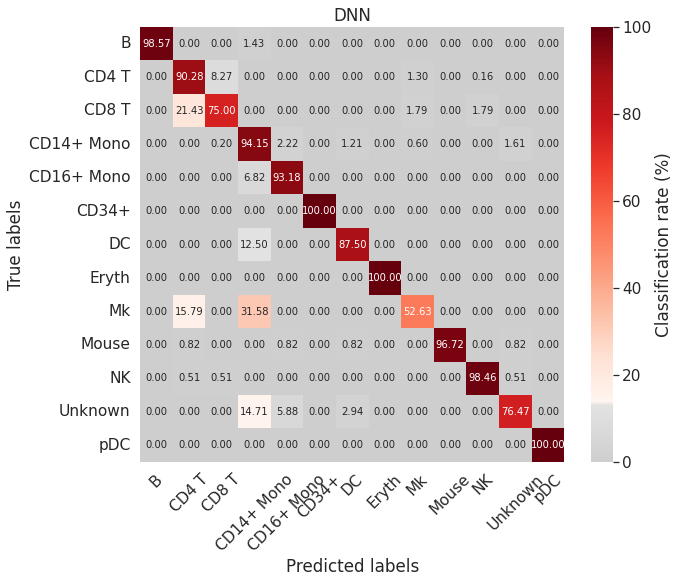

              precision    recall  f1-score   support

           B       1.00      0.99      0.99        70
       CD4 T       0.97      0.90      0.94       617
       CD8 T       0.44      0.75      0.56        56
  CD14+ Mono       0.96      0.94      0.95       496
  CD16+ Mono       0.75      0.93      0.83        44
       CD34+       1.00      1.00      1.00        29
          DC       0.64      0.88      0.74        16
       Eryth       1.00      1.00      1.00        16
          Mk       0.45      0.53      0.49        19
       Mouse       1.00      0.97      0.98       122
          NK       0.99      0.98      0.99       195
     Unknown       0.72      0.76      0.74        34
         pDC       1.00      1.00      1.00        10

    accuracy                           0.92      1724
   macro avg       0.84      0.89      0.86      1724
weighted avg       0.94      0.92      0.93      1724

54/54 [==============================] - 0s 1ms/step - loss: 0.2013 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


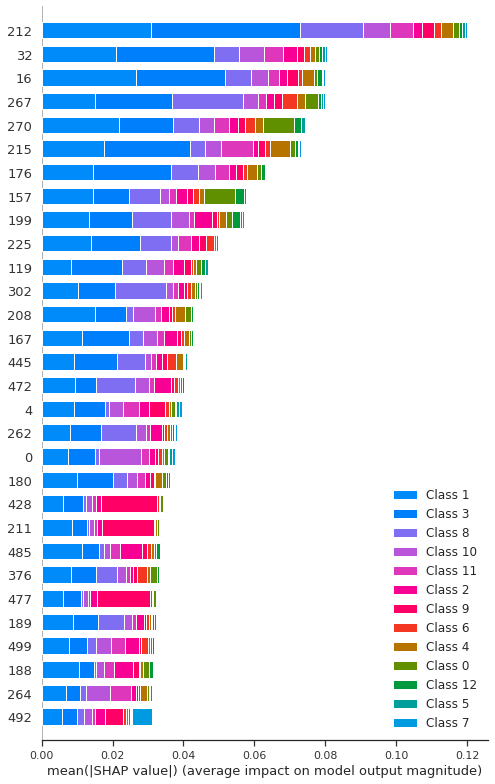

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_52 (Batc (None, 32)                128       
_________________________________________________________________
activation_52 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_79 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_53 (Batc (None, 16)                64        
_________________________________________________________________
activation_53 (Activation)   (Non

69/69 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.7859 - auc: 0.9846 - precision: 0.9252 - recall: 0.4503 - val_loss: 0.6750 - val_accuracy: 0.8608 - val_auc: 0.9932 - val_precision: 0.9591 - val_recall: 0.5708

Epoch 00019: val_loss improved from 0.69364 to 0.67500, saving model to weights/best_model_annotation.h5
Epoch 20/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6001 - accuracy: 0.7777 - auc: 0.9844 - precision: 0.9239 - recall: 0.4806 - val_loss: 0.6611 - val_accuracy: 0.8677 - val_auc: 0.9934 - val_precision: 0.9495 - val_recall: 0.5783

Epoch 00020: val_loss improved from 0.67500 to 0.66111, saving model to weights/best_model_annotation.h5
Epoch 21/100
69/69 [==============================] - 0s 3ms/step - loss: 0.5779 - accuracy: 0.7953 - auc: 0.9866 - precision: 0.9256 - recall: 0.5217 - val_loss: 0.6105 - val_accuracy: 0.8718 - val_auc: 0.9940 - val_precision: 0.9520 - val_recall: 0.6439

Epoch 00021: val_loss improved f

69/69 [==============================] - 0s 3ms/step - loss: 0.2287 - accuracy: 0.9022 - auc: 0.9963 - precision: 0.9357 - recall: 0.8532 - val_loss: 0.2960 - val_accuracy: 0.9095 - val_auc: 0.9966 - val_precision: 0.9237 - val_recall: 0.8852

Epoch 00043: val_loss did not improve from 0.26261
Epoch 44/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2053 - accuracy: 0.9053 - auc: 0.9965 - precision: 0.9386 - recall: 0.8567 - val_loss: 0.2530 - val_accuracy: 0.9298 - val_auc: 0.9973 - val_precision: 0.9402 - val_recall: 0.9113

Epoch 00044: val_loss improved from 0.26261 to 0.25305, saving model to weights/best_model_annotation.h5
Epoch 45/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2140 - accuracy: 0.9072 - auc: 0.9966 - precision: 0.9366 - recall: 0.8580 - val_loss: 0.2908 - val_accuracy: 0.9014 - val_auc: 0.9965 - val_precision: 0.9117 - val_recall: 0.8869

Epoch 00045: val_loss did not improve from 0.25305
Epoch 46/100
69/69 [===============

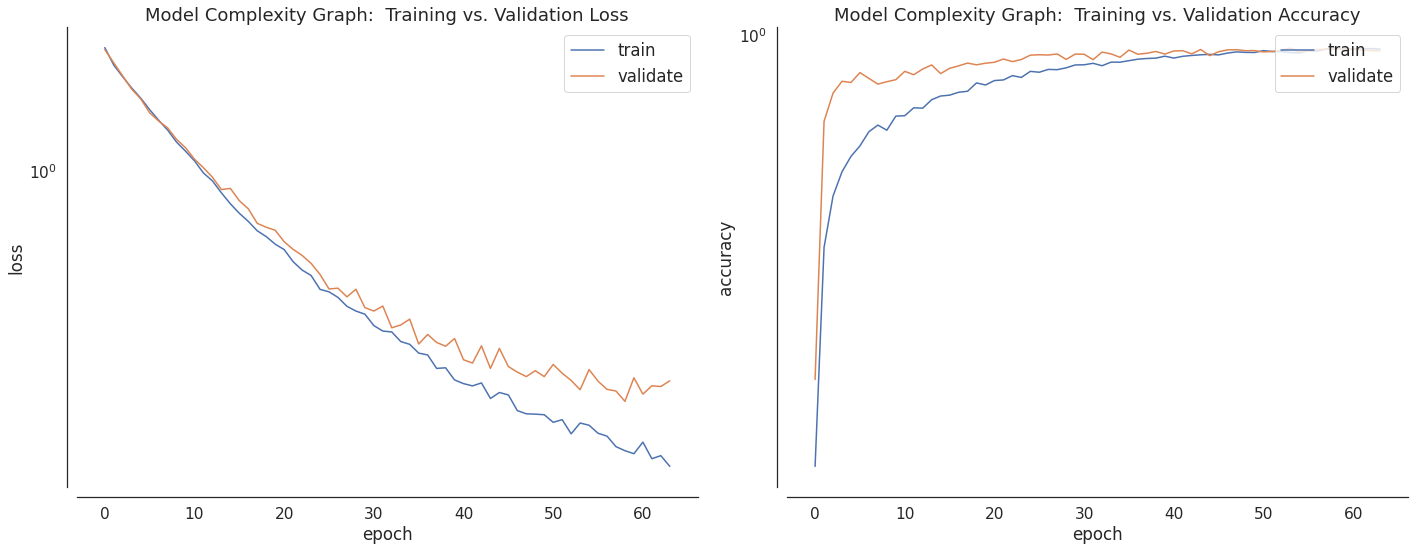

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

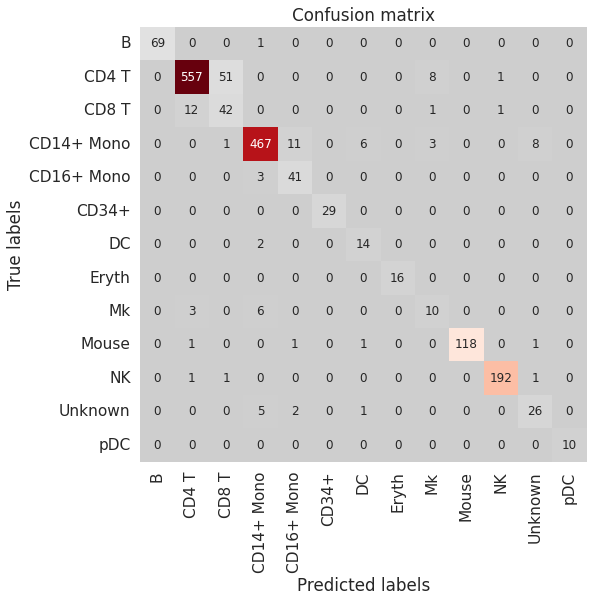

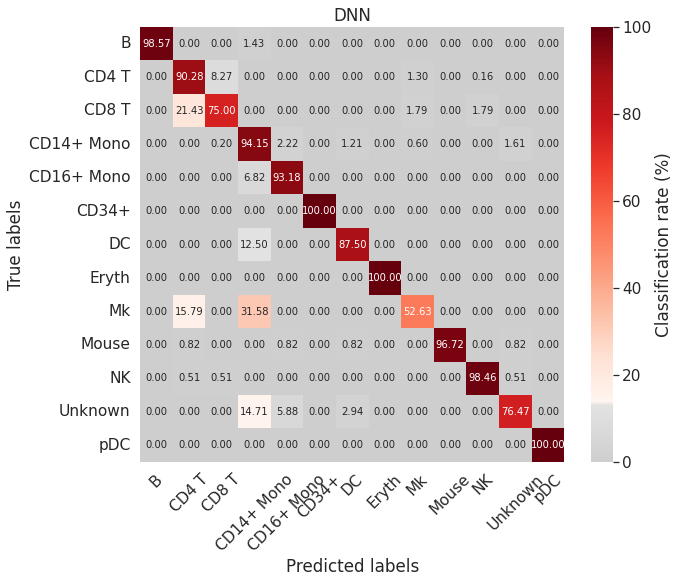

              precision    recall  f1-score   support

           B       1.00      0.99      0.99        70
       CD4 T       0.97      0.90      0.94       617
       CD8 T       0.44      0.75      0.56        56
  CD14+ Mono       0.96      0.94      0.95       496
  CD16+ Mono       0.75      0.93      0.83        44
       CD34+       1.00      1.00      1.00        29
          DC       0.64      0.88      0.74        16
       Eryth       1.00      1.00      1.00        16
          Mk       0.45      0.53      0.49        19
       Mouse       1.00      0.97      0.98       122
          NK       0.99      0.98      0.99       195
     Unknown       0.72      0.76      0.74        34
         pDC       1.00      1.00      1.00        10

    accuracy                           0.92      1724
   macro avg       0.84      0.89      0.86      1724
weighted avg       0.94      0.92      0.93      1724

54/54 [==============================] - 0s 1ms/step - loss: 0.2013 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


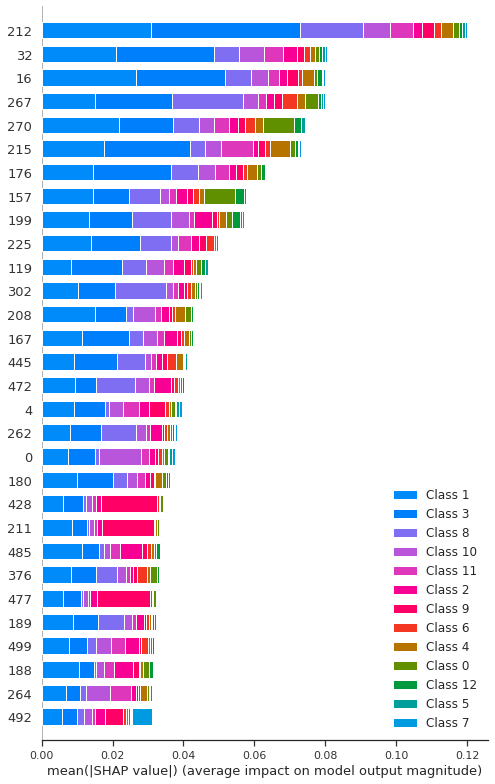

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 * Initialising ...
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_56 (Batc (None, 32)                128       
_________________________________________________________________
activation_56 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_85 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_57 (Batc (None, 16)                64        
_________________________________________________________________
activation_57 (Activation)   (Non

69/69 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.7859 - auc: 0.9846 - precision: 0.9252 - recall: 0.4503 - val_loss: 0.6750 - val_accuracy: 0.8608 - val_auc: 0.9932 - val_precision: 0.9591 - val_recall: 0.5708

Epoch 00019: val_loss improved from 0.69364 to 0.67500, saving model to weights/best_model_annotation.h5
Epoch 20/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6001 - accuracy: 0.7777 - auc: 0.9844 - precision: 0.9239 - recall: 0.4806 - val_loss: 0.6611 - val_accuracy: 0.8677 - val_auc: 0.9934 - val_precision: 0.9495 - val_recall: 0.5783

Epoch 00020: val_loss improved from 0.67500 to 0.66111, saving model to weights/best_model_annotation.h5
Epoch 21/100
69/69 [==============================] - 0s 3ms/step - loss: 0.5779 - accuracy: 0.7953 - auc: 0.9866 - precision: 0.9256 - recall: 0.5217 - val_loss: 0.6105 - val_accuracy: 0.8718 - val_auc: 0.9940 - val_precision: 0.9520 - val_recall: 0.6439

Epoch 00021: val_loss improved f

69/69 [==============================] - 0s 3ms/step - loss: 0.2287 - accuracy: 0.9022 - auc: 0.9963 - precision: 0.9357 - recall: 0.8532 - val_loss: 0.2960 - val_accuracy: 0.9095 - val_auc: 0.9966 - val_precision: 0.9237 - val_recall: 0.8852

Epoch 00043: val_loss did not improve from 0.26261
Epoch 44/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2053 - accuracy: 0.9053 - auc: 0.9965 - precision: 0.9386 - recall: 0.8567 - val_loss: 0.2530 - val_accuracy: 0.9298 - val_auc: 0.9973 - val_precision: 0.9402 - val_recall: 0.9113

Epoch 00044: val_loss improved from 0.26261 to 0.25305, saving model to weights/best_model_annotation.h5
Epoch 45/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2140 - accuracy: 0.9072 - auc: 0.9966 - precision: 0.9366 - recall: 0.8580 - val_loss: 0.2908 - val_accuracy: 0.9014 - val_auc: 0.9965 - val_precision: 0.9117 - val_recall: 0.8869

Epoch 00045: val_loss did not improve from 0.25305
Epoch 46/100
69/69 [===============

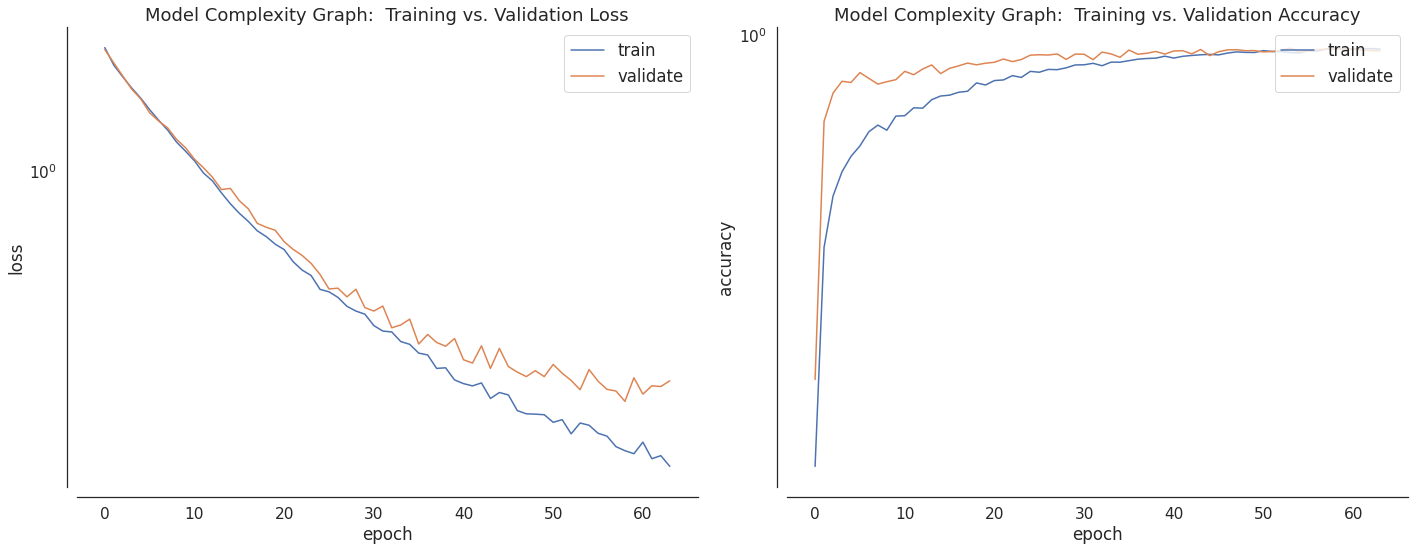

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

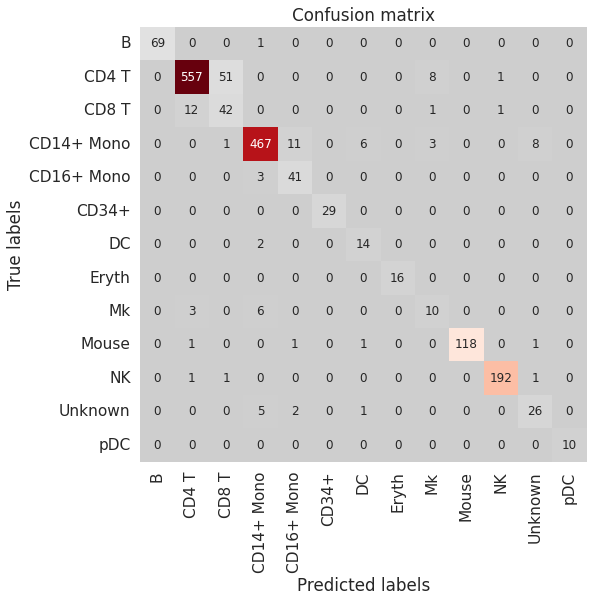

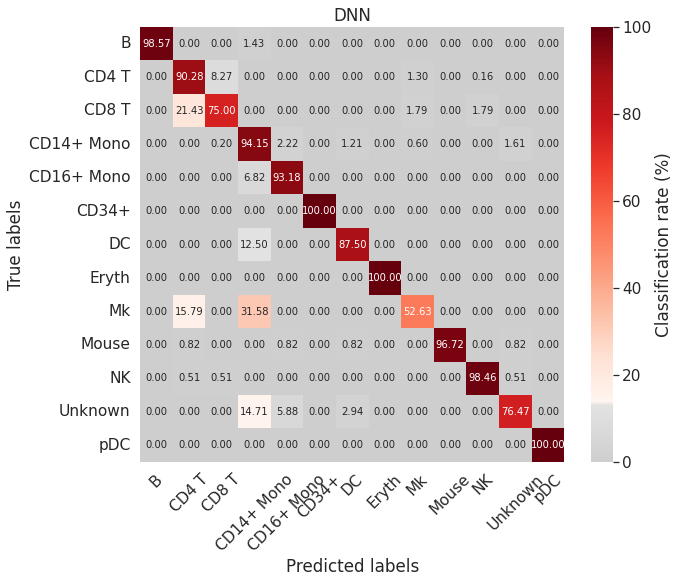

              precision    recall  f1-score   support

           B       1.00      0.99      0.99        70
       CD4 T       0.97      0.90      0.94       617
       CD8 T       0.44      0.75      0.56        56
  CD14+ Mono       0.96      0.94      0.95       496
  CD16+ Mono       0.75      0.93      0.83        44
       CD34+       1.00      1.00      1.00        29
          DC       0.64      0.88      0.74        16
       Eryth       1.00      1.00      1.00        16
          Mk       0.45      0.53      0.49        19
       Mouse       1.00      0.97      0.98       122
          NK       0.99      0.98      0.99       195
     Unknown       0.72      0.76      0.74        34
         pDC       1.00      1.00      1.00        10

    accuracy                           0.92      1724
   macro avg       0.84      0.89      0.86      1724
weighted avg       0.94      0.92      0.93      1724

54/54 [==============================] - 0s 1ms/step - loss: 0.2013 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


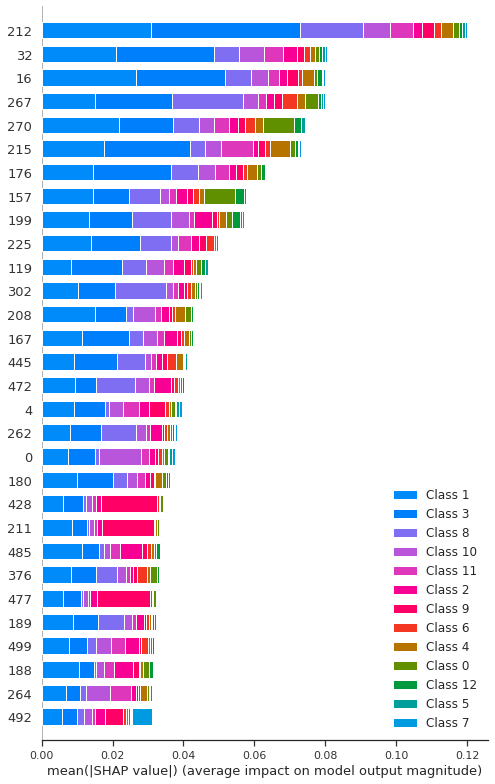

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


CPU times: user 14min 42s, sys: 29.1 s, total: 15min 11s
Wall time: 7min 17s


In [19]:
%%time
k = 50
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = citeseq_adata[np.concatenate([train_indices, val_indices]), :]
    sm = smashpy.smashpy()
    sm.DNN(citeseq_adata, group_by="annotation", model=None, balance=True, verbose=True, save=False)
    selectedGenes, selectedGenes_dict = sm.run_shap(citeseq_adata, group_by="annotation", model=None, verbose=True, pct=0.1, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = citeseq_adata.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'smash_markers_{}.npy'.format(tryy), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Smash Marker Visualization', path = viz_save_path + 'smash_markers_{}.png'.format(tryy), markers = smash_markers)

## Train RankCorr

In [20]:
lamb_range = [0.5, 1.5, 3, 7, 21.9]
lamb_i = 0

In [21]:
for k in k_range:
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    data = Rocks(X_train, y_train)
    lamb = lamb_range[lamb_i]
    lamb_i = lamb_i + 1

    rankcorr_markers = data.CSrankMarkers(lamb=lamb, writeOut=False, keepZeros=False, onlyNonZero=False)
    if len(rankcorr_markers) < k:
        print(lamb)
        print(len(rankcorr_markers))
        print(k)
        raise Exception("Increase lamb for rank corr procedure")
    if len(rankcorr_markers) > k:
        print("Excess Length of markers")
        print(len(rankcorr_markers))
        rankcorr_markers = rankcorr_markers[:k]
    geneNames = np.array(citeseq_adata.var.index)
    data.genes = geneNames
    marker_genes = data.markers_to_genes(rankcorr_markers)
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = rankcorr_markers)
    np.save(model_save_path + 'rankcorr_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'rankcorr_markers_k_{}.npy'.format(k), rankcorr_markers)
    np.save(model_save_path + 'experiment_data_folds/rankcorr_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'RankCorr Marker Visualization', path = viz_save_path + 'rankcorr_markers_k_{}.png'.format(k), markers = rankcorr_markers)

Excess Length of markers
12


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Excess Length of markers
30


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Excess Length of markers
55


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Excess Length of markers
109


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Excess Length of markers
266


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [22]:
k = 50
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    data = Rocks(X_train, y_train)
    lamb = 3.2# this can be whatever

    rankcorr_markers = data.CSrankMarkers(lamb=lamb, writeOut=False, keepZeros=False, onlyNonZero=False)
    if len(rankcorr_markers) < k:
        raise Exception("Increase lamb for rank corr procedure")
    if len(rankcorr_markers) > k:
        print("Excess Length of markers")
        print(len(rankcorr_markers))
        rankcorr_markers = rankcorr_markers[:k]
    geneNames = np.array(citeseq_adata.var.index)
    data.genes = geneNames
    marker_genes = data.markers_to_genes(rankcorr_markers)
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = rankcorr_markers)
    np.save(model_save_path + 'rankcorr_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'rankcorr_markers_{}.npy'.format(tryy), rankcorr_markers)
    np.save(model_save_path + 'experiment_data_folds/rankcorr_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'RankCorr Marker Visualization', path = viz_save_path + 'rankcorr_markers_{}.png'.format(tryy), markers = rankcorr_markers)

Excess Length of markers
56


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Excess Length of markers
56


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Excess Length of markers
60


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Excess Length of markers
57


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Excess Length of markers
57


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Excess Length of markers
56


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Excess Length of markers
60


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Excess Length of markers
58


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Excess Length of markers
59


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Excess Length of markers
58


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


## Train L1 VAE

In [23]:
feature_std = torch.tensor(X).std(dim = 0)
for k in k_range:
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_l1_diag(input_size, hidden_layer_size, z_size, batch_norm = batch_norm)
    tmp_path = model_save_path + 'l1_vae_k_{}.ckpt'.format(k)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, min_epochs = 25, 
                     max_epochs = 100, auto_lr = True, early_stopping_patience = 4, precision = precision)
    l1_markers = model.markers(feature_std = feature_std.to(model.device), k = k).clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = l1_markers)
    np.save(model_save_path + 'l1_vae_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'l1_vae_markers_k_{}.npy'.format(k), l1_markers)
    np.save(model_save_path + 'experiment_data_folds/l1_vae_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'L1 VAE Marker Visualization', path = viz_save_path + 'l1_vae_markers_k_{}.png'.format(k), markers = l1_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:01<00:00, 63.47it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:01<00:00, 63.40it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_di

In [24]:
feature_std = torch.tensor(X).std(dim = 0)
k = 50
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_l1_diag(input_size, hidden_layer_size, z_size, batch_norm = batch_norm)
    tmp_path = model_save_path + 'l1_vae_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, min_epochs = 25, 
                     max_epochs = 100, auto_lr = True, early_stopping_patience = 4, precision = precision)
    l1_markers = model.markers(feature_std = feature_std.to(model.device), k = k).clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = l1_markers)
    np.save(model_save_path + 'l1_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'l1_vae_markers_{}.npy'.format(tryy), l1_markers)
    np.save(model_save_path + 'experiment_data_folds/l1_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'L1 VAE Marker Visualization', path = viz_save_path + 'l1_vae_markers_{}.png'.format(tryy), markers = l1_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:01<00:00, 66.15it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when 

Finding best initial lr: 100%|██████████| 100/100 [00:01<00:00, 64.27it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` inst

## Train Global Gate

In [25]:
for k in k_range:
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers=num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_Gumbel_GlobalGate(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, batch_norm = batch_norm)
    tmp_path = model_save_path + 'globalgate_vae_k_{}.ckpt'.format(k)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus = gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.00001, early_stopping_patience =  10, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    globalgate_markers = model.markers().clone().cpu().detach().numpy()
    
 
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = globalgate_markers)
    np.save(model_save_path + 'globalgate_vae_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'globalgate_vae_markers_k_{}.npy'.format(k), globalgate_markers)
    np.save(model_save_path + 'experiment_data_folds/globalgate_vae_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Global Gate VAE Marker Visualization', path = viz_save_path + 'globalgate_vae_markers_k_{}.png'.format(k), markers = globalgate_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:01<00:00, 53.24it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when 

In [26]:
k = 50
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers=num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_Gumbel_GlobalGate(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, batch_norm = batch_norm)
    tmp_path = model_save_path + 'globalgate_vae_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus = gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.00001, early_stopping_patience =  10, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    globalgate_markers = model.markers().clone().cpu().detach().numpy()
    
 
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = globalgate_markers)
    np.save(model_save_path + 'globalgate_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'globalgate_vae_markers_{}.npy'.format(tryy), globalgate_markers)
    np.save(model_save_path + 'experiment_data_folds/globalgate_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Global Gate VAE Marker Visualization', path = viz_save_path + 'globalgate_vae_markers_{}.png'.format(tryy), markers = globalgate_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 38.12it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when 

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 38.72it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when 

## Train MarkerMap Unsupervised

In [27]:
for k in k_range:
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = MarkerMap(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 1.0, num_classes = None)
    tmp_path = model_save_path + 'marker_map_unsupervised_k_{}.ckpt'.format(k)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 4, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    marker_map_unsupervised_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = marker_map_unsupervised_markers)
    np.save(model_save_path + 'marker_map_unsupervised_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'marker_map_unsupervised_markers_k_{}.npy'.format(k), marker_map_unsupervised_markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_unsupervised_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'MarkerMap Unsupervised Marker Visualization', path = viz_save_path + 'marker_map_unsupervised_markers_k_{}.png'.format(k), markers = marker_map_unsupervised_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 48.42it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when 

In [28]:
k = 50
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = MarkerMap(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 1.0, num_classes = None)
    tmp_path = model_save_path + 'marker_map_unsupervised_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 4, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    unsupervised_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = unsupervised_markers)
    np.save(model_save_path + 'marker_map_unsupervised_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), unsupervised_markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_unsupervised_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Marker Map Unsupervised Marker Visualization', path = viz_save_path + 'marker_map_unsupervised_markers_{}.png'.format(tryy), markers = unsupervised_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 35.60it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 35.09it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays wi

## MarkerMap Supervised

In [29]:
for k in k_range:
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 0)
    tmp_path = model_save_path + 'marker_map_supervised_k_{}.ckpt'.format(k)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers)
    np.save(model_save_path + 'marker_map_supervised_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'marker_map_supervised_markers_k_{}.npy'.format(k), markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_supervised_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'MarkerMap Supervised Marker Visualization', path = viz_save_path + 'marker_map_supervised_markers_k_{}.png'.format(k), markers = markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:01<00:00, 52.96it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 44.51it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays wi

In [30]:
k = 50
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 0)
    tmp_path = model_save_path + 'marker_map_supervised_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers)
    np.save(model_save_path + 'marker_map_supervised_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'marker_map_supervised_markers_{}.npy'.format(tryy), markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_supervised_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'MarkerMap Supervised Marker Visualization', path = viz_save_path + 'marker_map_supervised_markers_{}.png'.format(tryy), markers = markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 37.62it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 37.91it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays wi

## Train MarkerMap Mixed Supervision

In [31]:
for tryy in k_range:
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 0.5)
    tmp_path = model_save_path + 'marker_map_mixed_k_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers)
    np.save(model_save_path + 'marker_map_mixed_results_k_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'marker_map_mixed_markers_k_{}.npy'.format(tryy), markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_mixed_indices_k_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'MarkerMap Mixed Supervision Marker Visualization', path = viz_save_path + 'marker_map_mixed_markers_k_{}.png'.format(tryy), markers = markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 33.07it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 32.17it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays wi

In [32]:
k = 50
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 0.5)
    tmp_path = model_save_path + 'marker_map_mixed_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers)
    np.save(model_save_path + 'marker_map_mixed_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'marker_map_mixed_markers_{}.npy'.format(tryy), markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_mixed_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'MarkerMap Mixed Supervision Marker Visualization', path = viz_save_path + 'marker_map_mixed_markers_{}.png'.format(tryy), markers = markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 34.41it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 34.65it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays wi

## Concrete VAE

In [33]:
for k in k_range:
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = ConcreteVAE_NMSL(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay = 0.9, batch_norm = batch_norm)
    tmp_path = model_save_path + 'concrete_vae_k_{}.ckpt'.format(k)
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 3, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = 16)
    concrete_vae_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = concrete_vae_markers)
    np.save(model_save_path + 'concrete_vae_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'concrete_vae_markers_k_{}.npy'.format(k), concrete_vae_markers)
    np.save(model_save_path + 'experiment_data_folds/concrete_vae_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Concrete VAE Marker Visualization', path = viz_save_path + 'concrete_vae_markers_k_{}.png'.format(k), markers = concrete_vae_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:01<00:00, 58.05it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when 

In [34]:
k = 50
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = ConcreteVAE_NMSL(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay = 0.9, batch_norm = batch_norm)
    tmp_path = model_save_path + 'concrete_vae_{}.ckpt'.format(tryy)
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 3, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    concrete_vae_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = concrete_vae_markers)
    np.save(model_save_path + 'concrete_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'concrete_vae_markers_{}.npy'.format(tryy), concrete_vae_markers)
    np.save(model_save_path + 'experiment_data_folds/concrete_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Concrete VAE Marker Visualization', path = viz_save_path + 'concrete_vae_markers_{}.png'.format(tryy), markers = concrete_vae_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:01<00:00, 61.96it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when 

In [35]:
results

(0.11716937354988399,
 {'0': {'precision': 0.9302325581395349,
   'recall': 0.6451612903225806,
   'f1-score': 0.761904761904762,
   'support': 62},
  '1': {'precision': 0.8509212730318257,
   'recall': 0.9941291585127201,
   'f1-score': 0.9169675090252707,
   'support': 511},
  '2': {'precision': 1.0,
   'recall': 0.0425531914893617,
   'f1-score': 0.08163265306122448,
   'support': 47},
  '3': {'precision': 1.0,
   'recall': 0.7916666666666666,
   'f1-score': 0.8837209302325582,
   'support': 24},
  '4': {'precision': 0.8674863387978142,
   'recall': 0.9952978056426333,
   'f1-score': 0.927007299270073,
   'support': 638},
  '5': {'precision': 1.0,
   'recall': 0.018867924528301886,
   'f1-score': 0.037037037037037035,
   'support': 53},
  '6': {'precision': 1.0,
   'recall': 0.1111111111111111,
   'f1-score': 0.19999999999999998,
   'support': 18},
  '7': {'precision': 1.0,
   'recall': 0.8666666666666667,
   'f1-score': 0.9285714285714286,
   'support': 15},
  '8': {'precision': 1.

## LassoNet

In [36]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [37]:
from functools import partial
from lassonet import plot_path

In [38]:
k = 50
for tryy in range(1,num_times+1):  
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[train_indices, :]
    y_train = y[train_indices]
    X_val = X[val_indices,:]
    y_val = y[val_indices]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = LassoNetClassifier(hidden_dims = (hidden_layer_size, hidden_layer_size, hidden_layer_size))
    model.path(X_train, y_train, X_val = X_val, y_val = y_val)
    lasso_net_markers = torch.argsort(model.feature_importances_, descending = True).cpu().numpy()[:k]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = lasso_net_markers)
    np.save(model_save_path + 'lasso_net_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'lasso_net_markers_{}.npy'.format(tryy), lasso_net_markers)
    np.save(model_save_path + 'experiment_data_folds/lasso_net_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'LassoNet Marker Visualization', path = viz_save_path + 'lasso_net_markers_{}.png'.format(tryy), markers = lasso_net_markers)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences

In [39]:
for k in k_range:
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[train_indices, :]
    y_train = y[train_indices]
    X_val = X[val_indices,:]
    y_val = y[val_indices]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = LassoNetClassifier(hidden_dims = (hidden_layer_size, hidden_layer_size, hidden_layer_size))
    model.path(X_train, y_train, X_val = X_val, y_val = y_val)
    lasso_net_markers = torch.argsort(model.feature_importances_, descending = True).cpu().numpy()[:k]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = lasso_net_markers)
    np.save(model_save_path + 'lasso_net_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'lasso_net_markers_k_{}.npy'.format(k), lasso_net_markers)
    np.save(model_save_path + 'experiment_data_folds/lasso_net_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))
    visualize_save_embedding(X, y, encoder, 'LassoNet Marker Visualization', path = viz_save_path + 'lasso_net_markers_k_{}.png'.format(k), markers = lasso_net_markers)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or

In [40]:
results

(0.06380510440835263,
 {'0': {'precision': 1.0,
   'recall': 0.958904109589041,
   'f1-score': 0.9790209790209791,
   'support': 73},
  '1': {'precision': 0.9259259259259259,
   'recall': 0.998003992015968,
   'f1-score': 0.9606147934678194,
   'support': 501},
  '2': {'precision': 0.8787878787878788,
   'recall': 0.7631578947368421,
   'f1-score': 0.8169014084507042,
   'support': 38},
  '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 21},
  '4': {'precision': 0.9124293785310734,
   'recall': 0.9984544049459042,
   'f1-score': 0.9535055350553505,
   'support': 647},
  '5': {'precision': 1.0,
   'recall': 0.018867924528301886,
   'f1-score': 0.037037037037037035,
   'support': 53},
  '6': {'precision': 1.0,
   'recall': 0.5294117647058824,
   'f1-score': 0.6923076923076924,
   'support': 17},
  '7': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 14},
  '8': {'precision': 1.0,
   'recall': 0.2,
   'f1-score': 0.33333333333333337,
   'support': 20},
  '9

## Get Model Metrics from KNNs Classifiers


In [41]:
from sklearn.neighbors import KNeighborsClassifier

In [42]:
def generate_metrics_from_saved_files(X, y, folds_path, markers_path, classifier_model, save_path):
    train_indices, val_indices, test_indices = np.load(folds_path, allow_pickle = True)
    markers = np.load(markers_path, allow_pickle = True)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices, :]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers, model = classifier_model)

    np.save(save_path, results)
    return

In [43]:
def batch_generate_metrics_from_saved_files(X, y, format_folds_path, format_markers_path, format_save_path):
    for tryy in range(1, num_times+1):
        classifier_model = KNeighborsClassifier()
        generate_metrics_from_saved_files(X, y, format_folds_path.format(tryy), format_markers_path.format(tryy), classifier_model, format_save_path.format(tryy))
    return

In [44]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/all_markers_indices_{}.npy',
                                  model_save_path+'all_markers_{}.npy',
                                  model_save_path+'all_markers_knn_results_{}.npy')

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences

In [45]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/l1_vae_indices_{}.npy',
                                  model_save_path+'l1_vae_markers_{}.npy',
                                  model_save_path+'l1_vae_knn_results_{}.npy')

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Precision and F-score are ill-defined and being 

In [46]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/smash_rf_indices_{}.npy',
                                  model_save_path+'smash_rf_markers_{}.npy',
                                  model_save_path+'smash_rf_knn_results_{}.npy')

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences

In [47]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/smash_indices_{}.npy',
                                  model_save_path+'smash_markers_{}.npy',
                                  model_save_path+'smash_knn_results_{}.npy')

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences

In [48]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/rankcorr_indices_{}.npy',
                                  model_save_path+'rankcorr_markers_{}.npy',
                                  model_save_path+'rankcorr_knn_results_{}.npy')

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences

In [49]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/globalgate_vae_indices_{}.npy',
                                  model_save_path+'globalgate_vae_markers_{}.npy',
                                  model_save_path+'globalgate_vae_knn_results_{}.npy')

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences

In [50]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_unsupervised_indices_{}.npy',
                                  model_save_path+'marker_map_unsupervised_markers_{}.npy',
                                  model_save_path+'marker_map_unsupervised_knn_results_{}.npy')

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences

In [51]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_supervised_indices_{}.npy',
                                  model_save_path+'marker_map_supervised_markers_{}.npy',
                                  model_save_path+'marker_map_supervised_knn_results_{}.npy')

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences

In [52]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_mixed_indices_{}.npy',
                                  model_save_path+'marker_map_mixed_markers_{}.npy',
                                  model_save_path+'marker_map_mixed_knn_results_{}.npy')

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences

In [53]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/concrete_vae_indices_{}.npy',
                                  model_save_path+'concrete_vae_markers_{}.npy',
                                  model_save_path+'concrete_vae_knn_results_{}.npy')

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or

In [54]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/lasso_net_indices_{}.npy',
                                  model_save_path+'lasso_net_markers_{}.npy',
                                  model_save_path+'lasso_net_knn_results_{}.npy')

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences

### Generate the same metrics using the various K ranges instead

In [55]:
# for looking at things that did one trial
def batch_generate_metrics_from_saved_files_limited(X, y, format_folds_path, format_markers_path, format_save_path):
    for k in k_range:
        classifier_model = KNeighborsClassifier()
        generate_metrics_from_saved_files(X, y, format_folds_path.format(k), format_markers_path.format(k), classifier_model, format_save_path.format(k))
    return

In [56]:
batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/l1_vae_indices_k_{}.npy',
                                  model_save_path+'l1_vae_markers_k_{}.npy',
                                  model_save_path+'l1_vae_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/smash_rf_indices_k_{}.npy',
                                  model_save_path+'smash_rf_markers_k_{}.npy',
                                  model_save_path+'smash_rf_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/smash_indices_k_{}.npy',
                                  model_save_path+'smash_markers_k_{}.npy',
                                  model_save_path+'smash_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/rankcorr_indices_k_{}.npy',
                                  model_save_path+'rankcorr_markers_k_{}.npy',
                                  model_save_path+'rankcorr_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/globalgate_vae_indices_k_{}.npy',
                                  model_save_path+'globalgate_vae_markers_k_{}.npy',
                                  model_save_path+'globalgate_vae_knn_results_k_{}.npy')


batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_unsupervised_indices_k_{}.npy',
                                  model_save_path+'marker_map_unsupervised_markers_k_{}.npy',
                                  model_save_path+'marker_map_unsupervised_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_supervised_indices_k_{}.npy',
                                  model_save_path+'marker_map_supervised_markers_k_{}.npy',
                                  model_save_path+'marker_map_supervised_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_mixed_indices_k_{}.npy',
                                  model_save_path+'marker_map_mixed_markers_k_{}.npy',
                                  model_save_path+'marker_map_mixed_knn_results_k_{}.npy')


batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/concrete_vae_indices_k_{}.npy',
                                  model_save_path+'concrete_vae_markers_k_{}.npy',
                                  model_save_path+'concrete_vae_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/lasso_net_indices_k_{}.npy',
                                  model_save_path+'lasso_net_markers_k_{}.npy',
                                  model_save_path+'lasso_net_knn_results_k_{}.npy')

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Precision and F-score are ill-defined and being set to 0.0 in labels

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences

# Results and Visualizations

In [57]:
k = 50

## Accuracies and F1

In [58]:
result_axis = [
 ('All Markers', 'all_markers_results_{}.npy', 'all_markers_knn_results_{}.npy'), 
 ('L1 VAE', 'l1_vae_results_{}.npy', 'l1_vae_knn_results_{}.npy'),
 ('Smash RF', 'smash_rf_results_{}.npy', 'smash_rf_knn_results_{}.npy'),
 ('SMaSH DNN', 'smash_results_{}.npy', 'smash_knn_results_{}.npy'),
 ('RankCorr', 'rankcorr_results_{}.npy', 'rankcorr_knn_results_{}.npy'),
 ('Global Gate VAE', 'globalgate_vae_results_{}.npy', 'globalgate_vae_knn_results_{}.npy'),
 ('MarkerMap Unsupervised', 'marker_map_unsupervised_results_{}.npy', 'marker_map_unsupervised_knn_results_{}.npy'),
 ('MarkerMap Supervised', 'marker_map_supervised_results_{}.npy', 'marker_map_supervised_knn_results_{}.npy'),
 ('MarkerMap Mixed Supervision', 'marker_map_mixed_results_{}.npy', 'marker_map_mixed_knn_results_{}.npy'),
 ('Concrete VAE',  'concrete_vae_results_{}.npy', 'concrete_vae_knn_results_{}.npy'),
 ('LassoNet', 'lasso_net_results_{}.npy', 'lasso_net_knn_results_{}.npy')
]

In [59]:
data_proto = []
indices = []
for axis in result_axis: 
    data_proto.append(model_variances(model_save_path + axis[1], num_times))
    indices.append(axis[0])

In [60]:
pd.DataFrame(data_proto, index = indices, 
             columns = ['Misclassification Mean', 'Weighted F1 Mean', 'Misclassification Standard Deviation', 'Weighted F1 Standard Deviation'])

Misclassification Mean  Weighted F1 Mean  \
All Markers                                0.075522          0.901260   
L1 VAE                                     0.131845          0.830028   
Smash RF                                   0.070186          0.909788   
SMaSH DNN                                  0.063225          0.922425   
RankCorr                                   0.066125          0.915669   
Global Gate VAE                            0.132077          0.830201   
MarkerMap Unsupervised                     0.090777          0.885232   
MarkerMap Supervised                       0.062529          0.923908   
MarkerMap Mixed Supervision                0.064907          0.919945   
Concrete VAE                               0.126740          0.836498   
LassoNet                                   0.061717          0.923947   

                             Misclassification Standard Deviation  \
All Markers                                              0.006872   
L1 VAE                                                   0.022164   
Smash RF                                                 0.000000   
SMaSH DNN                                                0.000000   
RankCorr                                                 0.004734   
Global Gate VAE                                          0.023406   
MarkerMap Unsupervised                                   0.013661   
MarkerMap Supervised                                     0.005747   
MarkerMap Mixed Supervision                              0.004615   
Concrete VAE                                             0.017066   
LassoNet                                                 0.007748   

                             Weighted F1 Standard Deviation  
All Markers                                    1.013617e-02  
L1 VAE                                         2.941686e-02  
Smash RF                                       1.110223e-16  
SMaSH DNN                                      1.110223e-16  
RankCorr                                       6.798393e-03  
Global Gate VAE                                2.825014e-02  
MarkerMap Unsupervised                         1.845591e-02  
MarkerMap Supervised                           7.687810e-03  
MarkerMap Mixed Supervision                    6.506470e-03  
Concrete VAE                                   2.263227e-02  
LassoNet                                       1.073501e-02

In [61]:
data_proto = []
indices = []
for axis in result_axis: 
    data_proto.append(model_variances(model_save_path + axis[2], num_times))
    indices.append(axis[0])

In [62]:
pd.DataFrame(data_proto, index = indices, 
             columns = ['Misclassification Mean', 'Weighted F1 Mean', 'Misclassification Standard Deviation', 'Weighted F1 Standard Deviation'])

Misclassification Mean  Weighted F1 Mean  \
All Markers                                0.098376          0.897540   
L1 VAE                                     0.191241          0.781854   
Smash RF                                   0.071346          0.912423   
SMaSH DNN                                  0.065545          0.924625   
RankCorr                                   0.073202          0.913451   
Global Gate VAE                            0.179582          0.795818   
MarkerMap Unsupervised                     0.104408          0.884986   
MarkerMap Supervised                       0.061601          0.929458   
MarkerMap Mixed Supervision                0.070128          0.919698   
Concrete VAE                               0.179988          0.795338   
LassoNet                                   0.063573          0.926038   

                             Misclassification Standard Deviation  \
All Markers                                              0.005399   
L1 VAE                                                   0.035481   
Smash RF                                                 0.000000   
SMaSH DNN                                                0.000000   
RankCorr                                                 0.004197   
Global Gate VAE                                          0.028446   
MarkerMap Unsupervised                                   0.016218   
MarkerMap Supervised                                     0.004181   
MarkerMap Mixed Supervision                              0.004939   
Concrete VAE                                             0.023597   
LassoNet                                                 0.005267   

                             Weighted F1 Standard Deviation  
All Markers                                        0.005170  
L1 VAE                                             0.041716  
Smash RF                                           0.000000  
SMaSH DNN                                          0.000000  
RankCorr                                           0.005731  
Global Gate VAE                                    0.031686  
MarkerMap Unsupervised                             0.017210  
MarkerMap Supervised                               0.005023  
MarkerMap Mixed Supervision                        0.006366  
Concrete VAE                                       0.028182  
LassoNet                                           0.007348

## Confusion Matrices

k = 50

### All Markers

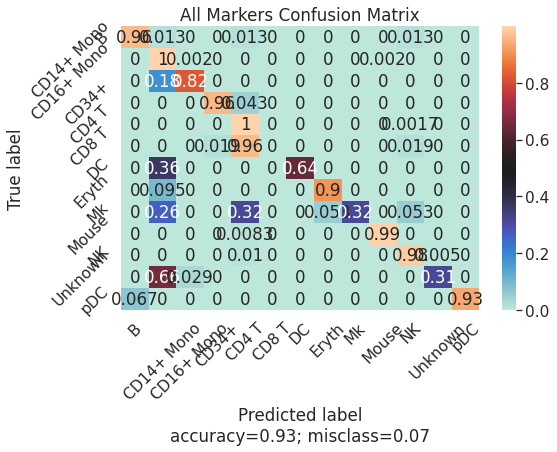

In [63]:
results =  np.load(model_save_path + 'all_markers_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'All Markers Confusion Matrix', save_path = viz_save_path + 'all_markers_cm.pdf', cmap = 'icefire')

### Smash RF

In [64]:
results =  np.load(model_save_path + 'smash_rf_results_{}.npy'.format(1), allow_pickle = True)

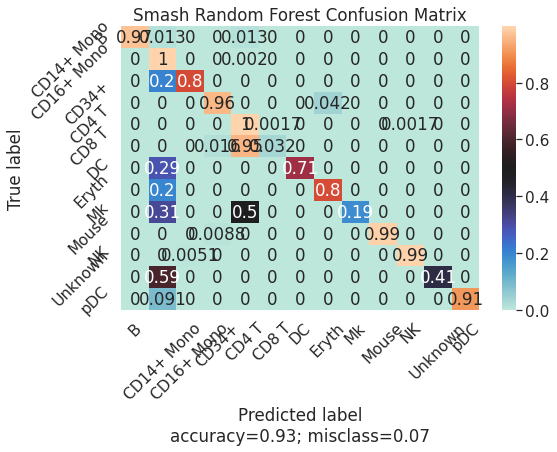

In [65]:
plot_confusion_matrix(results[2], encoder.classes_, title = 'Smash Random Forest Confusion Matrix', save_path = viz_save_path + 'smash_rf_cm.pdf', cmap = 'icefire')

### Smash DNN

In [66]:
results =  np.load(model_save_path + 'smash_results_{}.npy'.format(1), allow_pickle = True)

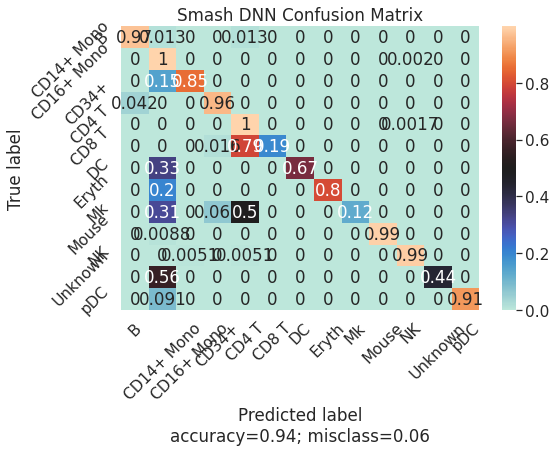

In [67]:
plot_confusion_matrix(results[2], encoder.classes_, title = 'Smash DNN Confusion Matrix', save_path = viz_save_path + 'smash_cm.pdf', cmap = 'icefire')

### RankCorr

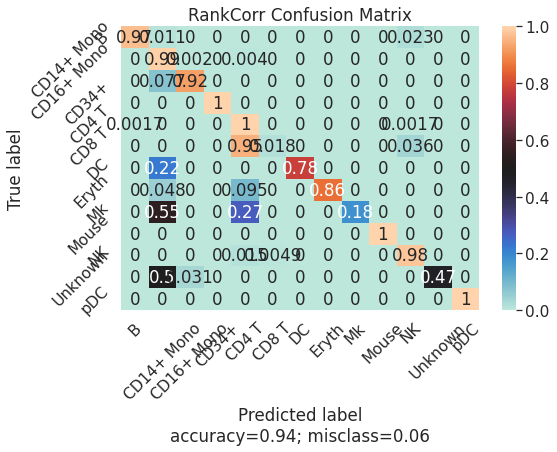

In [68]:
results =  np.load(model_save_path + 'rankcorr_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'RankCorr Confusion Matrix', save_path = viz_save_path + 'rankcorr_cm.pdf', cmap = 'icefire')

### L1 VAE

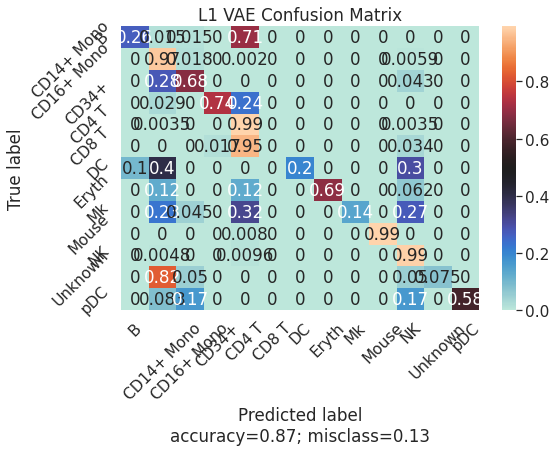

In [69]:
results =  np.load(model_save_path + 'l1_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'L1 VAE Confusion Matrix', save_path = viz_save_path + 'l1_vae_cm.pdf', cmap = 'icefire')

### Global Gate VAE

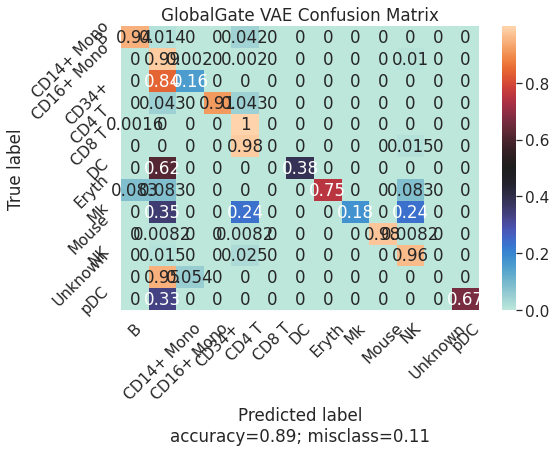

In [70]:
results =  np.load(model_save_path + 'globalgate_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'GlobalGate VAE Confusion Matrix', save_path = viz_save_path + 'globalgate_vae_cm.pdf', cmap = 'icefire')

### Running MarkerMap Unsupervised

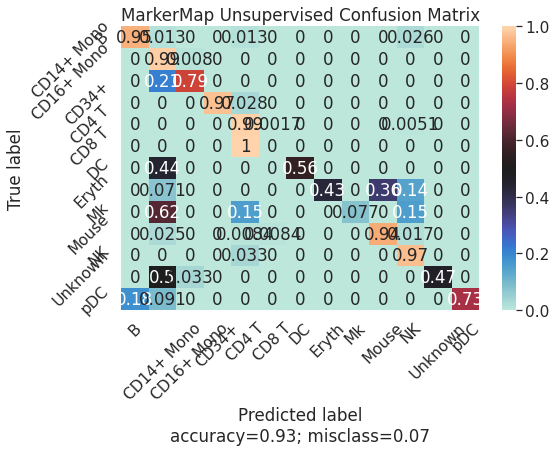

In [71]:
results =  np.load(model_save_path + 'marker_map_unsupervised_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'MarkerMap Unsupervised Confusion Matrix', save_path = viz_save_path + 'marker_map_unsupervised_cm.pdf', cmap = 'icefire')

### Running MarkerMap Supervised


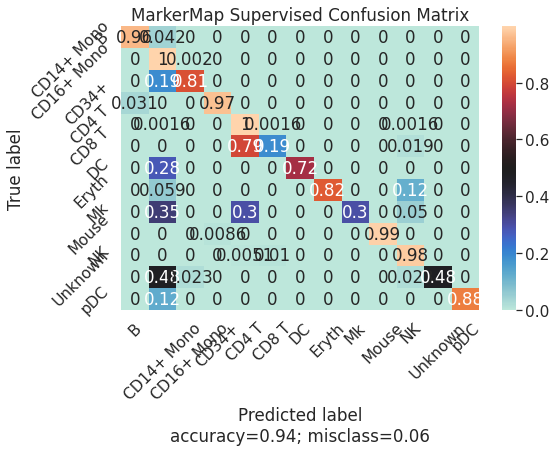

In [72]:
results =  np.load(model_save_path + 'marker_map_supervised_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'MarkerMap Supervised Confusion Matrix', save_path = viz_save_path + 'marker_map_supervised_cm.pdf', cmap = 'icefire')

### MarkerMap Mixed Supervision

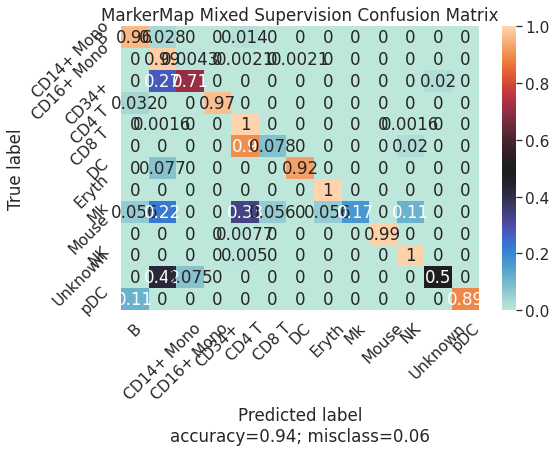

In [73]:
results =  np.load(model_save_path + 'marker_map_mixed_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'MarkerMap Mixed Supervision Confusion Matrix', save_path = viz_save_path + 'marker_map_mixed_cm.pdf', cmap = 'icefire')

### Concrete VAE

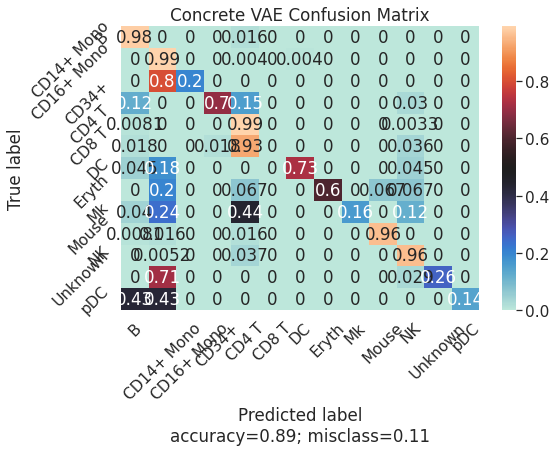

In [74]:
results =  np.load(model_save_path + 'concrete_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Concrete VAE Confusion Matrix', save_path = viz_save_path + 'concrete_vae_cm.pdf', cmap = 'icefire')

## LassoNet

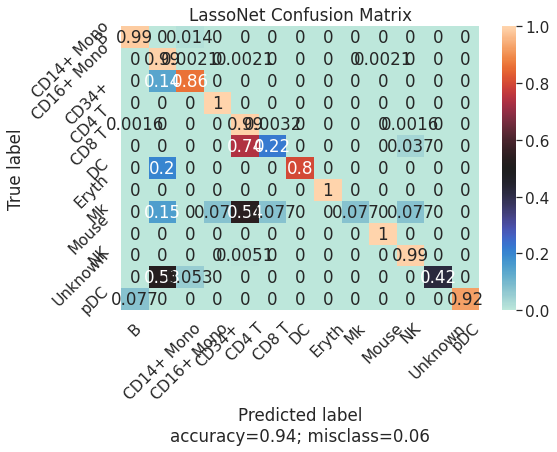

In [75]:
results =  np.load(model_save_path + 'lasso_net_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'LassoNet Confusion Matrix', save_path = viz_save_path + 'lasso_net_cm.pdf', cmap = 'icefire')

## Visualizing k on weighted f1

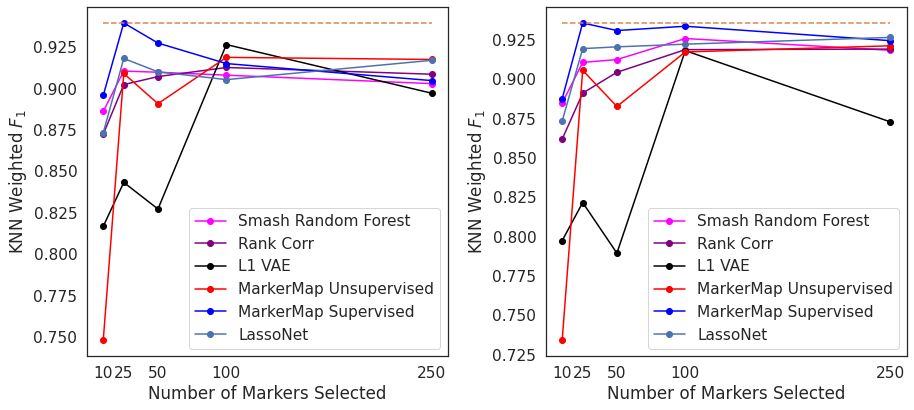

In [76]:
fig, axs = plt.subplots(1, 2, figsize = (13, 6))

#rf
smash_rf_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_rf_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(rep['weighted avg']['f1-score'])


smash_dnn_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(rep['weighted avg']['f1-score'])

rank_corr_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'rankcorr_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(rep['weighted avg']['f1-score'])

l1_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'l1_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(rep['weighted avg']['f1-score'])

globalgate_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'globalgate_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(rep['weighted avg']['f1-score'])

marker_map_unsupervised_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_unsupervised_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_unsupervised_scores.append(rep['weighted avg']['f1-score'])

marker_map_supervised_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_supervised_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_supervised_scores.append(rep['weighted avg']['f1-score'])


marker_map_mixed_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_mixed_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_mixed_scores.append(rep['weighted avg']['f1-score'])

concrete_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'concrete_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(rep['weighted avg']['f1-score'])

lasso_net_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'lasso_net_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(rep['weighted avg']['f1-score'])

scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, marker_map_unsupervised_scores, marker_map_supervised_scores, 
          marker_map_mixed_scores, concrete_scores, lasso_net_scores]
max_point = max([max(score) for score in scores])
axs[0].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
#plt.plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[0].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[0].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
#plt.plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[0].plot(k_range, marker_map_unsupervised_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[0].plot(k_range, marker_map_supervised_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
#plt.plot(k_range, marker_map_mixed_scores, label = 'RunningState VAE+Classifier', color = 'blue', marker = 'o')
#plt.plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o)
axs[0].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[0].plot(k_range, max_point * np.ones(len(k_range)), linestyle = '--')
axs[0].set_xlabel("Number of Markers Selected")
axs[0].set_xticks(k_range)
axs[0].set_ylabel(r"KNN Weighted $F_1$")
axs[0].legend()

#knn

smash_rf_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_rf_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(rep['weighted avg']['f1-score'])


smash_dnn_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(rep['weighted avg']['f1-score'])

rank_corr_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'rankcorr_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(rep['weighted avg']['f1-score'])

l1_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'l1_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(rep['weighted avg']['f1-score'])

globalgate_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'globalgate_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(rep['weighted avg']['f1-score'])

marker_map_unsupervised_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_unsupervised_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_unsupervised_scores.append(rep['weighted avg']['f1-score'])

marker_map_supervised_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_supervised_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_supervised_scores.append(rep['weighted avg']['f1-score'])


marker_map_mixed_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_mixed_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_mixed_scores.append(rep['weighted avg']['f1-score'])

concrete_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'concrete_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(rep['weighted avg']['f1-score'])

lasso_net_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'lasso_net_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(rep['weighted avg']['f1-score'])


scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, marker_map_unsupervised_scores, marker_map_supervised_scores, 
          marker_map_mixed_scores, concrete_scores, lasso_net_scores]
max_point = max([max(score) for score in scores])
axs[1].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
#plt.plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[1].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[1].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
#plt.plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[1].plot(k_range, marker_map_unsupervised_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[1].plot(k_range, marker_map_supervised_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
#plt.plot(k_range, marker_map_mixed_scores, label = 'RunningState VAE+Classifier', color = 'blue', marker = 'o')
#plt.plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o)
axs[1].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[1].plot(k_range, max_point * np.ones(len(k_range)), linestyle = '--')
axs[1].set_xlabel("Number of Markers Selected")
axs[1].set_xticks(k_range)
axs[1].set_ylabel(r"KNN Weighted $F_1$")
axs[1].legend()

plt.tight_layout()
plt.savefig(viz_save_path + 'CiteSeq_weighted_f1_vs_k.pdf')

#### Include everything

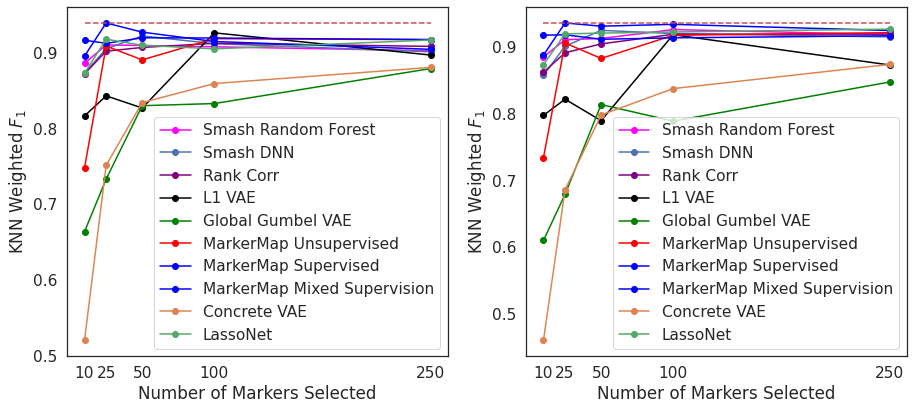

In [77]:
fig, axs = plt.subplots(1, 2, figsize = (13, 6))

#rf
smash_rf_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_rf_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(rep['weighted avg']['f1-score'])


smash_dnn_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(rep['weighted avg']['f1-score'])

rank_corr_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'rankcorr_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(rep['weighted avg']['f1-score'])

l1_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'l1_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(rep['weighted avg']['f1-score'])

globalgate_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'globalgate_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(rep['weighted avg']['f1-score'])

marker_map_unsupervised_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_unsupervised_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_unsupervised_scores.append(rep['weighted avg']['f1-score'])

marker_map_supervised_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_supervised_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_supervised_scores.append(rep['weighted avg']['f1-score'])


marker_map_mixed_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_mixed_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_mixed_scores.append(rep['weighted avg']['f1-score'])

concrete_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'concrete_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(rep['weighted avg']['f1-score'])

lasso_net_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'lasso_net_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(rep['weighted avg']['f1-score'])

scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, marker_map_unsupervised_scores, marker_map_supervised_scores, 
          marker_map_mixed_scores, concrete_scores, lasso_net_scores]
max_point = max([max(score) for score in scores])
axs[0].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
axs[0].plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[0].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[0].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
axs[0].plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[0].plot(k_range, marker_map_unsupervised_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[0].plot(k_range, marker_map_supervised_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
axs[0].plot(k_range, marker_map_mixed_scores, label = 'MarkerMap Mixed Supervision', color = 'blue', marker = 'o')
axs[0].plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o')
axs[0].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[0].plot(k_range, max_point * np.ones(len(k_range)), linestyle = '--')
axs[0].set_xlabel("Number of Markers Selected")
axs[0].set_xticks(k_range)
axs[0].set_ylabel(r"KNN Weighted $F_1$")
axs[0].legend()

#knn

smash_rf_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_rf_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(rep['weighted avg']['f1-score'])


smash_dnn_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(rep['weighted avg']['f1-score'])

rank_corr_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'rankcorr_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(rep['weighted avg']['f1-score'])

l1_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'l1_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(rep['weighted avg']['f1-score'])

globalgate_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'globalgate_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(rep['weighted avg']['f1-score'])

marker_map_unsupervised_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_unsupervised_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_unsupervised_scores.append(rep['weighted avg']['f1-score'])

marker_map_supervised_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_supervised_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_supervised_scores.append(rep['weighted avg']['f1-score'])


marker_map_mixed_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_mixed_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_mixed_scores.append(rep['weighted avg']['f1-score'])

concrete_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'concrete_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(rep['weighted avg']['f1-score'])

lasso_net_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'lasso_net_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(rep['weighted avg']['f1-score'])


scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, marker_map_unsupervised_scores, marker_map_supervised_scores, 
          marker_map_mixed_scores, concrete_scores, lasso_net_scores]
max_point = max([max(score) for score in scores])
axs[1].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
axs[1].plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[1].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[1].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
axs[1].plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[1].plot(k_range, marker_map_unsupervised_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[1].plot(k_range, marker_map_supervised_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
axs[1].plot(k_range, marker_map_mixed_scores, label = 'MarkerMap Mixed Supervision', color = 'blue', marker = 'o')
axs[1].plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o')
axs[1].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[1].plot(k_range, max_point * np.ones(len(k_range)), linestyle = '--')
axs[1].set_xlabel("Number of Markers Selected")
axs[1].set_xticks(k_range)
axs[1].set_ylabel(r"KNN Weighted $F_1$")
axs[1].legend()

plt.tight_layout()
plt.savefig(viz_save_path + 'CiteSeq_weighted_f1_vs_k_all.pdf')

### Do Misclassification now

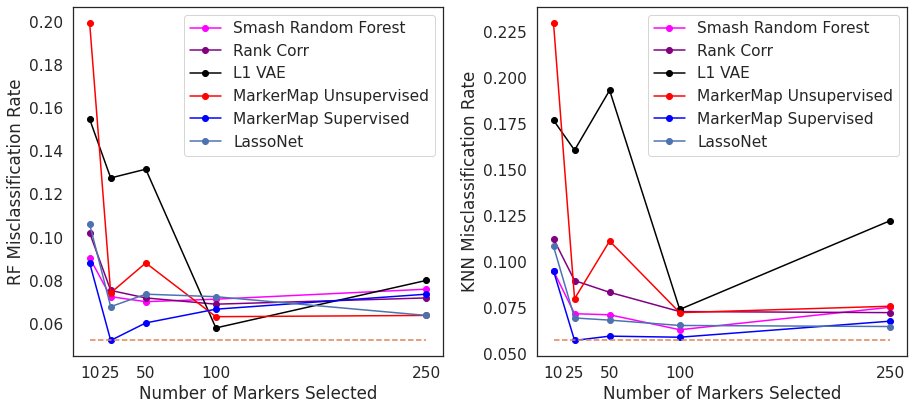

In [78]:
fig, axs = plt.subplots(1, 2, figsize = (13, 6))
# random forest
smash_rf_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_rf_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(m)

smash_dnn_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(m)

rank_corr_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'rankcorr_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(m)

l1_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'l1_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(m)

globalgate_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'globalgate_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(m)

marker_map_unsupervised_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_unsupervised_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_unsupervised_scores.append(m)

marker_map_supervised_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_supervised_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_supervised_scores.append(m)

marker_map_mixed_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_mixed_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_mixed_scores.append(m)

concrete_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'concrete_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(m)

lasso_net_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'lasso_net_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(m)
    
scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, marker_map_unsupervised_scores, marker_map_supervised_scores, 
          marker_map_mixed_scores, concrete_scores, lasso_net_scores]
min_point = min([min(score) for score in scores])
axs[0].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
#plt.plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[0].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[0].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
#plt.plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[0].plot(k_range, marker_map_unsupervised_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[0].plot(k_range, marker_map_supervised_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
#plt.plot(k_range, marker_map_mixed_scores, label = 'RunningState VAE+Classifier', color = 'blue', marker = 'o')
#plt.plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o)
axs[0].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[0].plot(k_range, min_point * np.ones(len(k_range)), linestyle = '--')
axs[0].set_xlabel("Number of Markers Selected")
axs[0].set_xticks(k_range)
axs[0].set_ylabel("RF Misclassification Rate")
axs[0].legend()

# knn
smash_rf_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_rf_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(m)

smash_dnn_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(m)

rank_corr_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'rankcorr_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(m)

l1_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'l1_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(m)

globalgate_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'globalgate_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(m)

marker_map_unsupervised_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_unsupervised_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_unsupervised_scores.append(m)

marker_map_supervised_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_supervised_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_supervised_scores.append(m)

marker_map_mixed_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_mixed_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_mixed_scores.append(m)

concrete_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'concrete_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(m)

lasso_net_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'lasso_net_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(m)

scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, marker_map_unsupervised_scores, marker_map_supervised_scores, 
          marker_map_mixed_scores, concrete_scores, lasso_net_scores]
min_point = min([min(score) for score in scores])
axs[1].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
#plt.plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[1].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[1].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
#plt.plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[1].plot(k_range, marker_map_unsupervised_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[1].plot(k_range, marker_map_supervised_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
#plt.plot(k_range, marker_map_mixed_scores, label = 'RunningState VAE+Classifier', color = 'blue', marker = 'o')
#plt.plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o)
axs[1].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[1].plot(k_range, min_point * np.ones(len(k_range)), linestyle = '--')
axs[1].set_xlabel("Number of Markers Selected")
axs[1].set_xticks(k_range)
axs[1].set_ylabel("KNN Misclassification Rate")
axs[1].legend()

plt.tight_layout()
plt.savefig(viz_save_path + 'CiteSeq_misclassification_vs_k.pdf')

##### Include everything

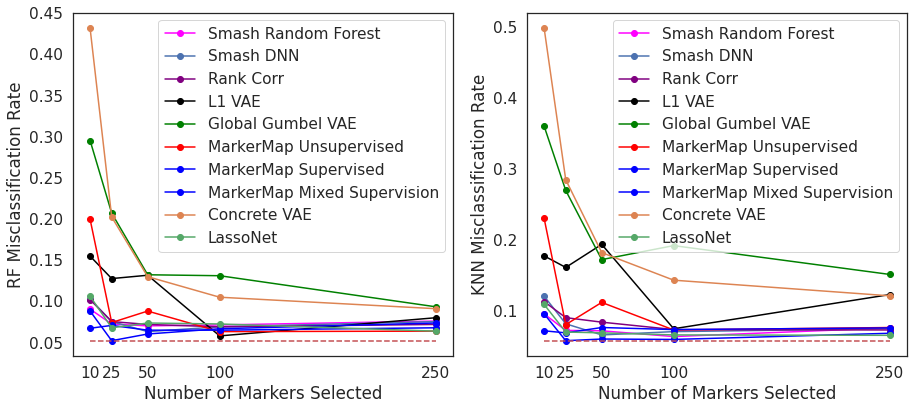

In [79]:
fig, axs = plt.subplots(1, 2, figsize = (13, 6))
# random forest
smash_rf_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_rf_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(m)

smash_dnn_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(m)

rank_corr_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'rankcorr_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(m)

l1_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'l1_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(m)

globalgate_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'globalgate_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(m)

marker_map_unsupervised_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_unsupervised_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_unsupervised_scores.append(m)

marker_map_supervised_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_supervised_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_supervised_scores.append(m)

marker_map_mixed_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_mixed_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_mixed_scores.append(m)

concrete_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'concrete_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(m)

lasso_net_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'lasso_net_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(m)
    
scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, marker_map_unsupervised_scores, marker_map_supervised_scores, 
          marker_map_mixed_scores, concrete_scores, lasso_net_scores]
min_point = min([min(score) for score in scores])
axs[0].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
axs[0].plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[0].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[0].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
axs[0].plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[0].plot(k_range, marker_map_unsupervised_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[0].plot(k_range, marker_map_supervised_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
axs[0].plot(k_range, marker_map_mixed_scores, label = 'MarkerMap Mixed Supervision', color = 'blue', marker = 'o')
axs[0].plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o')
axs[0].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[0].plot(k_range, min_point * np.ones(len(k_range)), linestyle = '--')
axs[0].set_xlabel("Number of Markers Selected")
axs[0].set_xticks(k_range)
axs[0].set_ylabel("RF Misclassification Rate")
axs[0].legend()

# knn
smash_rf_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_rf_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(m)

smash_dnn_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(m)

rank_corr_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'rankcorr_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(m)

l1_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'l1_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(m)

globalgate_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'globalgate_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(m)

marker_map_unsupervised_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_unsupervised_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_unsupervised_scores.append(m)

marker_map_supervised_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_supervised_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_supervised_scores.append(m)

marker_map_mixed_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_mixed_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_mixed_scores.append(m)

concrete_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'concrete_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(m)

lasso_net_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'lasso_net_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(m)

scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, marker_map_unsupervised_scores, marker_map_supervised_scores, 
          marker_map_mixed_scores, concrete_scores, lasso_net_scores]
min_point = min([min(score) for score in scores])
axs[1].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
axs[1].plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[1].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[1].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
axs[1].plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[1].plot(k_range, marker_map_unsupervised_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[1].plot(k_range, marker_map_supervised_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
axs[1].plot(k_range, marker_map_mixed_scores, label = 'MarkerMap Mixed Supervision', color = 'blue', marker = 'o')
axs[1].plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o')
axs[1].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[1].plot(k_range, min_point * np.ones(len(k_range)), linestyle = '--')
axs[1].set_xlabel("Number of Markers Selected")
axs[1].set_xticks(k_range)
axs[1].set_ylabel("KNN Misclassification Rate")
axs[1].legend()

plt.tight_layout()
plt.savefig(viz_save_path + 'CiteSeq_misclassification_vs_k_all.pdf')

## Visualize Marker Selection

### Smash RF

In [80]:
smash_rf_markers = {}
smash_rf_f1 = {}

In [81]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/smash_rf_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'smash_rf_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'smash_rf_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    smash_rf_markers[k] = marker_data
    smash_rf_f1[k] = weighted_f1_score

### Smash DNN

In [82]:
smash_dnn_markers = {}
smash_dnn_f1 = {}

In [83]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/smash_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'smash_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'smash_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    smash_dnn_markers[k] = marker_data
    smash_dnn_f1[k] = weighted_f1_score

### RankCorr

In [84]:
rankcorr_markers ={}
rankcorr_f1 = {}

In [85]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/rankcorr_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'rankcorr_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'rankcorr_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    rankcorr_markers[k] = marker_data
    rankcorr_f1[k] = weighted_f1_score

### L1 VAE

In [86]:
l1_vae_markers = {}
l1_vae_f1 = {}

In [87]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/l1_vae_indices_k_{}.npy'.format(k), allow_pickle = True)
    X_train = X[train_indices, :]
    feature_std = np.apply_along_axis(np.std, 0, X_train)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'l1_vae_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']

    model = load_model(VAE_l1_diag, model_save_path + 'l1_vae_k_{}.ckpt'.format(k))
    with torch.no_grad():
        markers = model.markers(feature_std, k)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    l1_vae_markers[k] = marker_data
    l1_vae_f1[k] = weighted_f1_score

### GlobalGate VAE

In [88]:
globalgate_vae_markers = {}
globalgate_vae_f1 = {}

In [89]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/globalgate_vae_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'globalgate_vae_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'globalgate_vae_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    globalgate_vae_markers[k] = marker_data
    globalgate_vae_f1[k] = weighted_f1_score

### MarkerMap Unsupervised

In [90]:
marker_map_unsupervised_markers = {}
marker_map_unsupervised_f1 = {}

In [91]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/marker_map_unsupervised_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'marker_map_unsupervised_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'marker_map_unsupervised_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    marker_map_unsupervised_markers[k] = marker_data
    marker_map_unsupervised_f1[k] = weighted_f1_score

### RunningState Classifier

In [92]:
marker_map_supervised_markers = {}
marker_map_supervised_f1 = {}

In [93]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/marker_map_supervised_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'marker_map_supervised_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'marker_map_supervised_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    marker_map_supervised_markers[k] = marker_data
    marker_map_supervised_f1[k] = weighted_f1_score

### MarkerMap Mixed Supervision

In [94]:
marker_map_mixed_markers = {}
marker_map_mixed_f1 = {}

In [95]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/marker_map_mixed_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'marker_map_mixed_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'marker_map_mixed_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    marker_map_mixed_markers[k] = marker_data
    marker_map_mixed_f1[k] = weighted_f1_score

### Concrete VAE

In [96]:
concrete_vae_markers = {}
concrete_vae_f1 = {}

In [97]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/concrete_vae_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'concrete_vae_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'concrete_vae_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    concrete_vae_markers[k] = marker_data
    concrete_vae_f1[k] = weighted_f1_score

## LassoNet

In [98]:
lasso_net_markers = {}
lasso_net_f1 = {}

In [99]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/lasso_net_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'lasso_net_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'lasso_net_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    lasso_net_markers[k] = marker_data
    lasso_net_f1[k] = weighted_f1_score

###The Actual Subplot

In [100]:
def plot_row(ax, name, k_range, markers, f1):
    assert len(ax) == len(k_range)
    for i in range(len(k_range)):
        col = ax[i]
        k = k_range[i]
        if i == 0:
            col.set_ylabel("{}".format(name))
        col.set_ylim([0, 1.2])
        col.set_yticks([0, 1.0])
        col.set_title("{} Markers(Weighted F1 {:.3g})".format(k, f1[k]))        
        col.bar(range(X.shape[1]), markers[k])
    return

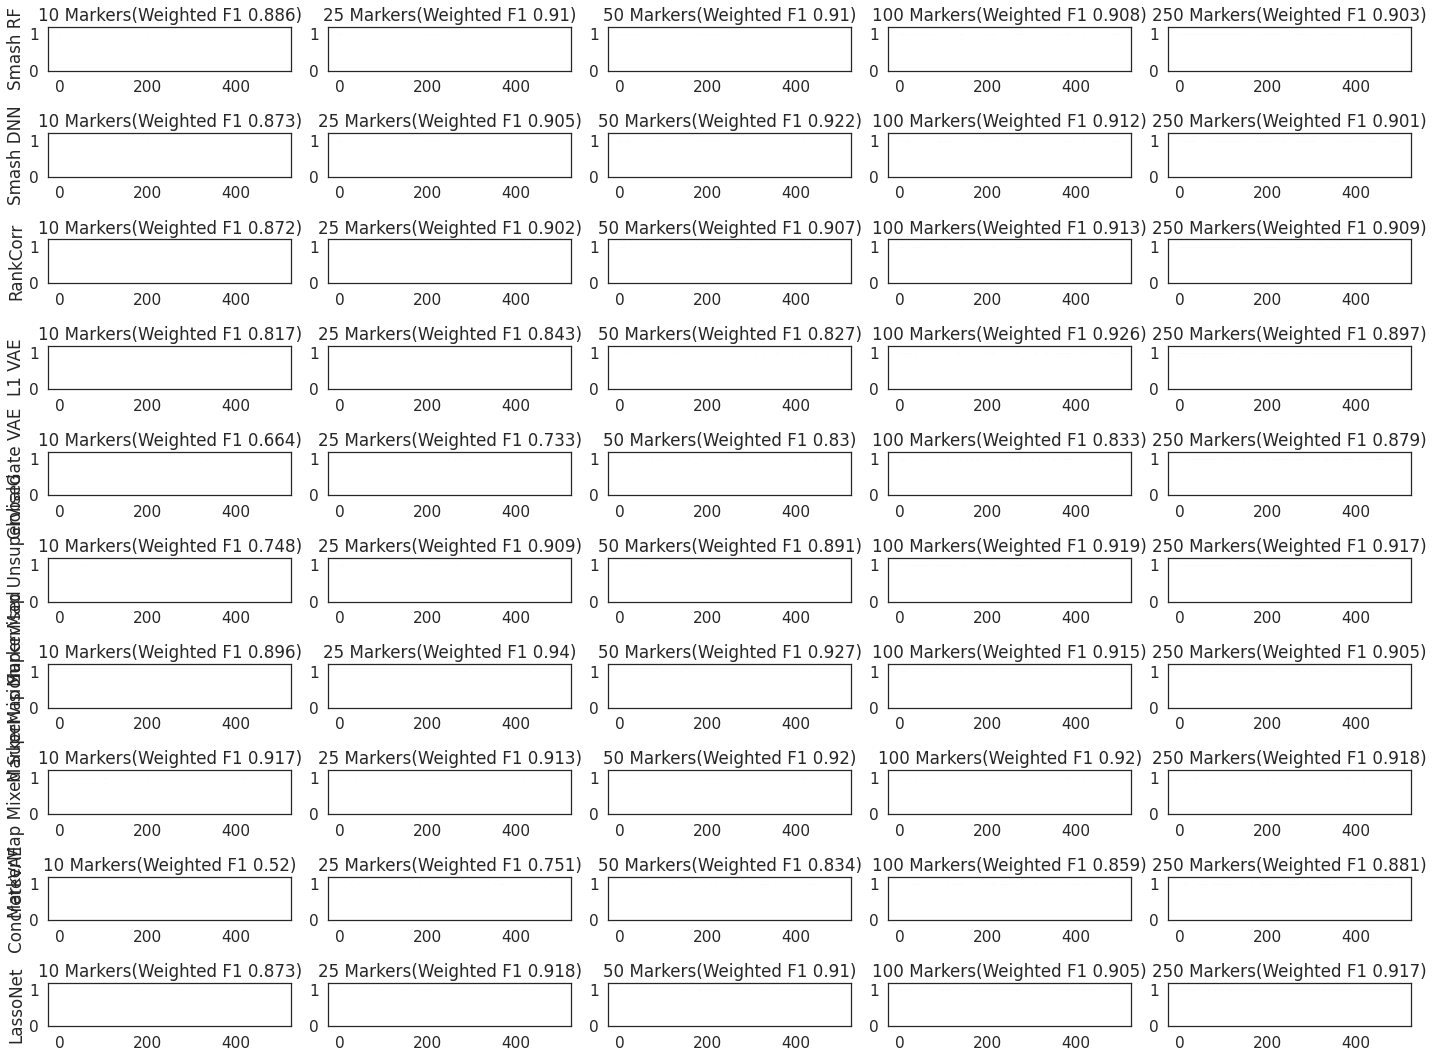

In [101]:
fig, axs = plt.subplots(nrows=10, ncols = len(k_range), figsize = (20, 15))

plot_row(axs[0], 'Smash RF', k_range, smash_rf_markers, smash_rf_f1)
plot_row(axs[1], 'Smash DNN', k_range, smash_dnn_markers, smash_dnn_f1)
plot_row(axs[2], 'RankCorr', k_range, rankcorr_markers, rankcorr_f1)
plot_row(axs[3], 'L1 VAE', k_range, l1_vae_markers, l1_vae_f1)
plot_row(axs[4], 'GlobalGate VAE', k_range, globalgate_vae_markers, globalgate_vae_f1)
plot_row(axs[5], 'MarkerMap Unsupervised', k_range, marker_map_unsupervised_markers, marker_map_unsupervised_f1)
plot_row(axs[6], 'MarkerMap Supervised', k_range, marker_map_supervised_markers, marker_map_supervised_f1)
plot_row(axs[7], 'MarkerMap Mixed Supervision', k_range, marker_map_mixed_markers, marker_map_mixed_f1)
plot_row(axs[8], 'ConcreteVAE', k_range, concrete_vae_markers, concrete_vae_f1)
plot_row(axs[9], 'LassoNet', k_range, lasso_net_markers, lasso_net_f1)


plt.tight_layout()
plt.savefig(viz_save_path + 'CiteSeq_SelectedMarkers_All_Methods_ks.png')
plt.show()

In [102]:
plt.close('all')